<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:10px 5px'> 
Master Thesis Yannik Haller - Exploratory Data Analysis (EDA) Using General Topics (Media Sections)
</h1>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
Preparation: load packages, set the appropriate working directory and load the data
</h2>
</div>

In [1]:
# Import required baseline packages
import re
import os
import glob
import time
import sys
import pandas as pd
import numpy as np

# Change pandas' setting to print out long strings
pd.options.display.max_colwidth = 200

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
# Set global parameters for plotting
import matplotlib.pylab as pylab
params = {'legend.fontsize': 10,
          'figure.figsize': (8, 6),
          'axes.labelsize': 14,
          'axes.titlesize': 16,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10}
pylab.rcParams.update(params)

# Regression and smoothing tools
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold

# Disable warnings
import warnings
warnings.filterwarnings("ignore", category = DeprecationWarning)
warnings.filterwarnings("ignore", category = FutureWarning)

In [2]:
# Set the appropriate working directory
os.chdir('D:\\Dropbox\\MA_data')

In [3]:
# Read in the data articles metadata
articles = pd.read_csv("Analysis/articles_main.csv", index_col = 0, usecols = list(np.append(np.arange(24),30)))
# Transform publication_date into a daily date type
articles.publication_date = pd.to_datetime(articles.publication_date, yearfirst = True).astype('datetime64[D]')
# Transform the Topic_ID_2 into an integer type (not possible to read in as integer, due to missing values)
articles['Topic_ID_2'] = articles['Topic_ID_2'].astype("Int32")
# Take a look at the dataframe
articles

source_short source_long publication_date language  year  month  week  \
0                AGE       Agefi       2020-10-01       fr  2020     10    39   
1                AGE       Agefi       2020-10-01       fr  2020     10    39   
2                AGE       Agefi       2020-10-01       fr  2020     10    39   
3                AGE       Agefi       2020-10-01       fr  2020     10    39   
4                AGE       Agefi       2020-10-01       fr  2020     10    39   
...              ...         ...              ...      ...   ...    ...   ...   
2441178          ZWA  20 minuten       2021-01-22       de  2021      1     3   
2441179          ZWA  20 minuten       2021-01-22       de  2021      1     3   
2441180          ZWA  20 minuten       2021-01-22       de  2021      1     3   
2441181          ZWA  20 minuten       2021-01-22       de  2021      1     3   
2441182          ZWA  20 minuten       2021-01-22       de  2021      1     3   

          weekday year_month year_week  ...                 Topic_1  \
0        Thursday    2020-10   2020-39  ...  politics_international   
1        Thursday    2020-10   2020-39  ...   economy_international   
2        Thursday    2020-10   2020-39  ...   economy_international   
3        Thursday    2020-10   2020-39  ...   economy_international   
4        Thursday    2020-10   2020-39  ...   economy_international   
...           ...        ...       ...  ...                     ...   
2441178    Friday    2021-01   2021-03  ...        economy_national   
2441179    Friday    2021-01   2021-03  ...         inconsequential   
2441180    Friday    2021-01   2021-03  ...                  sports   
2441181    Friday    2021-01   2021-03  ...        tragedies_crimes   
2441182    Friday    2021-01   2021-03  ...         inconsequential   

                       Topic_2  Topic_ID_fine  Affiliation_Prob_fine  \
0        economy_international            NaN               0.329300   
1             economy_national            NaN               0.462487   
2             economy_national            NaN               0.325522   
3             economy_national            NaN               0.473720   
4             economy_national            NaN               0.598861   
...                        ...            ...                    ...   
2441178        inconsequential            NaN               0.466716   
2441179       economy_national            NaN               0.315961   
2441180              law_order            NaN               0.377586   
2441181              law_order            NaN               0.433544   
2441182        inconsequential            NaN               0.464621   

                     Topic_fine Vader_polarity  Vader_polarity_adj  \
0        politics_international         0.9785              0.1582   
1         economy_international        -0.7772             -0.1196   
2         economy_international         0.7561              0.0414   
3         economy_international         0.8078              0.0780   
4         economy_international        -0.8205             -0.0869   
...                         ...            ...                 ...   
2441178        economy_national         0.9693              0.1817   
2441179         inconsequential        -0.7441             -0.0514   
2441180                  sports         0.8391              0.2133   
2441181        tragedies_crimes        -0.8689             -0.5667   
2441182         inconsequential         0.9928              0.2226   

         Vader_polarity_adj_2 Blob_polarity  ch_stridx  
0                      0.1582      0.124348  33.333332  
1                     -0.1996      0.100000  33.333332  
2                     -0.0218      0.163700  33.333332  
3                      0.0780     -0.012364  33.333332  
4                     -0.1215      0.207273  33.333332  
...                       ...           ...        ...  
2441178                0.1817     -0.100000  75.000000  
2441179             

In [4]:
# Inspect the datatypes of the columns
articles.dtypes

source_short                     object
source_long                      object
publication_date         datetime64[ns]
language                         object
year                              int64
month                             int64
week                              int64
weekday                          object
year_month                       object
year_week                        object
Topic_ID_1                        int64
Affiliation_Prob_1              float64
Topic_ID_2                        Int32
Affiliation_Prob_2              float64
Topic_1                          object
Topic_2                          object
Topic_ID_fine                   float64
Affiliation_Prob_fine           float64
Topic_fine                       object
Vader_polarity                  float64
Vader_polarity_adj              float64
Vader_polarity_adj_2            float64
Blob_polarity                   float64
ch_stridx                       float64
dtype: object

## General note regarding the columns that contain the different polarity scores:

- Vader_polarity: For French and German articles this column contains tho originial Vader polarity. For Italian articles the polarities estimated by the self-developed Naïve setiment algorithm are used.
- Vader_polarity_adj: For French and German articles this column contains the Vader polarity estimated with the adjusted scoring function (s.t. longer texts are not inherently assigned with more extreme values). For Italian articles the polarities estimated by the self-developed Naïve setiment algorithm are used.
- Vader_polarity_adj_2: For French and German articles this column contains the Vader polarity estimated with the adjusted scoring function (s.t. longer texts are not inherently assigned with more extreme values). For Italian articles the polarities estimated by the self-developed Naïve setiment algorithm are used. Moreover, the sentiment algorithms of all languages rely on the manually extended sentiment lexicons, which are augmented by Covid-19-related terms.
- Blob_polarity: For French and German articles this column contains tho originial TextBlob Polarity. For Italian articles the polarities estimated by the self-developed Naïve setiment algorithm are used.

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
1. Language-specific EDA
</h2>
</div>

In [5]:
## Define all functions needed subsequently

# Define a function to display the language specific distribution of publications per media channel
def show_publ_dist_channels(articles, language, figsize = (13, 18)):
    """
    This function generates a horizontal barplot to visualize the language specific distribution per media channel
    """
    # Count the publications per media channel for the language specific articles
    channel_counts = np.unique(articles.loc[articles['language'] == language, 'source_long'], return_counts = True)
    # Create a dataframe containing the media channel together with the article counts and sort it by the name of the media channel
    channel_counts = pd.DataFrame({'source': channel_counts[0], 'counts': channel_counts[1]}).sort_values('source')
    # Extract the channels and counts as lists
    channels = channel_counts.source.to_list()
    counts = channel_counts.counts.to_list()
    # Plot the media channel distribution
    plt.rc('legend', fontsize = 15)
    fig = plt.figure(figsize = figsize)
    ax = fig.add_subplot(111)
    y_pos = np.arange(len(channels))
    if language == 'de':
        ax.barh(y_pos, counts, align = 'center', color = 'black', alpha = 0.8, label = 'Total Number of German Publications')
    elif language == 'fr':
        ax.barh(y_pos, counts, align = 'center', color = 'black', alpha = 0.8, label = 'Total Number of French Publications')
    elif language == 'it':
        ax.barh(y_pos, counts, align = 'center', color = 'black', alpha = 0.8, label = 'Total Number of Italian Publications')
    ax.set_ylabel('Media Outlet')
    ax.xaxis.label.set_size(18)
    ax.set_xlabel('Number of Publications')
    ax.yaxis.label.set_size(18)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(channels)
    ax.invert_yaxis() # to read labels from top-to-bottom
    if language == 'de':
        ax.set_title('Media Channel Distribution of German Articles')
    elif language == 'fr':
        ax.set_title('Media Channel Distribution of French Articles')
    elif language == 'it':
        ax.set_title('Media Channel Distribution of Italian Articles')
    ax.set_xlabel('Publication Frequency')
    # Display the plot
    plt.legend()
    plt.show()
    # Reset the parameter that determines the fontsize of the legend
    plt.rc('legend', fontsize = 10)

# Define a function to compare the language specific distribution of publications per topic
def show_publ_dist_topics(articles):
    # Get all topics
    topics = np.unique(articles['Topic_1'])
    # Create an initial dataframe
    init_df = pd.DataFrame(index = topics.tolist())
    # Count the publications per Topic for the language specific articles
    count_de = articles.loc[articles['language'] == 'de'].groupby(['Topic_1'])['Topic_1'].count()
    count_fr = articles.loc[articles['language'] == 'fr'].groupby(['Topic_1'])['Topic_1'].count()
    count_it = articles.loc[articles['language'] == 'it'].groupby(['Topic_1'])['Topic_1'].count()
    # Create a dataframe from these counts containing the language specific distribution of publications per topic
    share_de = pd.DataFrame(count_de.values/sum(count_de.values), index = count_de.index, columns = ['values'])
    share_fr = pd.DataFrame(count_fr.values/sum(count_fr.values), index = count_fr.index, columns = ['values'])
    share_it = pd.DataFrame(count_it.values/sum(count_it.values), index = count_it.index, columns = ['values'])
    # Create a dataframe containing the correct values for the visualization
    shares_de = init_df.merge(share_de, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    shares_fr = init_df.merge(share_fr, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    shares_it = init_df.merge(share_it, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Replace any missing value with a 0 since for these topics no articles were published
    shares_de.loc[shares_de['values'].isna(), 'values'] = 0
    shares_fr.loc[shares_fr['values'].isna(), 'values'] = 0
    shares_it.loc[shares_it['values'].isna(), 'values'] = 0
    # Plot the topic distribution
    fig = plt.figure(figsize = (18,8))
    # Set the width of the bars
    barwidth = 0.25
    # Set the position of the bars on the X-axis
    r1 = np.arange(len(topics))
    r2 = [x + barwidth for x in r1]
    r3 = [x + barwidth for x in r2]
    # Make the plot
    plt.bar(r1, shares_de['values'].values, color = 'red',   width = barwidth, edgecolor = 'white', label = 'German Articles')
    plt.bar(r2, shares_fr['values'].values, color = 'navy',  width = barwidth, edgecolor = 'white', label = 'French Articles')
    plt.bar(r3, shares_it['values'].values, color = 'green', width = barwidth, edgecolor = 'white', label = 'Italian Articles')
    # Add ticks
    plt.xlabel('Topic Label', fontsize = 20)
    plt.xticks([r + 1.1*barwidth for r in range(len(topics))], shares_de.index.to_list(), rotation = 'vertical', fontsize = 18)
    plt.yticks(fontsize = 14)
    plt.ylabel('Density', fontsize = 20)
    # Add title
    plt.title('Language Specific Distribution of Publications per Topic')

    # Create legend & Show graphic
    plt.legend(fontsize = 14)
    plt.show()


# Define a function to display the distribution of publications per topic
def show_publ_freq_topics_overall(articles):
    # Count the publications per Topic for the language specific articles
    topic_counts = np.unique(articles['Topic_1'], return_counts = True)
    # Create a dataframe containing the topics together with the article counts and sort it by the topic name
    topic_counts = pd.DataFrame({'topic': topic_counts[0], 'counts': topic_counts[1]}).sort_values('topic')
    # Extract the topics and counts as lists
    topics = topic_counts.topic.to_list()
    counts = topic_counts.counts.to_list()
    # Plot the topic distribution
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(111)
    x_pos = np.arange(len(topics))
    ax.bar(x_pos, counts, align = 'center')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(topics, rotation = 90, ha = 'center')
    ax.set_title('Publication-Frequency per Topic')
    ax.set_xlabel('Topic Label')
    ax.set_ylabel('Frequency')
    # Display the plot
    plt.show()


# Define a function to display the language specific development of the articles' average sentiment over time
def show_senti_development(articles, language, polarity_type = 'Vader_polarity', second_polarity_type = None):
    # Get the average polarity scores for each year_week combination of the language specific articles
    first_polarity_by_week = articles.loc[articles['language'] == language].groupby('year_week')[polarity_type].mean()
    if np.logical_not(second_polarity_type == None): 
        second_polarity_by_week = articles.loc[articles['language'] == language].groupby('year_week')[second_polarity_type].mean()
    # Get the average Swiss Stringency Index for each year_week combination of the language specific articles
    ch_stringency_by_week = articles.loc[articles['language'] == language].groupby('year_week')['ch_stridx'].mean()

    # Show the development of the weekly average polarity scores of the language specific articles
    fig, ax1 = plt.subplots(figsize = (10, 8))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels = np.sort(articles.loc[articles['language'] == language, 'year_month'].unique())
    x_pos    = np.arange(len(x_labels))
    x_labels = np.append(x_labels, '')
    fraction_last_month = float(articles.loc[articles['language'] == language, 'publication_date'].max().strftime('%W'))/53*12
    fraction_last_month = fraction_last_month - int(fraction_last_month)
    x_pos    = np.append(x_pos, max(x_pos) + fraction_last_month)
    x_pos    = x_pos*(len(first_polarity_by_week.index)/max(x_pos))
    # Set up the plot to show the development of the articles' sentiment over time
    ax1.plot(first_polarity_by_week.index, first_polarity_by_week.values, color = 'dodgerblue', linewidth = 1, alpha = 1, linestyle = 'solid', 
             label = 'Weekly Average Polarity Score ('+polarity_type.split('_')[0]+')')
    if np.logical_not(second_polarity_type == None):
        ax1.plot(second_polarity_by_week.index, second_polarity_by_week.values, color = 'navy', linewidth = 1, alpha = 1, linestyle = 'solid', 
                 label = 'Weekly Average Polarity Score ('+second_polarity_type.split('_')[0]+')')
    if language == 'de':
        ax1.set_title("Development of the German Articles' Sentiment over Time")
    elif language == 'fr':
        ax1.set_title("Development of the French Articles' Sentiment over Time")
    elif language == 'it':
        ax1.set_title("Development of the Italian Articles' Sentiment over Time")
    ax1.set_xlabel("Year-Month")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax1.set_ylabel("Polarity Score", color = 'dodgerblue')
    ax1.tick_params(axis = 'y', labelcolor = 'dodgerblue')
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_week.index, ch_stringency_by_week.values, color = 'red', linewidth = 1, alpha = 0.9, linestyle = '--', label = 'Weekly Covid-Stringency Index of Switzerland')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax2.set_ylabel('Swiss Covid Stringency Index', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend()
    plt.show()


# Define a function to display the development of the articles' average sentiment over time
def show_senti_development_overall(articles):
    # Get the average polarity scores for each year_week combination of the language specific articles
    VPA_by_week = articles.groupby('year_week')['Vader_polarity_adj'].mean()
    VPAII_by_week = articles.groupby('year_week')['Vader_polarity_adj_2'].mean()
    # Get the average Swiss Stringency Index for each year_week combination of the language specific articles
    ch_stringency_by_week = articles.groupby('year_week')['ch_stridx'].mean()

    # Show the development of the weekly average polarity scores of the language specific articles
    fig, ax1 = plt.subplots(figsize = (10, 6))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels = np.sort(articles['year_month'].unique())
    x_pos    = np.arange(len(x_labels))
    x_labels = np.append(x_labels, '')
    fraction_last_month = float(articles['publication_date'].max().strftime('%W'))/53*12
    fraction_last_month = fraction_last_month - int(fraction_last_month)
    x_pos    = np.append(x_pos, max(x_pos) + fraction_last_month)
    x_pos    = x_pos*(len(VPA_by_week.index)/max(x_pos))
    # Set up the plot to show the development of the articles' sentiment over time
    ax1.plot(VPA_by_week.index, VPA_by_week.values, color = 'navy', linewidth = 1, alpha = 1, linestyle = 'solid', 
             label = 'Weekly Average Adjusted Vader Polarity (VPA)')
    ax1.plot(VPAII_by_week.index, VPAII_by_week.values, color = 'dodgerblue', linewidth = 1, alpha = 1, linestyle = 'solid', 
             label = 'Weekly Average Adjusted Vader Polarity II (VPAII)')
    ax1.set_title("Development of the Articles' Sentiment over Time")
    ax1.set_xlabel("Year-Month", fontsize = 15)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center', fontsize = 12)
    ax1.set_ylabel("Polarity Score", color = 'dodgerblue', fontsize = 15)
    ax1.tick_params(axis = 'y', labelcolor = 'dodgerblue', labelsize = 12)
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_week.index, ch_stringency_by_week.values, color = 'red', linewidth = 1, alpha = 0.9, linestyle = '--', label = 'CH National KOFSPI')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center', fontsize = 12)
    ax2.set_ylabel('KOF Stringency-Plus Index', color = 'red', fontsize = 15)
    ax2.tick_params(axis = 'y', labelcolor = 'red', labelsize = 12)
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend(fontsize = 11)
    plt.show()


# Define a function to display and compare the language specific development of the articles' average sentiment over time
def compare_senti_development_across_languages(articles, polarity_type = 'Vader_polarity', polarity_type_abbreviation = 'VP'):
    # Get the average polarity scores for each year_week combination of the language specific articles
    de_polarity_by_week = articles.loc[articles['language'] == 'de'].groupby('year_week')[polarity_type].mean()
    fr_polarity_by_week = articles.loc[articles['language'] == 'fr'].groupby('year_week')[polarity_type].mean()
    it_polarity_by_week = articles.loc[articles['language'] == 'it'].groupby('year_week')[polarity_type].mean()
    # Get the average Swiss Stringency Index for each year_week combination
    ch_stringency_by_week = articles.groupby('year_week')['ch_stridx'].mean()

    # Show the development of the weekly average polarity scores of the language specific articles
    fig, ax1 = plt.subplots(figsize = (10, 6))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels = np.sort(articles['year_month'].unique())
    x_pos    = np.arange(len(x_labels))
    x_labels = np.append(x_labels, '')
    fraction_last_month = float(articles['publication_date'].max().strftime('%W'))/53*12
    fraction_last_month = fraction_last_month - int(fraction_last_month)
    x_pos    = np.append(x_pos, max(x_pos) + fraction_last_month)
    x_pos    = x_pos*(len(ch_stringency_by_week.index)/max(x_pos))
    # Set up the plot to show the development of the articles' sentiment over time
    ax1.plot(de_polarity_by_week.index, de_polarity_by_week.values, color = 'red',   linewidth = 1.5, alpha = 0.8, linestyle = 'solid', label = 'Weekly Average '+polarity_type_abbreviation+' of German Articles')
    ax1.plot(fr_polarity_by_week.index, fr_polarity_by_week.values, color = 'blue',  linewidth = 1.5, alpha = 0.8, linestyle = 'solid', label = 'Weekly Average '+polarity_type_abbreviation+' of French Articles')
    ax1.plot(it_polarity_by_week.index, it_polarity_by_week.values, color = 'green', linewidth = 1.5, alpha = 0.8, linestyle = 'solid', label = 'Weekly Average '+polarity_type_abbreviation+' Italian Articles')
    ax1.set_title("Development of the Articles' Sentiment over Time by Language")
    ax1.set_xlabel("Year-Month", fontsize = 15)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center', fontsize = 12)
    ax1.set_ylabel("Polarity Score", color = 'black', fontsize = 15)
    ax1.tick_params(axis = 'y', labelcolor = 'black', labelsize = 12)
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_week.index, ch_stringency_by_week.values, color = 'darkgoldenrod', linewidth = 1.2, alpha = 0.9, linestyle = '--', label = 'CH National KOFSPI')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center', fontsize = 12)
    ax2.set_ylabel('KOF Stringency-Plus Index', color = 'darkgoldenrod', fontsize = 15)
    ax2.tick_params(axis = 'y', labelcolor = 'darkgoldenrod', labelsize = 12)
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend(fontsize = 11, ncol = 2)
    plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
1.1 General summary statistics
</h3>
</div>

In [6]:
# German
np.round(articles.loc[articles['language'] == 'de', ['Affiliation_Prob_1','Affiliation_Prob_2','Vader_polarity','Vader_polarity_adj','Vader_polarity_adj_2','Blob_polarity']].describe(), 3)

Affiliation_Prob_1  Affiliation_Prob_2  Vader_polarity  \
count         1934313.000         1916803.000     1934313.000   
mean                0.450               0.223           0.551   
std                 0.165               0.076           0.670   
min                 0.032               0.010          -1.000   
25%                 0.327               0.171           0.361   
50%                 0.419               0.217           0.936   
75%                 0.541               0.270           0.989   
max                 0.998               0.496           1.000   

       Vader_polarity_adj  Vader_polarity_adj_2  Blob_polarity  
count         1934313.000           1934313.000    1934313.000  
mean                0.127                 0.104          0.177  
std                 0.179                 0.194          0.401  
min                -1.000                -1.000         -1.000  
25%                 0.029                -0.005         -0.028  
50%                 0.142                 0.123          0.198  
75%                 0.244                 0.233          0.434  
max                 1.000                 1.000          1.000

In [7]:
# French
np.round(articles.loc[articles['language'] == 'fr', ['Affiliation_Prob_1','Affiliation_Prob_2','Vader_polarity','Vader_polarity_adj','Vader_polarity_adj_2','Blob_polarity']].describe(), 3)

Affiliation_Prob_1  Affiliation_Prob_2  Vader_polarity  \
count          481162.000          474665.000      481162.000   
mean                0.478               0.217           0.284   
std                 0.183               0.079           0.808   
min                 0.037               0.010          -1.000   
25%                 0.337               0.164          -0.700   
50%                 0.444               0.212           0.782   
75%                 0.590               0.266           0.966   
max                 0.996               0.497           1.000   

       Vader_polarity_adj  Vader_polarity_adj_2  Blob_polarity  
count          481162.000            481162.000     481162.000  
mean                0.052                 0.032          0.086  
std                 0.172                 0.183          0.084  
min                -1.000                -1.000         -1.000  
25%                -0.055                -0.083          0.042  
50%                 0.068                 0.052          0.086  
75%                 0.155                 0.145          0.131  
max                 1.000                 1.000          1.000

In [8]:
# Italian
np.round(articles.loc[articles['language'] == 'it', ['Affiliation_Prob_1','Affiliation_Prob_2','Vader_polarity','Vader_polarity_adj','Vader_polarity_adj_2','Blob_polarity']].describe(), 3)

Affiliation_Prob_1  Affiliation_Prob_2  Vader_polarity  \
count           23621.000           20804.000       23621.000   
mean                0.617               0.244           0.209   
std                 0.205               0.097           0.198   
min                 0.157               0.010          -0.867   
25%                 0.451               0.178           0.093   
50%                 0.587               0.245           0.210   
75%                 0.780               0.312           0.325   
max                 0.998               0.495           1.000   

       Vader_polarity_adj  Vader_polarity_adj_2  Blob_polarity  
count           23621.000             23621.000      23621.000  
mean                0.209                 0.196          0.209  
std                 0.198                 0.201          0.198  
min                -0.867                -0.867         -0.867  
25%                 0.093                 0.076          0.093  
50%                 0.210                 0.197          0.210  
75%                 0.325                 0.315          0.325  
max                 1.000                 1.000          1.000

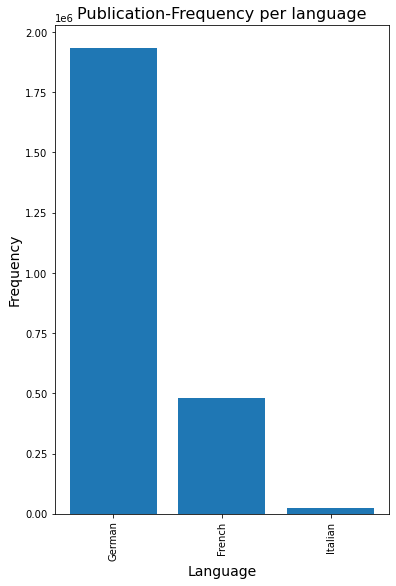

In [9]:
## Plot the language specific publication frequency in the data
# Count the publications per Topic for the language specific articles
language_counts = np.unique(articles['language'], return_counts = True)
# Create a dataframe containing the topics together with the article counts and sort it by the topic name
language_counts = pd.DataFrame({'language': language_counts[0], 'counts': language_counts[1]}).sort_values('language')
# Extract the topics and counts as lists
language = language_counts.language.to_list()
counts   = language_counts.counts.to_list()
# Plot the topic distribution
fig = plt.figure(figsize = (6,9))
ax = fig.add_subplot(111)
x_pos = np.arange(len(language))
ax.bar(x_pos, counts, align = 'center')
ax.set_xticks(x_pos)
ax.set_xticklabels(['German', 'French', 'Italian'], rotation = 90, ha = 'center')
ax.set_title('Publication-Frequency per language')
ax.set_xlabel('Language')
ax.set_ylabel('Frequency')
# Display the plot
plt.show()

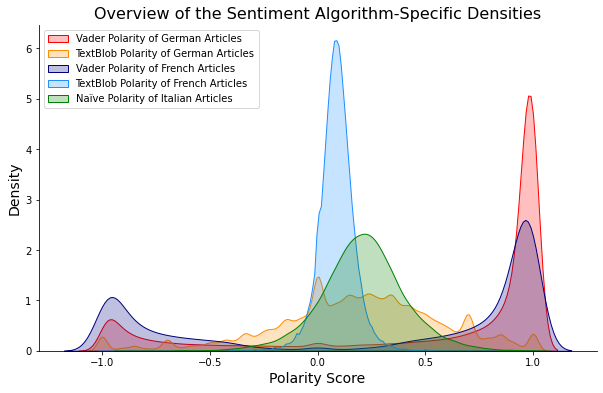

In [10]:
# Plot all sentiment classifiers specific densities (using the original Vader polarity and Blob polarity)
fig = plt.figure(figsize = (10,6))
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Vader_polarity'], shade = True, color = 'red',        label = "Vader Polarity of German Articles")
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Blob_polarity'],  shade = True, color = 'darkorange', label = "TextBlob Polarity of German Articles")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Vader_polarity'], shade = True, color = 'navy',       label = "Vader Polarity of French Articles")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Blob_polarity'],  shade = True, color = 'dodgerblue', label = "TextBlob Polarity of French Articles")
ax = sns.kdeplot(articles.loc[articles['language'] == 'it', 'Vader_polarity'], shade = True, color = 'green',      label = "Naïve Polarity of Italian Articles")
ax.set_title("Overview of the Sentiment Algorithm-Specific Densities")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

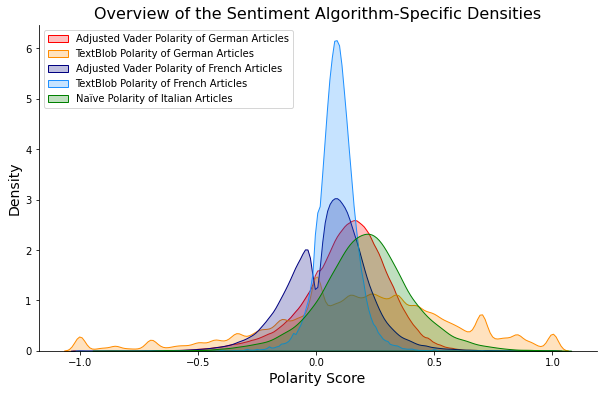

In [11]:
# Plot all sentiment classifiers specific densities (using the adjusted Vader polarity and Blob polarity)
fig = plt.figure(figsize = (10,6))
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Vader_polarity_adj'], shade = True, color = 'red',        label = "Adjusted Vader Polarity of German Articles")
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Blob_polarity'],      shade = True, color = 'darkorange', label = "TextBlob Polarity of German Articles")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Vader_polarity_adj'], shade = True, color = 'navy',       label = "Adjusted Vader Polarity of French Articles")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Blob_polarity'],      shade = True, color = 'dodgerblue', label = "TextBlob Polarity of French Articles")
ax = sns.kdeplot(articles.loc[articles['language'] == 'it', 'Vader_polarity'],     shade = True, color = 'green',      label = "Naïve Polarity of Italian Articles")
ax.set_title("Overview of the Sentiment Algorithm-Specific Densities")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

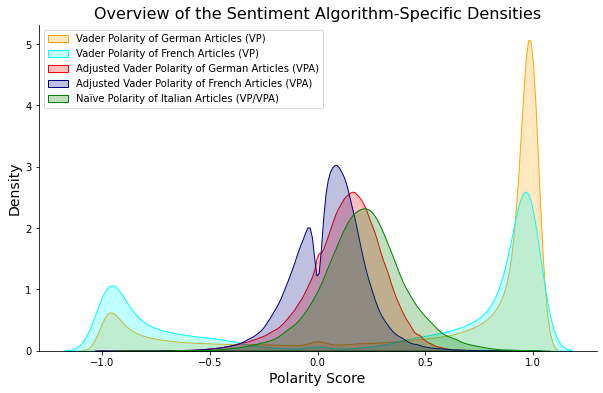

In [12]:
# Compare the language-specific densities of the Original Vader polarity with those of the Adjusted Vader Polarity
fig = plt.figure(figsize = (10,6))
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Vader_polarity'],     shade = True, color = 'orange',  label = "Vader Polarity of German Articles (VP)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Vader_polarity'],     shade = True, color = 'cyan',    label = "Vader Polarity of French Articles (VP)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Vader_polarity_adj'], shade = True, color = 'red',     label = "Adjusted Vader Polarity of German Articles (VPA)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Vader_polarity_adj'], shade = True, color = 'navy',    label = "Adjusted Vader Polarity of French Articles (VPA)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'it', 'Vader_polarity_adj'], shade = True, color = 'green',   label = "Naïve Polarity of Italian Articles (VP/VPA)")
ax.set_title("Overview of the Sentiment Algorithm-Specific Densities")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

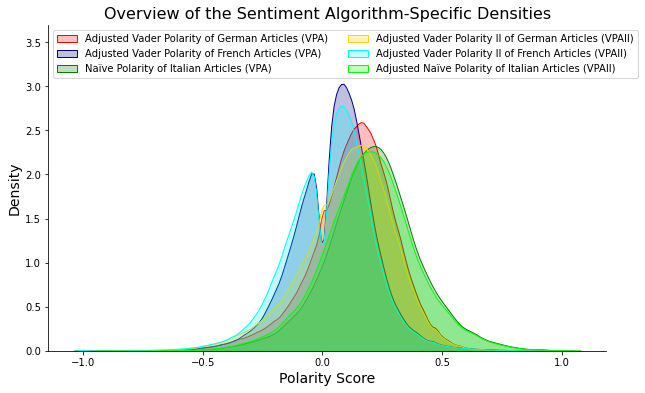

In [13]:
# Compare the language-specific densities of the Adjusted Vader polarity with those of the Adjusted Vader Polarity II
fig = plt.figure(figsize = (10,6))
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Vader_polarity_adj'], shade = True, color = 'red',    label = "Adjusted Vader Polarity of German Articles (VPA)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Vader_polarity_adj'], shade = True, color = 'navy',   label = "Adjusted Vader Polarity of French Articles (VPA)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'it', 'Vader_polarity_adj'], shade = True, color = 'green',  label = "Naïve Polarity of Italian Articles (VPA)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Vader_polarity_adj_2'], shade = True, color = 'gold', label = "Adjusted Vader Polarity II of German Articles (VPAII)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Vader_polarity_adj_2'], shade = True, color = 'cyan', label = "Adjusted Vader Polarity II of French Articles (VPAII)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'it', 'Vader_polarity_adj_2'], shade = True, color = 'lime', label = "Adjusted Naïve Polarity of Italian Articles (VPAII)")
ax.set_title("Overview of the Sentiment Algorithm-Specific Densities")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left', ncol = 2)
ax.set_ylim(top = 3.7)
plt.show()

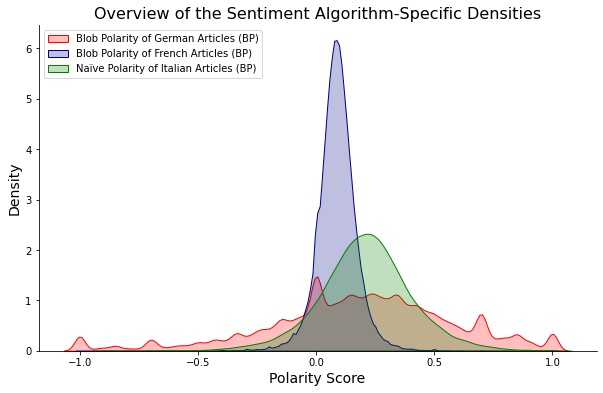

In [14]:
# Plot all language specific densities of the Blob polarity
fig = plt.figure(figsize = (10,6))
ax = sns.kdeplot(articles.loc[articles['language'] == 'de', 'Blob_polarity'], shade = True, color = 'red',   label = "Blob Polarity of German Articles (BP)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'fr', 'Blob_polarity'], shade = True, color = 'navy',  label = "Blob Polarity of French Articles (BP)")
ax = sns.kdeplot(articles.loc[articles['language'] == 'it', 'Blob_polarity'], shade = True, color = 'green', label = "Naïve Polarity of Italian Articles (BP)")
ax.set_title("Overview of the Sentiment Algorithm-Specific Densities")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

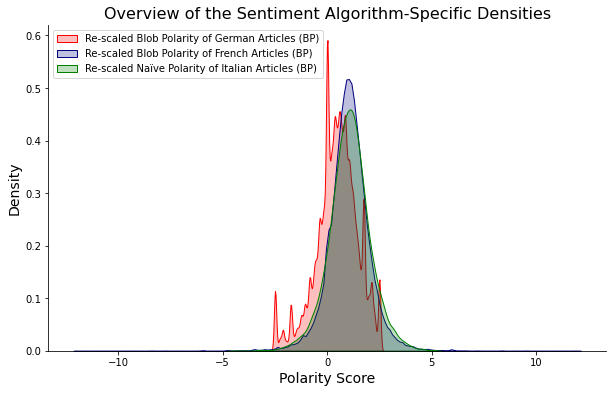

In [15]:
# Plot all language specific densities of the Blob polarity normalized to standard deviation 1
blob_de = articles.loc[articles['language'] == 'de', 'Blob_polarity'].copy()
blob_fr = articles.loc[articles['language'] == 'fr', 'Blob_polarity'].copy()
blob_it = articles.loc[articles['language'] == 'it', 'Blob_polarity'].copy()
blob_de = blob_de / np.std(blob_de)
blob_fr = blob_fr / np.std(blob_fr)
blob_it = blob_it / np.std(blob_it)

fig = plt.figure(figsize = (10,6))
ax = sns.kdeplot(blob_de, shade = True, color = 'red',   label = "Re-scaled Blob Polarity of German Articles (BP)")
ax = sns.kdeplot(blob_fr, shade = True, color = 'navy',  label = "Re-scaled Blob Polarity of French Articles (BP)")
ax = sns.kdeplot(blob_it, shade = True, color = 'green', label = "Re-scaled Naïve Polarity of Italian Articles (BP)")
ax.set_title("Overview of the Sentiment Algorithm-Specific Densities")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

In [16]:
### After appropriately combining the language-specific polarity scores of the VPA, VPAII, and BP into a single variable each, rescale these sentiment measures to have a standard deviation of 1 and store them into the DF
## VPA
# Rescale the polarity scores and store the results in the Vader_polarity_adj_rsc variable
articles['Vader_polarity_adj_rsc'] = articles['Vader_polarity_adj'].copy()/np.std(articles['Vader_polarity_adj'])
## VPAII
# Rescale the polarity scores and store the results in the Vader_polarity_adj_2_rsc variable
articles['Vader_polarity_adj_2_rsc'] = articles['Vader_polarity_adj_2'].copy()/np.std(articles['Vader_polarity_adj_2'])
## BP
# Rescale the language-specific BPs prior to merging them
articles.loc[articles['language'] == 'de', 'Blob_polarity'] = articles.loc[articles['language'] == 'de', 'Blob_polarity'].copy()/np.std(articles.loc[articles['language'] == 'de', 'Blob_polarity'])
articles.loc[articles['language'] == 'fr', 'Blob_polarity'] = articles.loc[articles['language'] == 'fr', 'Blob_polarity'].copy()/np.std(articles.loc[articles['language'] == 'fr', 'Blob_polarity'])
articles.loc[articles['language'] == 'it', 'Blob_polarity'] = articles.loc[articles['language'] == 'it', 'Blob_polarity'].copy()/np.std(articles.loc[articles['language'] == 'it', 'Blob_polarity'])
# Rescale the combined polarity scores again and store the results in the Blob_polarity_rsc variable
articles['Blob_polarity_rsc'] = articles['Blob_polarity'].copy()/np.std(articles['Blob_polarity'])

In [17]:
# Show some summary statistics of the finalized sentiment measures (i.e. the rescaled versions of the VPA, VPAII, and BP)
np.round(articles[['Vader_polarity_adj_rsc','Vader_polarity_adj_2_rsc','Blob_polarity_rsc']].describe(), 3)

Vader_polarity_adj_rsc  Vader_polarity_adj_2_rsc  Blob_polarity_rsc
count             2439096.000               2439096.000        2439096.000
mean                    0.628                     0.466              0.549
std                     1.000                     1.000              1.000
min                    -5.537                    -5.148            -11.594
25%                     0.070                    -0.129              0.000
50%                     0.697                     0.551              0.590
75%                     1.270                     1.126              1.181
max                     5.537                     5.148             11.594

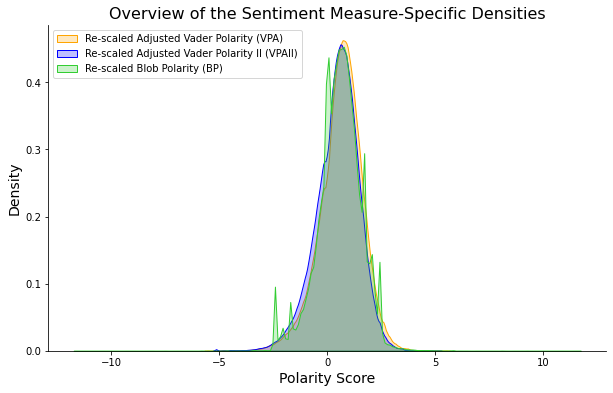

In [18]:
# Plot the distributions of the finalized sentiment measures (i.e. the rescaled versions of the VPA, VPAII, and BP)
fig = plt.figure(figsize = (10,6))
ax = sns.kdeplot(articles['Vader_polarity_adj_rsc'],   shade = True, color = 'orange',   label = "Re-scaled Adjusted Vader Polarity (VPA)")
ax = sns.kdeplot(articles['Vader_polarity_adj_2_rsc'], shade = True, color = 'blue',  label = "Re-scaled Adjusted Vader Polarity II (VPAII)")
ax = sns.kdeplot(articles['Blob_polarity_rsc'],        shade = True, color = 'limegreen', label = "Re-scaled Blob Polarity (BP)")
ax.set_title("Overview of the Sentiment Measure-Specific Densities")
ax.set_xlabel("Polarity Score")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
1.2 Distribution of publications per media channel
</h3>
</div>

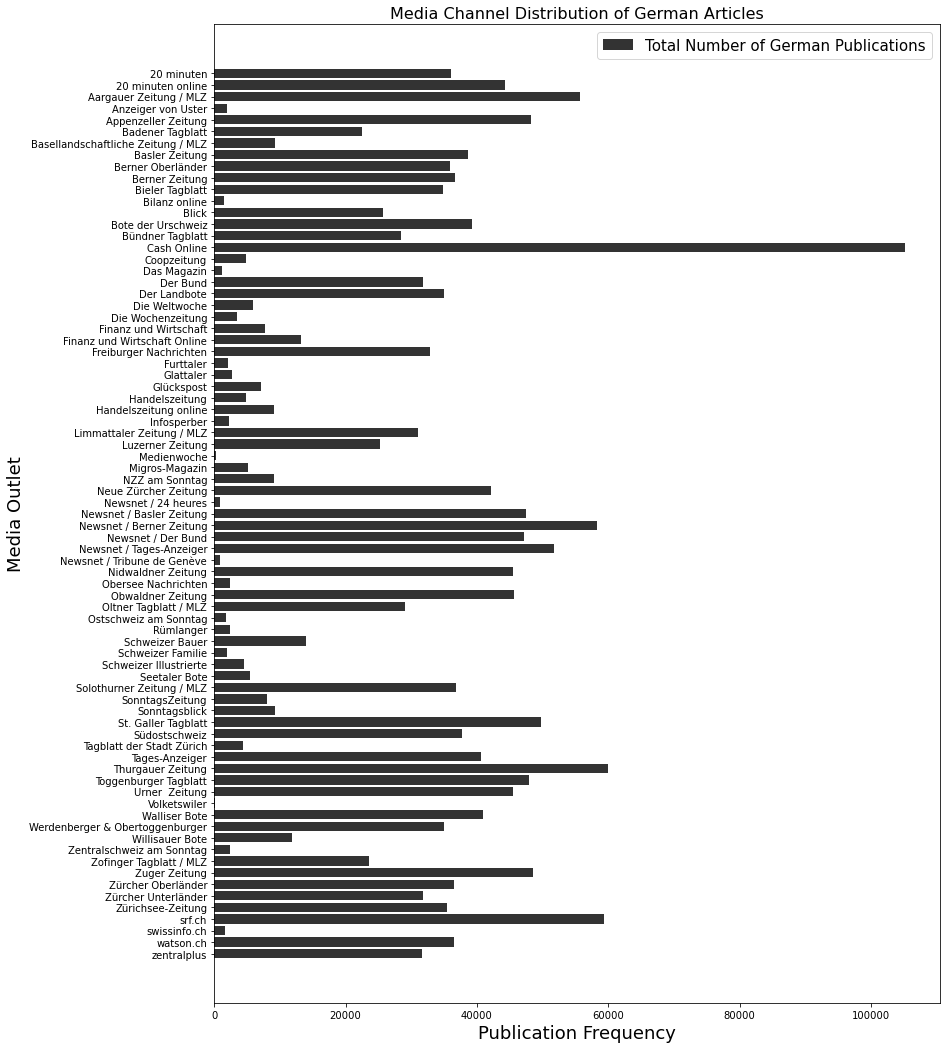

In [19]:
## German
# Apply the above defined function to show the distribution of publications per media channel for the German articles
show_publ_dist_channels(articles, 'de', figsize = (13,18))

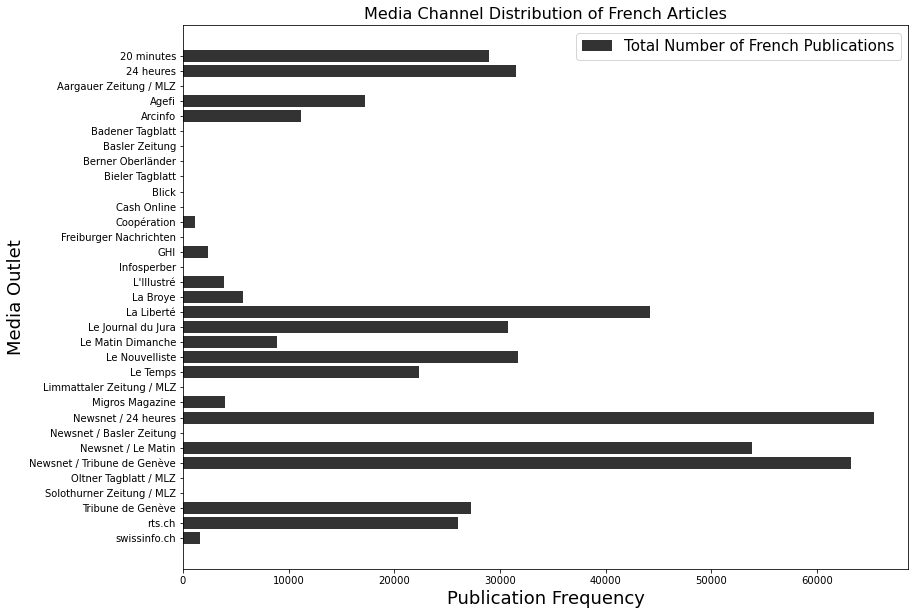

In [20]:
## French
# Apply the above defined function to show the distribution of publications per media channel for the French articles
show_publ_dist_channels(articles, 'fr', figsize = (13,10))

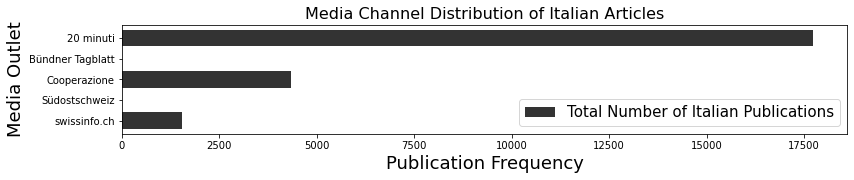

In [21]:
## Italian
# Apply the above defined function to show the distribution of publications per media channel for the Italian articles
show_publ_dist_channels(articles, 'it', figsize = (13,2))

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
1.3 Distribution of publications per topic
</h3>
</div>

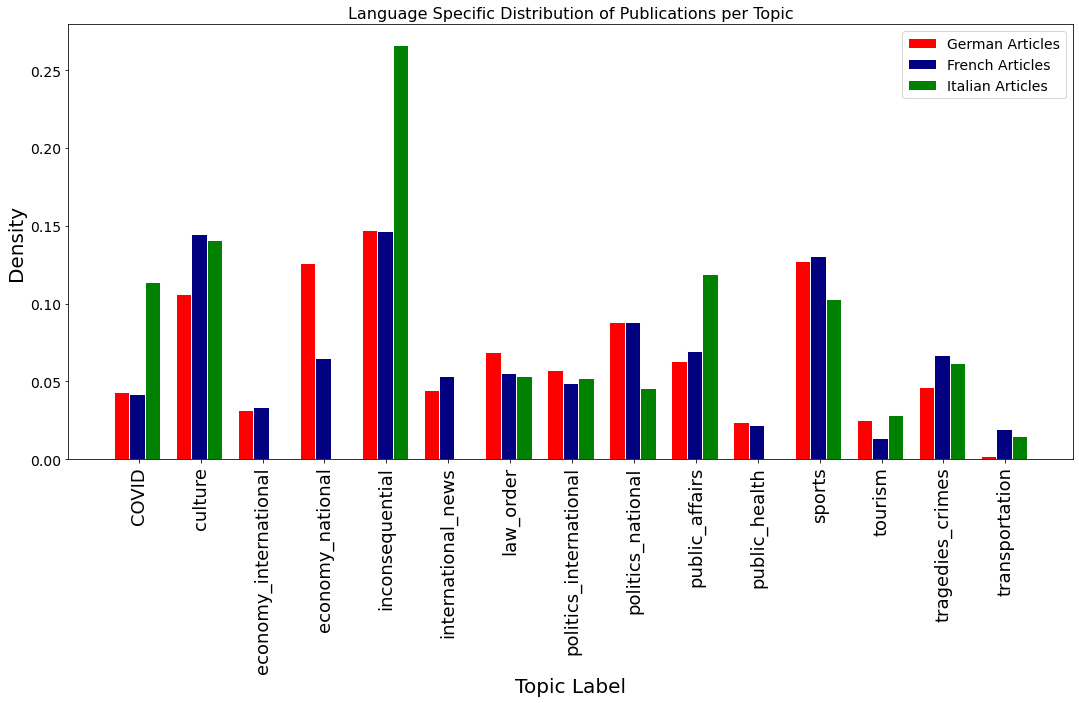

In [22]:
# Apply the above defined function to compare the language specific distribution of publications per topic
show_publ_dist_topics(articles)

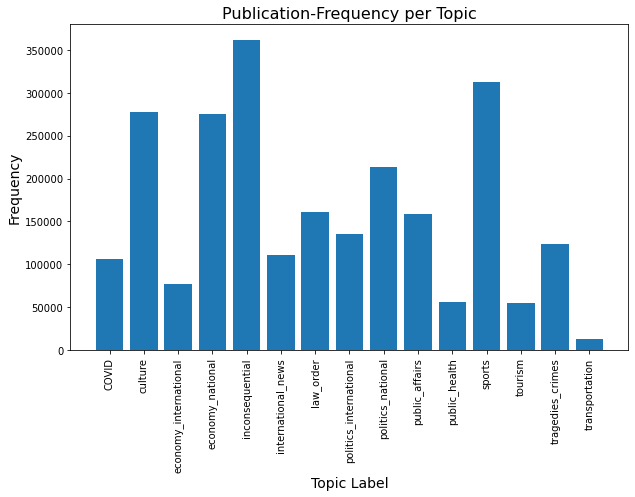

In [23]:
## Overall
# Apply the above defined function to show the overall distribution of publications per topic
show_publ_freq_topics_overall(articles)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
1.4 Development of weekly average polarity over time
</h3>
</div>

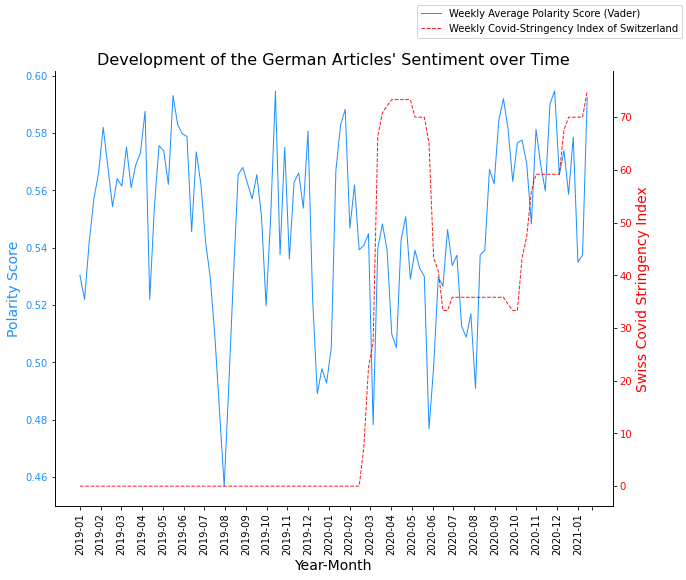

In [24]:
## German (with VP)
# Apply the above defined function to show the development of the German articles' sentiment over time
show_senti_development(articles, 'de', polarity_type = 'Vader_polarity')

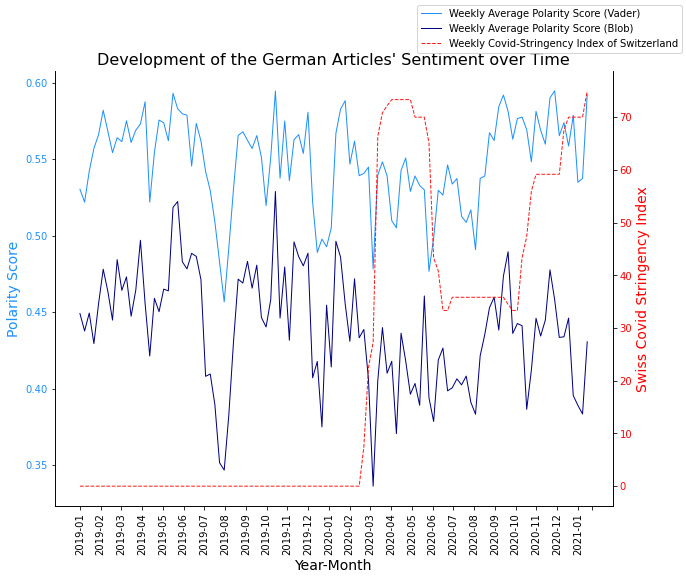

In [25]:
## German (with VP and BP)
# Apply the above defined function to show the development of the German articles' sentiment over time
show_senti_development(articles, 'de', polarity_type = 'Vader_polarity', second_polarity_type = 'Blob_polarity')

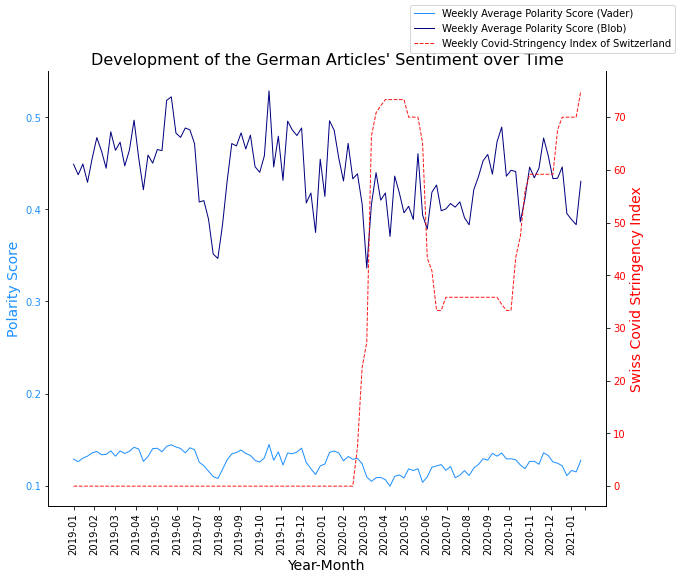

In [26]:
## German (with VPA and BP)
# Apply the above defined function to show the development of the German articles' sentiment over time
show_senti_development(articles, 'de', polarity_type = 'Vader_polarity_adj', second_polarity_type = 'Blob_polarity')

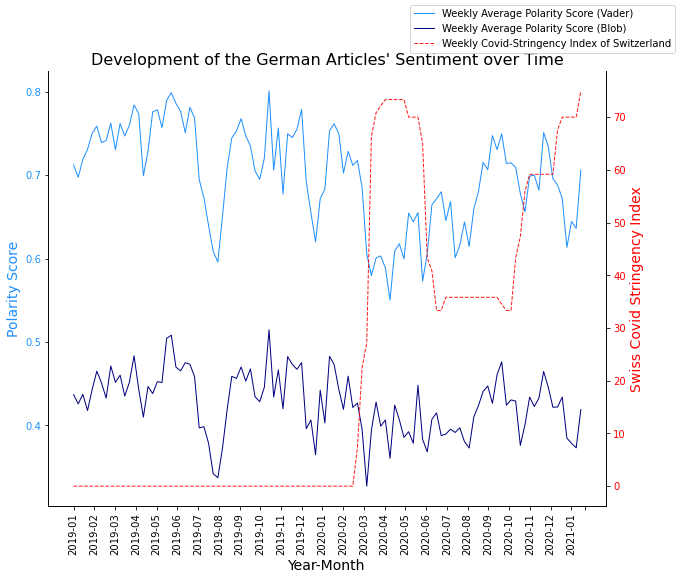

In [27]:
## German (with rescaled VPA and BP)
# Apply the above defined function to show the development of the German articles' sentiment over time
show_senti_development(articles, 'de', polarity_type = 'Vader_polarity_adj_rsc', second_polarity_type = 'Blob_polarity_rsc')

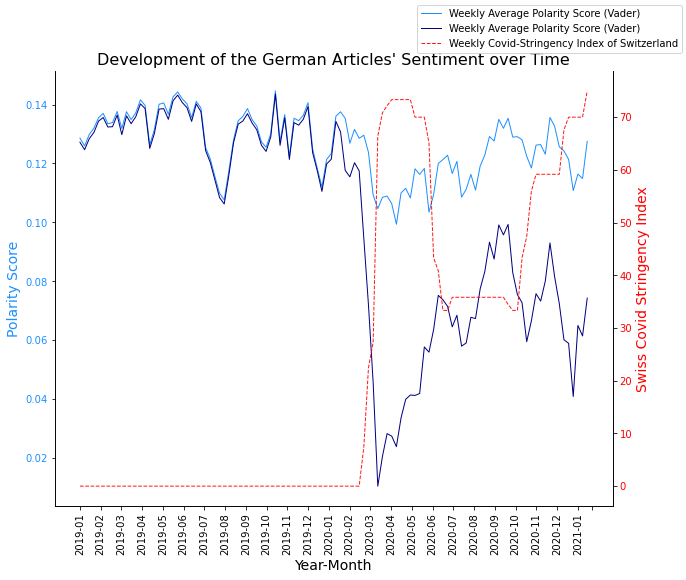

In [28]:
## German (using the VPA and the VPAII)
# Apply the above defined function to show the development of the German articles' sentiment over time
show_senti_development(articles, 'de', polarity_type = 'Vader_polarity_adj', second_polarity_type = 'Vader_polarity_adj_2')

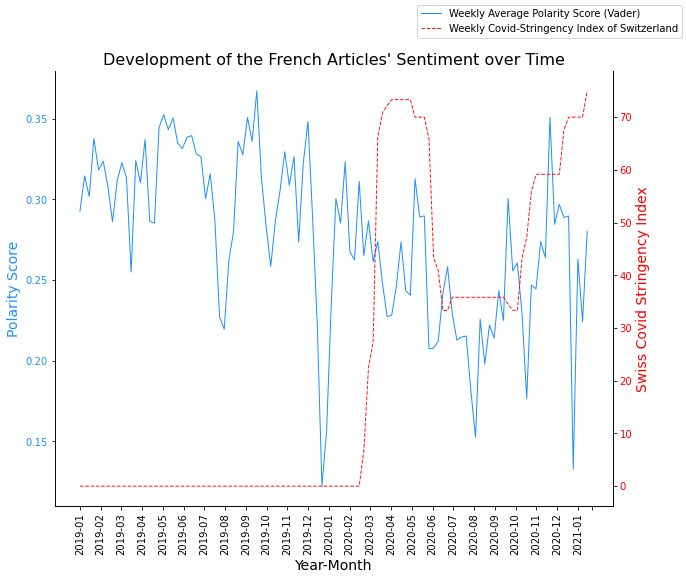

In [29]:
## French (with VP)
# Apply the above defined function to show the development of the French articles' sentiment over time
show_senti_development(articles, 'fr', polarity_type = 'Vader_polarity')

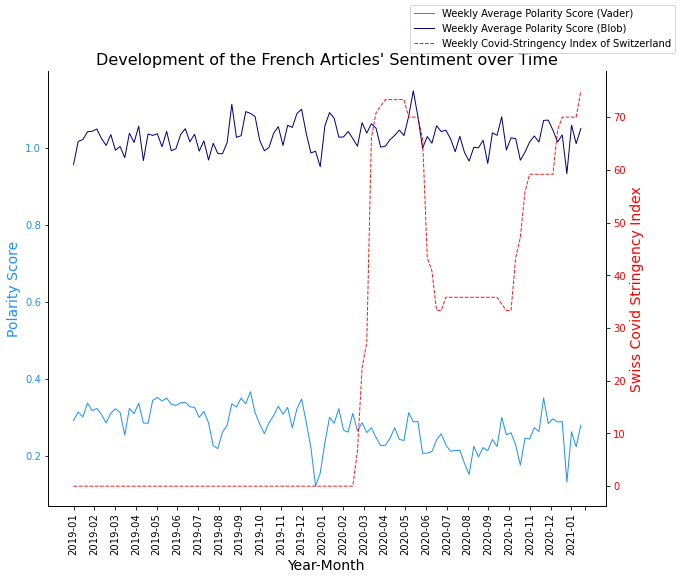

In [30]:
## French (with VP and BP)
# Apply the above defined function to show the development of the French articles' sentiment over time
show_senti_development(articles, 'fr', polarity_type = 'Vader_polarity', second_polarity_type = 'Blob_polarity')

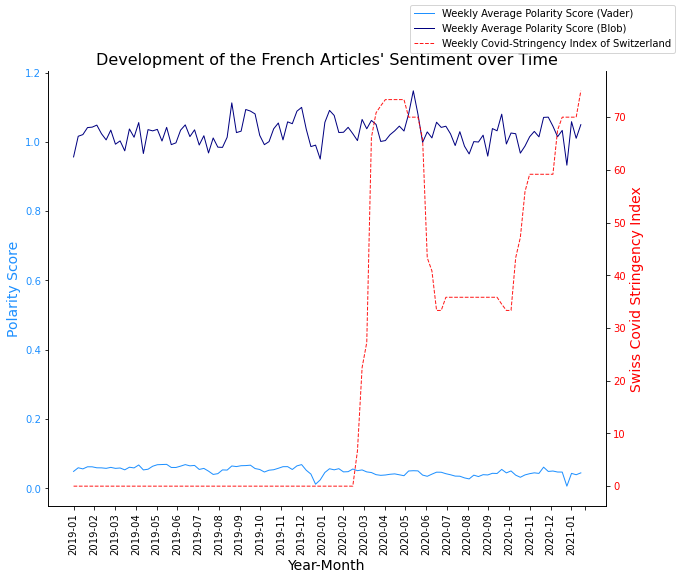

In [31]:
## French (with VPA and TextBlob Polarity)
# Apply the above defined function to show the development of the French articles' sentiment over time
show_senti_development(articles, 'fr', polarity_type = 'Vader_polarity_adj', second_polarity_type = 'Blob_polarity')

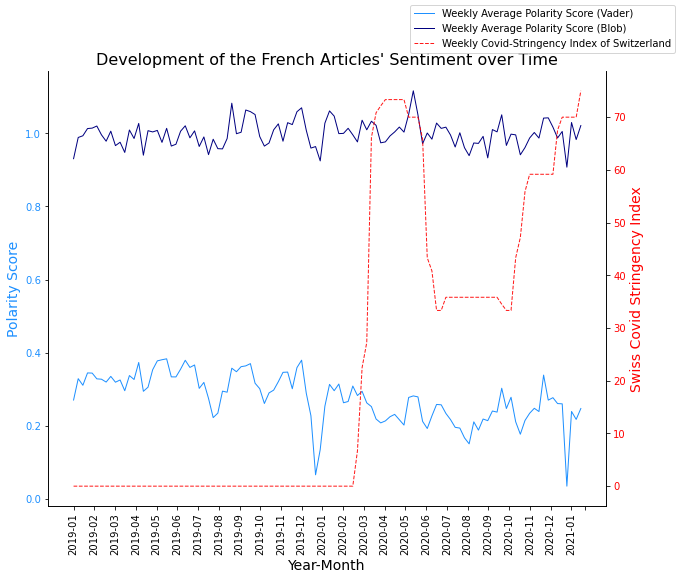

In [32]:
## French (with rescaled VPA and BP)
# Apply the above defined function to show the development of the French articles' sentiment over time
show_senti_development(articles, 'fr', polarity_type = 'Vader_polarity_adj_rsc', second_polarity_type = 'Blob_polarity_rsc')

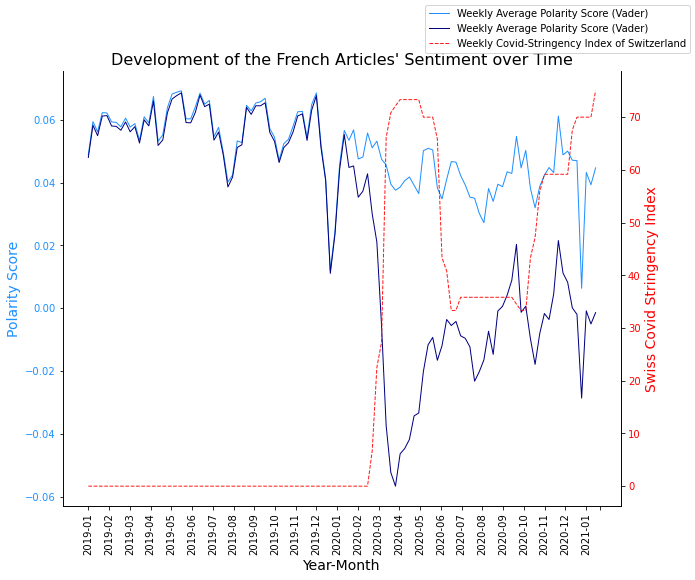

In [33]:
## French (using the VPA and the VPAII)
# Apply the above defined function to show the development of the French articles' sentiment over time
show_senti_development(articles, 'fr', polarity_type = 'Vader_polarity_adj', second_polarity_type = 'Vader_polarity_adj_2')

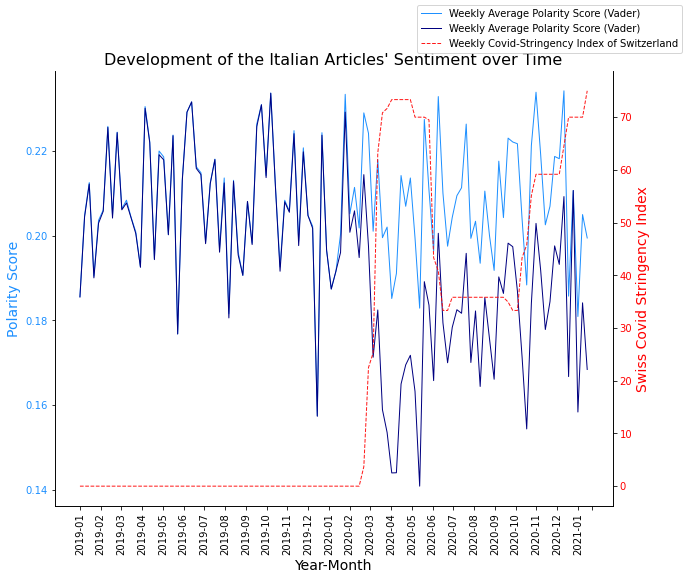

In [34]:
## Italian (using the VPA and the VPAII)
# Apply the above defined function to show the development of the Italian articles' sentiment over time
show_senti_development(articles, 'it', polarity_type = 'Vader_polarity_adj', second_polarity_type = 'Vader_polarity_adj_2')

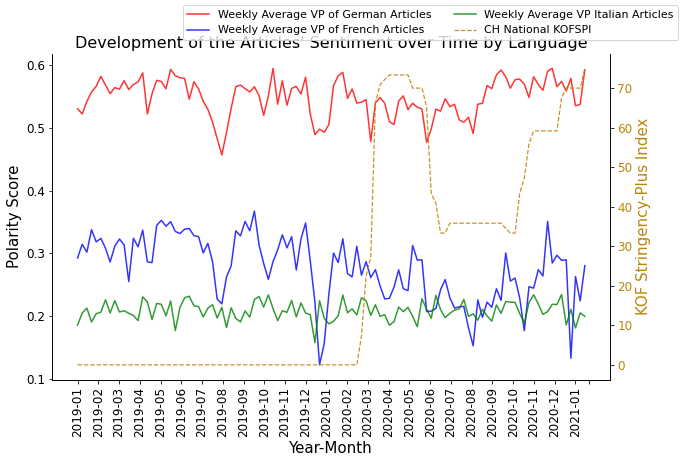

In [35]:
## Overall comparison (with VP)
# Display and compare the language specific development of the articles' sentiment over time
compare_senti_development_across_languages(articles)

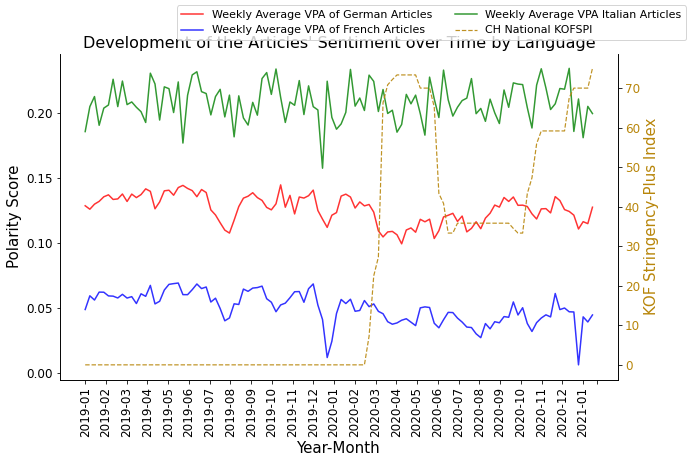

In [36]:
## Overall comparison (with VPA)
# Display and compare the language specific development of the articles' sentiment over time
compare_senti_development_across_languages(articles, polarity_type = 'Vader_polarity_adj', polarity_type_abbreviation = 'VPA')

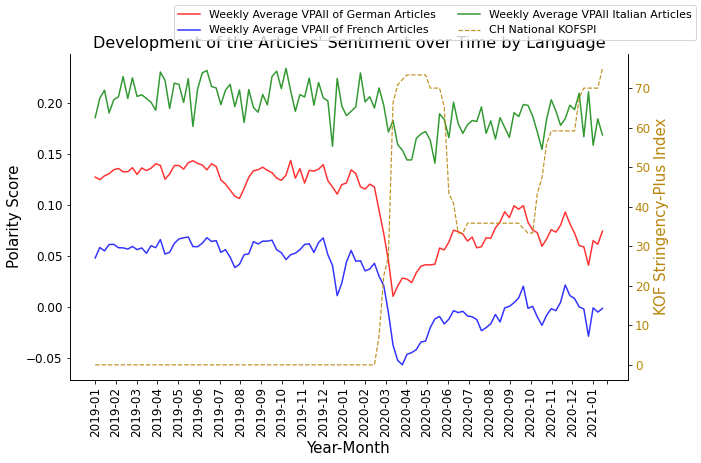

In [37]:
## Overall comparison (with VPAII)
# Display and compare the language specific development of the articles' sentiment over time
compare_senti_development_across_languages(articles, polarity_type = 'Vader_polarity_adj_2', polarity_type_abbreviation = 'VPAII')

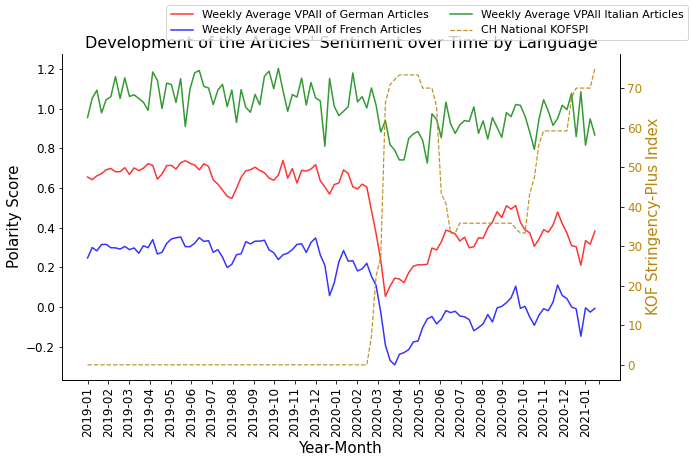

In [38]:
## Overall comparison (with rescaled VPAII)
# Display and compare the language specific development of the articles' sentiment over time
compare_senti_development_across_languages(articles, polarity_type = 'Vader_polarity_adj_2_rsc', polarity_type_abbreviation = 'VPAII')

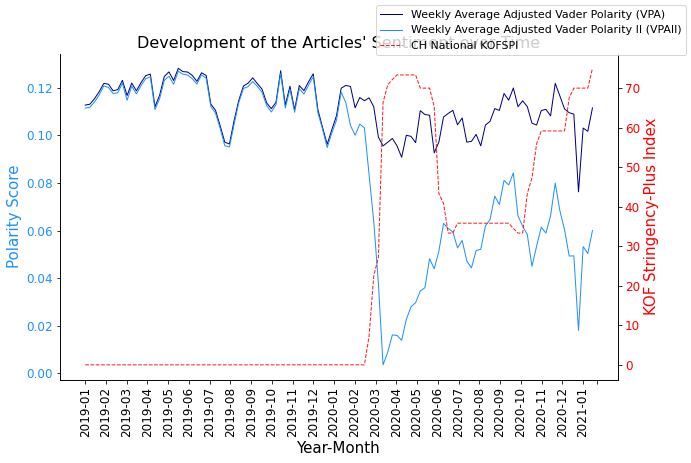

In [39]:
## Show the overall Development of the VPA and VPAII over time
show_senti_development_overall(articles)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
2. Topic specific EDA
</h2>
</div>

In [40]:
## Define all function needed subsequently
# Define a function to compare the topic specific average polarity of the articles per language
def compare_senti_by_topic_across_polarity_type(articles):
    # Get all topics
    topics = np.unique(articles['Topic_fine'])
    # Create an initial dataframe
    init_df = pd.DataFrame(index = topics.tolist())
    # Get the average polarity per Topic for the differenty Vader polarity types
    avg_1 = articles.groupby(['Topic_fine'])['Vader_polarity_adj'].mean()
    avg_2 = articles.groupby(['Topic_fine'])['Vader_polarity_adj_2'].mean()
    # Create a dataframe from these values
    avg_1 = pd.DataFrame(avg_1.values, index = avg_1.index, columns = ['values'])
    avg_2 = pd.DataFrame(avg_2.values, index = avg_2.index, columns = ['values'])
    # Create a dataframe containing the correct values for the visualization
    avg_1 = init_df.merge(avg_1, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    avg_2 = init_df.merge(avg_2, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Plot the topic specific average polarity of the articles per Vader polarity types
    fig = plt.figure(figsize = (18,8))
    # Set the width of the bars
    barwidth = 0.4
    # Set the position of the bars on the X-axis
    r1 = np.arange(len(topics))
    r2 = [x + barwidth for x in r1]
    # Make the plot
    plt.bar(r1, avg_1['values'].values, color = 'gray',     width = barwidth, edgecolor = 'white', label = 'Adjusted Vader Polarity')
    plt.bar(r2, avg_2['values'].values, color = 'seagreen', width = barwidth, edgecolor = 'white', label = 'Adjusted Vader Polarity II')
    plt.vlines((r1+r2)/2, -0.26, 0, colors = 'black', linestyles = 'dotted', alpha = 0.4)
    # Add ticks
    plt.xlabel('Topic Label', fontsize = 20)
    plt.xticks((r1+r2)/2, avg_1.index.to_list(), rotation = 'vertical', fontsize = 18)
    plt.xticks()
    plt.ylabel('Average Polarity Score', fontsize = 20)
    plt.tick_params(axis = 'y', labelsize = 16)
    # Add title
    plt.title('Average Polarity by Topic')
    # Create legend & Show graphic
    plt.legend(fontsize = 16)
    plt.show()


# Define a function to compare the topic specific average polarity of the articles per language
def compare_senti_by_topic_across_language(articles, polarity_type = 'Vader_polarity_adj'):
    # Get all topics
    topics = np.unique(articles['Topic_1'])
    # Create an initial dataframe
    init_df = pd.DataFrame(index = topics.tolist())
    # Get the average polarity per Topic for the language specific articles
    avg_de = articles.loc[articles['language'] == 'de'].groupby(['Topic_1'])[polarity_type].mean()
    avg_fr = articles.loc[articles['language'] == 'fr'].groupby(['Topic_1'])[polarity_type].mean()
    avg_it = articles.loc[articles['language'] == 'it'].groupby(['Topic_1'])[polarity_type].mean()
    # Create a dataframe from these values
    avg_de = pd.DataFrame(avg_de.values, index = avg_de.index, columns = ['values'])
    avg_fr = pd.DataFrame(avg_fr.values, index = avg_fr.index, columns = ['values'])
    avg_it = pd.DataFrame(avg_it.values, index = avg_it.index, columns = ['values'])
    # Create a dataframe containing the correct values for the visualization
    avg_de = init_df.merge(avg_de, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    avg_fr = init_df.merge(avg_fr, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    avg_it = init_df.merge(avg_it, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Plot the topic specific average polarity of the articles per language
    fig = plt.figure(figsize = (18,8))
    # Set the width of the bars
    barwidth = 0.25
    # Set the position of the bars on the X-axis
    r1 = np.arange(len(topics))
    r2 = [x + barwidth for x in r1]
    r3 = [x + barwidth for x in r2]
    # Make the plot
    plt.bar(r1, avg_de['values'].values, color = 'red',   width = barwidth, edgecolor = 'white', label = 'German Articles')
    plt.bar(r2, avg_fr['values'].values, color = 'navy',  width = barwidth, edgecolor = 'white', label = 'French Articles')
    plt.bar(r3, avg_it['values'].values, color = 'green', width = barwidth, edgecolor = 'white', label = 'Italian Articles')
    # Add ticks
    plt.xlabel('Topic Label')
    plt.xticks([r + 1.1*barwidth for r in range(len(topics))], avg_de.index.to_list(), rotation = 'vertical')
    plt.ylabel('Language-conditional average Polarity Score')
    # Add title
    plt.title('Language Specific Average Polarity by Topic')
    # Create legend & Show graphic
    plt.legend()
    plt.show()


# Define a function to display the topic specific development of the articles' average sentiment over time
def show_senti_development(articles, topic, topic_fulltext, polarity_type = 'Vader_polarity', weekly_mincount = 0, threshold_1 = 0, consider_topic_2 = False, threshold_2 = 0.25):
    # Get a list of boolean values indicating the selected articles
    selection = np.logical_and(articles['Topic_1'] == topic, articles['Affiliation_Prob_1'] >= threshold_1)
    if consider_topic_2:
        selection = np.logical_or(selection, np.logical_and(articles['Topic_2'] == topic, articles['Affiliation_Prob_2'] >= threshold_2))
    # Extract the considered time frame
    date_min = articles.loc[selection, 'publication_date'].min()
    date_max = articles.loc[selection, 'publication_date'].max()

    # Get the average polarity scores for each year_week combination among the considered topic specific articles
    polarity_by_week = articles.loc[selection].groupby('year_week')[polarity_type].mean()
    # Get the number of published articles for each year_week combination among the considered topic specific articles
    counts_by_week   = articles.loc[selection].groupby('year_week')[polarity_type].count()
    # Create a dataframe containing the correct x and y coordinates to create the graph below
    polarity_by_week = pd.DataFrame(polarity_by_week.values, index = polarity_by_week.index, columns = ['values'])
    polarity_by_week['counts'] = counts_by_week.values
    polarity_by_week = pd.DataFrame(index = np.unique(articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max), 'year_week'])).merge(
                                    polarity_by_week, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    polarity_by_week['x'] = np.arange(polarity_by_week.shape[0])
    polarity_by_week.dropna(inplace = True)
    # Filtering according to the chosen parameters
    polarity_by_week = polarity_by_week.loc[polarity_by_week['counts'] >= weekly_mincount]

    # Adjust the selection variable to the remaining timeframe
    selection = np.logical_and(selection, np.logical_and(articles['year_week'] >= polarity_by_week.index.min(), articles['year_week'] <= polarity_by_week.index.max()))

    # Get the average Swiss Stringency Index for each year_week combination of the language specific articles
    ch_stringency_by_week = articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max)].groupby('year_week')['ch_stridx'].mean()
    # Create a dataframe containing the correct x and y coordinates to create the graph below
    ch_stringency_by_week = pd.DataFrame(ch_stringency_by_week.values, index = ch_stringency_by_week.index, columns = ['values']).sort_index()
    ch_stringency_by_week['x'] = np.arange(ch_stringency_by_week.shape[0])
    # Restrict the values to the considered timeframe
    ch_stringency_by_week = ch_stringency_by_week.loc[np.logical_and(ch_stringency_by_week.index >= polarity_by_week.index.min(), ch_stringency_by_week.index <= polarity_by_week.index.max())]

    # Show the development of the weekly average polarity scores of the topic specific articles
    fig, ax1 = plt.subplots(figsize = (10, 8))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels  = np.sort(articles.loc[np.logical_and(articles['year_week'] >= polarity_by_week.index.min(), articles['year_week'] <= polarity_by_week.index.max()), 'year_month'].unique())
    x_pos_min_frac = float(articles.loc[selection, 'publication_date'].min().strftime('%W'))/53*12
    x_pos_min_frac = x_pos_min_frac - int(x_pos_min_frac)
    x_pos_max_frac = float(articles.loc[selection, 'publication_date'].max().strftime('%W'))/53*12
    x_pos_max_frac = x_pos_max_frac - int(x_pos_max_frac)
    if np.logical_not(x_pos_min_frac == 0):
        x_labels = x_labels[1:]
        n_months = len(x_labels) - 1 + (1 - x_pos_min_frac) + x_pos_max_frac
        x_pos_min = polarity_by_week['x'].min() + ((polarity_by_week['x'].max() - polarity_by_week['x'].min())/n_months)*(1 - x_pos_min_frac)
    else:
        n_months = len(x_labels) - 1 + x_pos_max_frac
        x_pos_min = polarity_by_week['x'].min()
    x_pos_max = polarity_by_week['x'].max() - ((polarity_by_week['x'].max() - polarity_by_week['x'].min())/n_months)*x_pos_max_frac
    x_pos = np.linspace(x_pos_min, x_pos_max, len(x_labels))
    # Set up the plot to show the development of the articles' sentiment over time
    ax1.plot(polarity_by_week['x'].values, polarity_by_week['values'].values, color = 'blue', linewidth = 1, alpha = 1, linestyle = 'solid', label = 'Weekly Average Polarity Score')
    ax1.set_title("Development of the "+topic_fulltext+" Articles' average Sentiment over Time")
    ax1.set_xlabel("Year-Month")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax1.set_ylabel("Polarity Score", color = 'blue')
    ax1.tick_params(axis = 'y', labelcolor = 'blue')
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_week['x'].values, ch_stringency_by_week['values'].values, color = 'red', linewidth = 1, alpha = 0.9, linestyle = '--', label = 'Weekly Covid-Stringency Index of Switzerland')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax2.set_ylabel('Swiss Covid Stringency Index', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend()
    plt.show()

# Define a function to display the topic specific development of the weekly publication frequency over time
def show_publ_frequency_development(articles, topic, topic_fulltext, threshold_1 = 0, consider_topic_2 = False, threshold_2 = 0.25):
    # Get a list of boolean values indicating the selected articles
    selection = np.logical_and(articles['Topic_1'] == topic, articles['Affiliation_Prob_1'] >= threshold_1)
    if consider_topic_2:
        selection = np.logical_or(selection, np.logical_and(articles['Topic_2'] == topic, articles['Affiliation_Prob_2'] >= threshold_2))
    # Extract the considered time frame
    date_min = articles.loc[selection, 'publication_date'].min()
    date_max = articles.loc[selection, 'publication_date'].max()

    # Get the number of published articles for each year_week combination among the considered topic specific articles
    counts_by_week   = articles.loc[selection].groupby('year_week')['Topic_1'].count()
    # Create a dataframe containing the correct x and y coordinates to create the graph below
    counts_by_week = pd.DataFrame(counts_by_week.values, index = counts_by_week.index, columns = ['counts'])
    counts_by_week = pd.DataFrame(index = np.unique(articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max), 'year_week'])).merge(
                                    counts_by_week, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    counts_by_week['x'] = np.arange(counts_by_week.shape[0])
    counts_by_week.dropna(inplace = True)

    # Get the average Swiss Stringency Index for each year_week combination of the language specific articles
    ch_stringency_by_week = articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max)].groupby('year_week')['ch_stridx'].mean()
    # Create a dataframe containing the correct x and y coordinates to create the graph below
    ch_stringency_by_week = pd.DataFrame(ch_stringency_by_week.values, index = ch_stringency_by_week.index, columns = ['values']).sort_index()
    ch_stringency_by_week['x'] = np.arange(ch_stringency_by_week.shape[0])
    # Restrict the values to the considered timeframe
    ch_stringency_by_week = ch_stringency_by_week.loc[np.logical_and(ch_stringency_by_week.index >= counts_by_week.index.min(), ch_stringency_by_week.index <= counts_by_week.index.max())]

    # Show the development of the weekly average polarity scores of the topic specific articles
    fig, ax1 = plt.subplots(figsize = (10, 8))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels  = np.sort(articles.loc[np.logical_and(articles['publication_date'] >= date_min, articles['publication_date'] <= date_max), 'year_month'].unique())
    x_pos_min_frac = float(articles.loc[selection, 'publication_date'].min().strftime('%W'))/53*12
    x_pos_min_frac = x_pos_min_frac - int(x_pos_min_frac)
    x_pos_max_frac = float(articles.loc[selection, 'publication_date'].max().strftime('%W'))/53*12
    x_pos_max_frac = x_pos_max_frac - int(x_pos_max_frac)
    if np.logical_not(x_pos_min_frac == 0):
        x_labels = x_labels[1:]
        n_months = len(x_labels) - 1 + (1 - x_pos_min_frac) + x_pos_max_frac
        x_pos_min = counts_by_week['x'].min() + ((counts_by_week['x'].max() - counts_by_week['x'].min())/n_months)*(1 - x_pos_min_frac)
    else:
        n_months = len(x_labels) - 1 + x_pos_max_frac
        x_pos_min = counts_by_week['x'].min()
    x_pos_max = counts_by_week['x'].max() - ((counts_by_week['x'].max() - counts_by_week['x'].min())/n_months)*x_pos_max_frac
    x_pos = np.linspace(x_pos_min, x_pos_max, len(x_labels))
    # Set up the plot to show the development of the frequency of weekly published articles for the topic under consideration
    ax1.plot(counts_by_week['x'].values, counts_by_week['counts'].values, color = 'green', linewidth = 1, alpha = 1, linestyle = 'solid', label = 'Weekly published '+topic_fulltext+' Articles')
    ax1.set_title("Development of the Weekly Frequency of published "+topic_fulltext+" Articles")
    ax1.set_xlabel("Year-Month")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax1.set_ylabel('Weekly Publication Frequency', color = 'green')
    ax1.tick_params(axis = 'y', labelcolor = 'green')
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_week['x'].values, ch_stringency_by_week['values'].values, color = 'red', linewidth = 1, alpha = 0.9, linestyle = '--', label = 'Weekly Covid-Stringency Index of Switzerland')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax2.set_ylabel('Swiss Covid Stringency Index', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.spines['top'].set_visible(False)

    # Create a legend and display the plot
    fig.legend()
    plt.show()

# Define a function to display and compare the topic specific frequency of the monthly published articles
def compare_publ_frequency_development_across_topics_monthly(articles):
    # Get the average polarity scores for each year_week combination of the topic specific articles
    counts_by_month = []
    for topic in np.sort(articles['Topic_1'].unique()):
        counts_by_month.append(articles.loc[articles['Topic_1'] == topic].groupby('year_month')['Topic_1'].count())

    # Get the average Swiss Stringency Index for each year_week combination
    ch_stringency_by_month = articles.groupby('year_month')['ch_stridx'].mean()

    # Show the development of the weekly average polarity scores of the language specific articles
    fig, ax1 = plt.subplots(figsize = (12, 11))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels = np.sort(articles['year_month'].unique())
    x_pos    = np.arange(len(x_labels))
    # Define the color palette to be used
    colors = ['navy','dodgerblue','cyan','teal','lime','green','olive','black','magenta','crimson','darkorange','gold','sienna','lightcoral','grey']
    # Set up the plot to show the development of the articles' sentiment over time
    i = 0
    for topic in np.sort(articles['Topic_1'].unique()):
        ax1.plot(counts_by_month[i].index, counts_by_month[i].values, color = colors[i], linewidth = 1.5, alpha = 0.8, linestyle = 'solid', label = topic)
        i += 1
    ax1.set_title("Development of the Monthly Publication Frequency over Time by Topic")
    ax1.set_xlabel("Year-Month", fontsize = 15)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center', fontsize = 12)
    ax1.set_ylabel("Monthly Publication Frequency", color = 'black', fontsize = 15)
    ax1.tick_params(axis = 'y', labelcolor = 'black', labelsize = 12)
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_month.index, ch_stringency_by_month.values, color = 'red', linewidth = 2, alpha = 1, linestyle = '--', label = 'CH National KOFSPI')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center', fontsize = 12)
    ax2.set_ylabel('KOF Stringency-Plus Index', color = 'red', fontsize = 15)
    ax2.tick_params(axis = 'y', labelcolor = 'red', labelsize = 12)
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend(ncol = 4, fontsize = 11)
    plt.show()


# Define a function to display and compare the topic specific development of the articles' sentiment over time (using weekly averages)
def compare_senti_development_across_topics_weekly(articles, polarity_type = 'Vader_polarity'):
    # Get the average polarity scores for each year_week combination of the topic specific articles
    polarity_by_week = []
    for topic in np.sort(articles['Topic_1'].unique()):
        polarity_by_week.append(articles.loc[articles['Topic_1'] == topic].groupby('year_week')[polarity_type].mean())

    # Get the average Swiss Stringency Index for each year_week combination
    ch_stringency_by_week = articles.groupby('year_week')['ch_stridx'].mean()

    # Show the development of the weekly average polarity scores of the language specific articles
    fig, ax1 = plt.subplots(figsize = (12, 11))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels = np.sort(articles['year_month'].unique())
    x_pos    = np.arange(len(x_labels))
    x_labels = np.append(x_labels, '')
    x_pos    = np.append(x_pos, max(x_pos) + float(articles['publication_date'].max().strftime('%W'))/53*12)
    x_pos    = x_pos*(len(ch_stringency_by_week.index)/max(x_pos))
    # Define the color palette to be used
    colors = ['navy','dodgerblue','cyan','teal','lime','green','olive','black','magenta','crimson','darkorange','gold','sienna','lightcoral','grey']
    # Set up the plot to show the development of the articles' sentiment over time
    i = 0
    for topic in np.sort(articles['Topic_1'].unique()):
        ax1.plot(polarity_by_week[i].index, polarity_by_week[i].values, color = colors[i], linewidth = 1.5, alpha = 0.8, linestyle = 'solid', label = topic)
        i += 1
    ax1.set_title("Development of the Articles' average Sentiment over Time by Topic")
    ax1.set_xlabel("Year-Month")
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax1.set_ylabel("Polarity Score", color = 'black')
    ax1.tick_params(axis = 'y', labelcolor = 'black')
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_week.index, ch_stringency_by_week.values, color = 'red', linewidth = 2, alpha = 1, linestyle = '--', label = 'CH National KOFSPI')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center')
    ax2.set_ylabel('KOF Stringency-Plus Index', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend(ncol = 4)
    plt.show()

# Define a function to display and compare the topic specific development of the articles' sentiment over time (using monthly averages)
def compare_senti_development_across_topics_monthly(articles, polarity_type = 'Vader_polarity', y_label = 'Polarity Score', min_monthly_publication_share = 0):
    # Get the average polarity scores for each year_week combination of the topic specific articles together with an indication of the share of publications from that topic that are published in that month
    polarity_by_month = articles.groupby(['Topic_1', 'year_month'])[polarity_type].mean().reset_index()
    counts_by_month   = articles.groupby(['Topic_1', 'year_month'])[polarity_type].count().reset_index().rename(columns = {polarity_type: 'monthly_count'})
    count_by_topic    = articles.groupby(['Topic_1'])[polarity_type].count().reset_index().rename(columns = {polarity_type: 'total_count'})
    polarity_by_month = polarity_by_month.merge(counts_by_month, how = 'left', left_on = ['Topic_1', 'year_month'], right_on = ['Topic_1', 'year_month'], sort = True, validate = "1:1")
    polarity_by_month = polarity_by_month.merge(count_by_topic,  how = 'left', left_on = 'Topic_1', right_on = 'Topic_1', sort = True, validate = "m:1")
    polarity_by_month['monthly_publication_share'] = polarity_by_month['monthly_count'].copy()/polarity_by_month['total_count'].copy()
    polarity_by_month['year_month_id'] = np.nan
    i = 0
    for mon in np.unique(polarity_by_month['year_month']):
        polarity_by_month.loc[polarity_by_month['year_month'] == mon, 'year_month_id'] = i
        i = i + 1
    # Filter the created dataframe according to the determined minimum monthly publication share
    selection = polarity_by_month['monthly_publication_share'] > min_monthly_publication_share
    polarity_by_month = polarity_by_month.loc[selection]

    # Get the average Swiss Stringency Index for each year_week combination
    ch_stringency_by_month = articles.groupby('year_month')['ch_stridx'].mean().reset_index()

    # Show the development of the weekly average polarity scores of the language specific articles
    fig, ax1 = plt.subplots(figsize = (12, 11))
    # Get readable labels and the according axis-ticks for the x-axis
    x_labels = np.sort(articles['year_month'].unique())
    x_pos    = np.arange(len(x_labels))
    # Define the color palette to be used
    colors = ['navy','dodgerblue','cyan','teal','lime','green','olive','black','magenta','crimson','darkorange','gold','sienna','lightcoral','grey']
    # Set up the plot to show the development of the articles' sentiment over time
    i = 0
    for topic in np.sort(articles['Topic_1'].unique()):
        selection = polarity_by_month['Topic_1'] == topic
        ax1.plot(polarity_by_month.loc[selection, 'year_month_id'], polarity_by_month.loc[selection, polarity_type], color = colors[i], linewidth = 1.5, alpha = 0.8, linestyle = 'solid', label = topic)
        i += 1
    ax1.set_title("Development of the Articles' average Sentiment over Time by Topic")
    ax1.set_xlabel("Year-Month", fontsize = 15)
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(x_labels, rotation = 90, ha = 'center', fontsize = 12)
    ax1.set_ylabel(y_label, color = 'black', fontsize = 15)
    ax1.tick_params(axis = 'y', labelcolor = 'black', labelsize = 12)
    ax1.spines['top'].set_visible(False)
    # Set up the plot to show the development of the Swiss National Covid-Stringency Index over time
    ax2 = ax1.twinx()
    ax2.plot(ch_stringency_by_month['year_month'], ch_stringency_by_month['ch_stridx'], color = 'red', linewidth = 2, alpha = 1, linestyle = '--', label = 'CH National KOFSPI')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation = 90, ha = 'center', fontsize = 12)
    ax2.set_ylabel('KOF Stringency-Plus Index', color = 'red', fontsize = 15)
    ax2.tick_params(axis = 'y', labelcolor = 'red', labelsize = 12)
    ax2.spines['top'].set_visible(False)
    # Create a legend and display the plot
    fig.legend(ncol = 4, fontsize = 11)
    plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.1 Topic affiliation probability by topic
</h3>
</div>

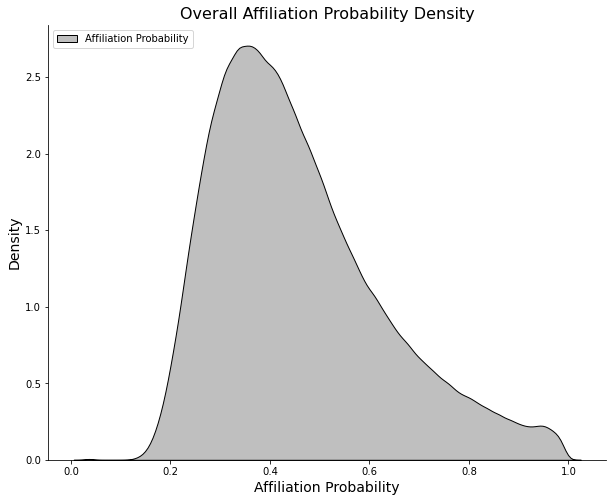

In [41]:
# Plot the overall density of the topic affiliation probability for the most likely topics
fig = plt.figure(figsize = (10,8))
ax = sns.kdeplot(articles['Affiliation_Prob_1'], shade = True, color = 'black',   label = "Affiliation Probability")
ax.set_title("Overall Affiliation Probability Density")
ax.set_xlabel("Affiliation Probability")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'upper left')
plt.show()

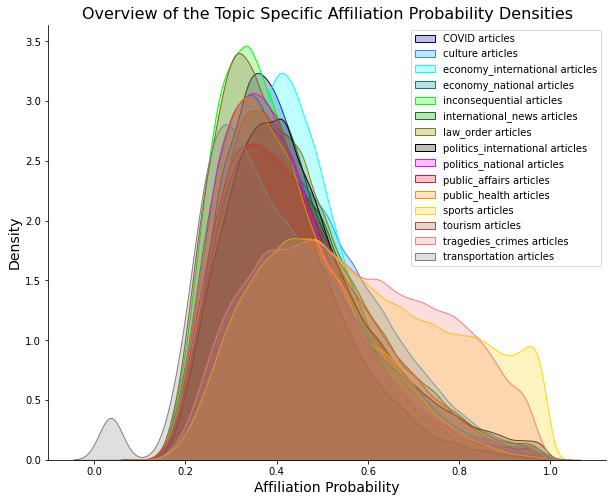

In [42]:
# Plot the topic specific densities of the topic affiliation probability for the most likely topics
colors = ['navy','dodgerblue','cyan','teal','lime','green','olive','black','magenta','crimson','darkorange','gold','sienna','lightcoral','grey']
topics = np.unique(articles['Topic_1'])
fig = plt.figure(figsize = (10,8))
for i in range(len(topics)):
    ax = sns.kdeplot(articles.loc[articles['Topic_1'] == topics[i], 'Affiliation_Prob_1'], shade = True, color = colors[i], label = topics[i]+" articles")
ax.set_title("Overview of the Topic Specific Affiliation Probability Densities")
ax.set_xlabel("Affiliation Probability")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc = 'best')
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.2 Average polarity by topic
</h3>
</div>

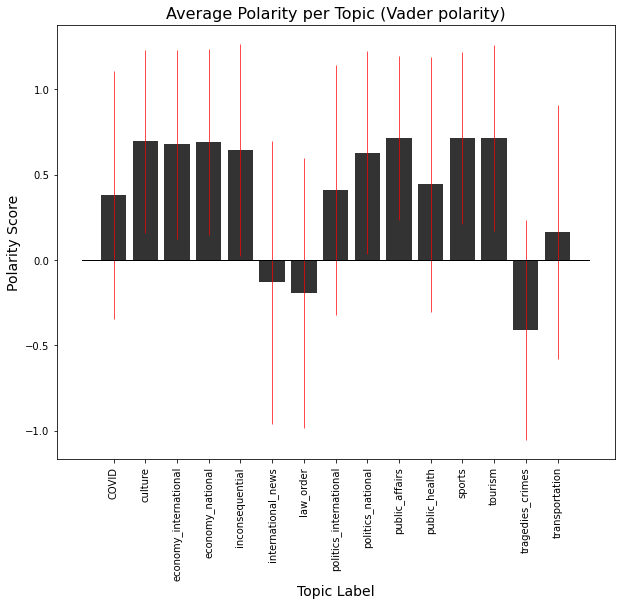

In [43]:
## Display the average Vader polarity per topic together with the standard deviation (with VP)
# Get the average Vader polarity per topic
avg_pol_by_topic = articles.groupby('Topic_1')['Vader_polarity'].mean()
std_pol_by_topic  = articles.groupby('Topic_1')['Vader_polarity'].std()
# Plot the average Vader polarity per topic
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(avg_pol_by_topic.index))
ax.bar(x_pos, avg_pol_by_topic.values, yerr = std_pol_by_topic.values, align = 'center', color = 'black', alpha = 0.8, ecolor = 'red', error_kw = {'lw': 0.7})
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
ax.set_xticks(x_pos)
ax.set_xticklabels(avg_pol_by_topic.index, rotation = 90, ha = 'center')
ax.set_title('Average Polarity per Topic (Vader polarity)')
ax.set_xlabel('Topic Label')
ax.set_ylabel('Polarity Score')
# Display the plot
plt.show()

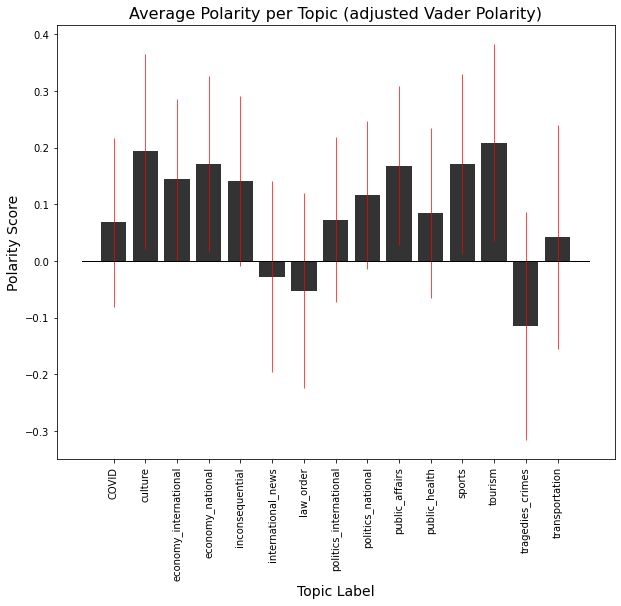

In [44]:
## Display the average Vader polarity per topic together with the standard deviation (with VPA)
# Get the average Vader polarity per topic
avg_pol_by_topic = articles.groupby('Topic_1')['Vader_polarity_adj'].mean()
std_pol_by_topic  = articles.groupby('Topic_1')['Vader_polarity_adj'].std()
# Plot the average Vader polarity per topic
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(avg_pol_by_topic.index))
ax.bar(x_pos, avg_pol_by_topic.values, yerr = std_pol_by_topic.values, align = 'center', color = 'black', alpha = 0.8, ecolor = 'red', error_kw = {'lw': 0.7})
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
ax.set_xticks(x_pos)
ax.set_xticklabels(avg_pol_by_topic.index, rotation = 90, ha = 'center')
ax.set_title('Average Polarity per Topic (adjusted Vader Polarity)')
ax.set_xlabel('Topic Label')
ax.set_ylabel('Polarity Score')
# Display the plot
plt.show()

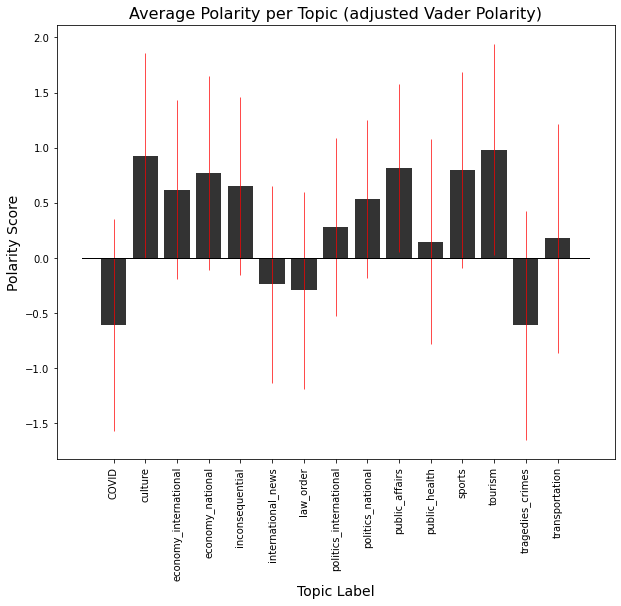

In [45]:
## Display the average Vader polarity per topic together with the standard deviation (with rescaled VPAII)
# Get the average Vader polarity per topic
avg_pol_by_topic = articles.groupby('Topic_1')['Vader_polarity_adj_2_rsc'].mean()
std_pol_by_topic  = articles.groupby('Topic_1')['Vader_polarity_adj_2_rsc'].std()
# Plot the average Vader polarity per topic
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(avg_pol_by_topic.index))
ax.bar(x_pos, avg_pol_by_topic.values, yerr = std_pol_by_topic.values, align = 'center', color = 'black', alpha = 0.8, ecolor = 'red', error_kw = {'lw': 0.7})
ax.plot([min(x_pos)-1,max(x_pos)+1], [0,0], color = 'black', linewidth = 1)
ax.set_xticks(x_pos)
ax.set_xticklabels(avg_pol_by_topic.index, rotation = 90, ha = 'center')
ax.set_title('Average Polarity per Topic (rescaled adjusted Vader Polarity 2)')
ax.set_xlabel('Topic Label')
ax.set_ylabel('Polarity Score')
# Display the plot
plt.show()

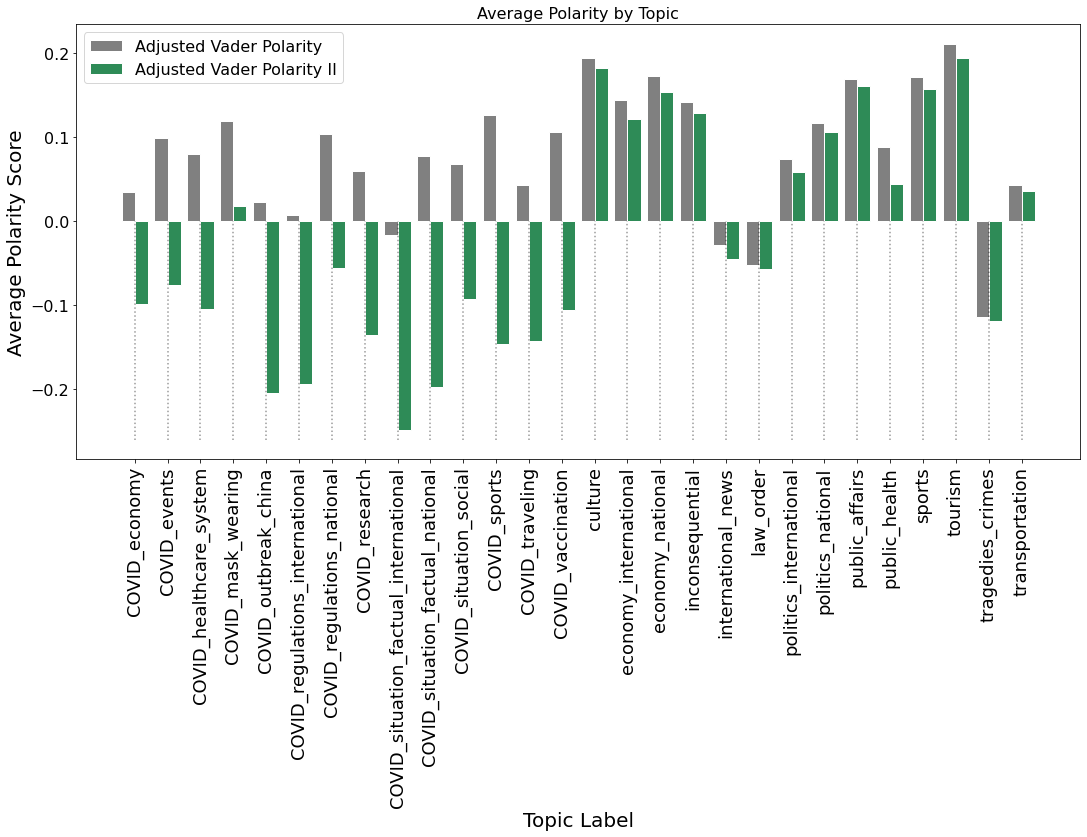

In [46]:
# Apply the above defined function to compare the topic specific average polarity of the articles among the different adjusted Vader polarity types
compare_senti_by_topic_across_polarity_type(articles)

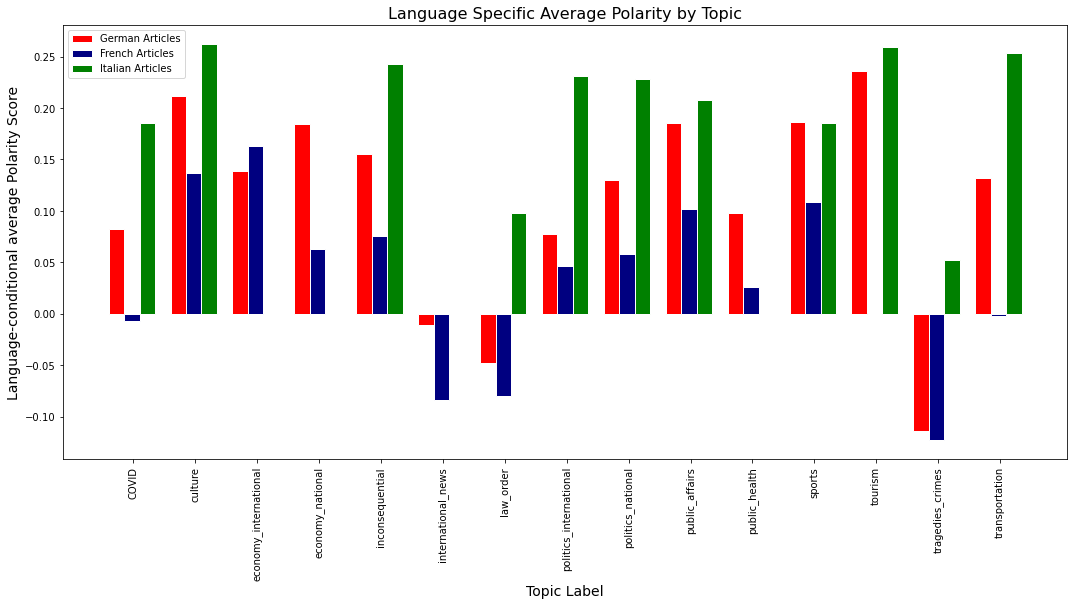

In [47]:
# Apply the above defined function to compare the topic specific average polarity of the articles per language (with VPA)
compare_senti_by_topic_across_language(articles, polarity_type = 'Vader_polarity_adj')

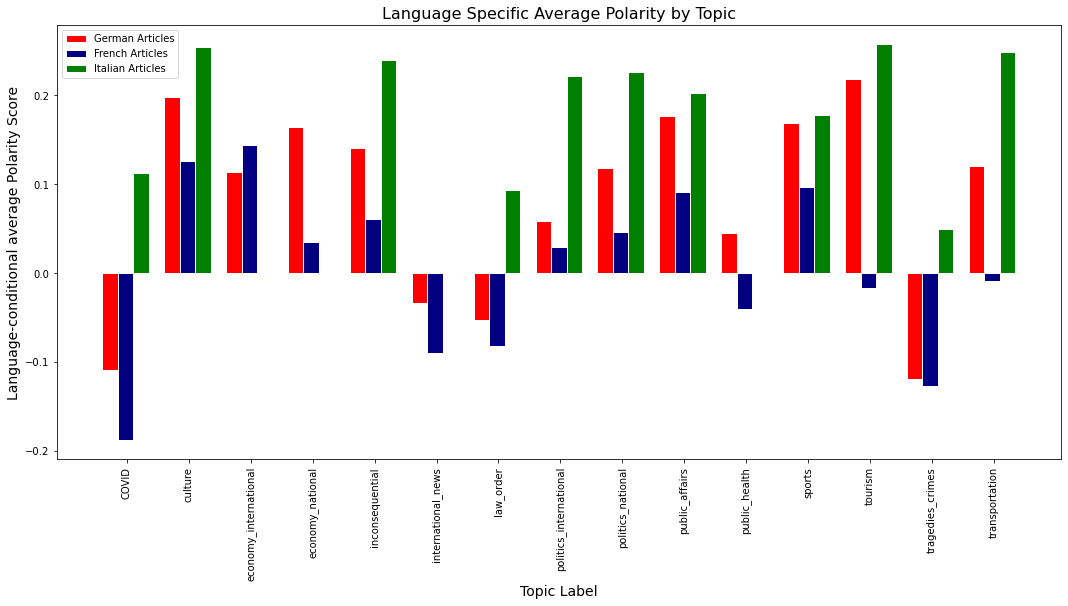

In [48]:
# Apply the above defined function to compare the topic specific average polarity of the articles per language (with VPAII)
compare_senti_by_topic_across_language(articles, polarity_type = 'Vader_polarity_adj_2')

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.3 Development of the polarity over time (using VPAII)
</h3>
</div>

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.3.1 COVID
</h3>
</div>

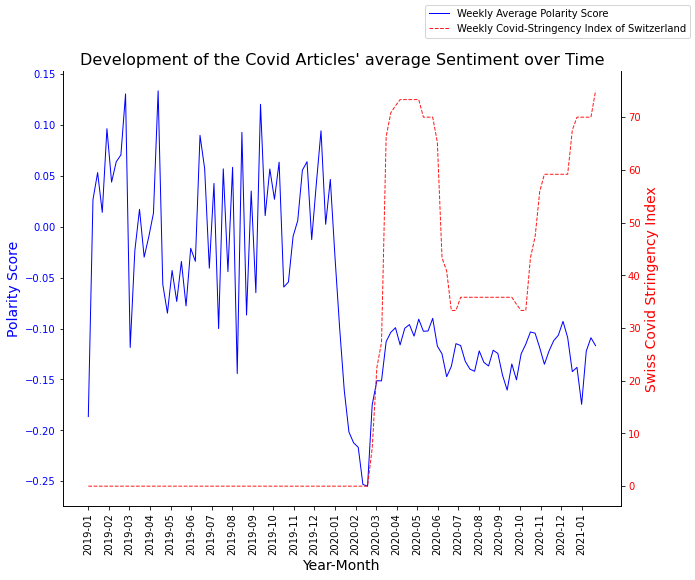

In [49]:
# COVID
show_senti_development(articles, 'COVID', 'Covid', polarity_type = "Vader_polarity_adj_2")

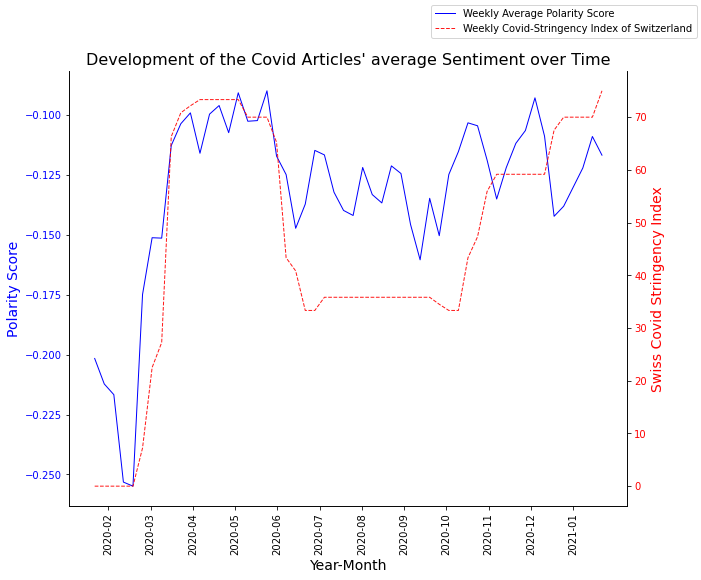

In [50]:
# COVID (only weeks with >= 200 published covid articles are considered)
show_senti_development(articles, 'COVID', 'Covid', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 200)

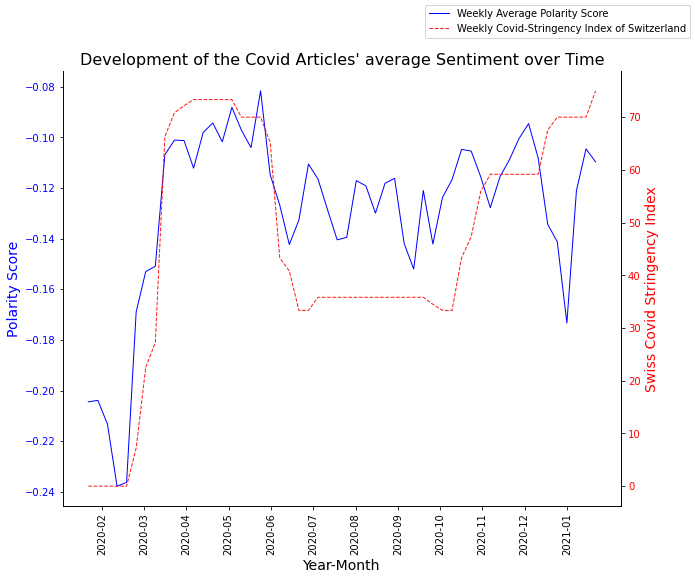

In [51]:
# COVID (also articles which have COVID as the second most likely topic with an affiliation probability of >= 0.25 are considered, but only weeks with >= 200 published covid articles are considered)
show_senti_development(articles, 'COVID', 'Covid', polarity_type = "Vader_polarity_adj_2", weekly_mincount = 200, threshold_1 = 0, consider_topic_2 = True, threshold_2 = 0.25)

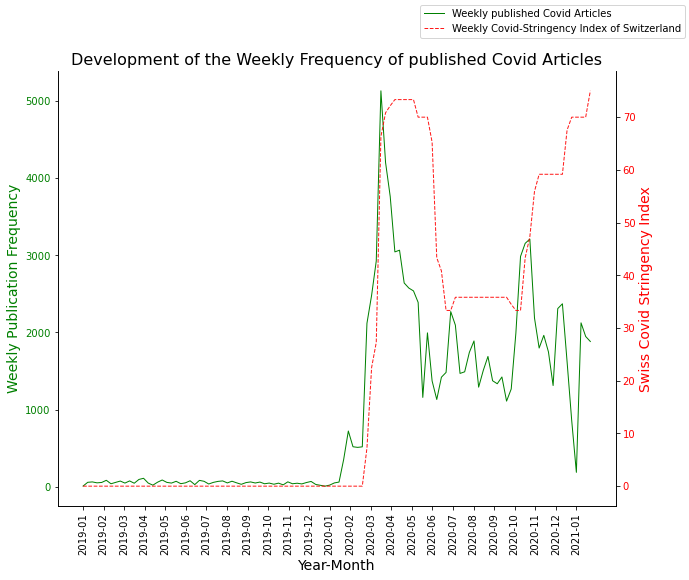

In [52]:
# COVID articles frequency
show_publ_frequency_development(articles, 'COVID', 'Covid')

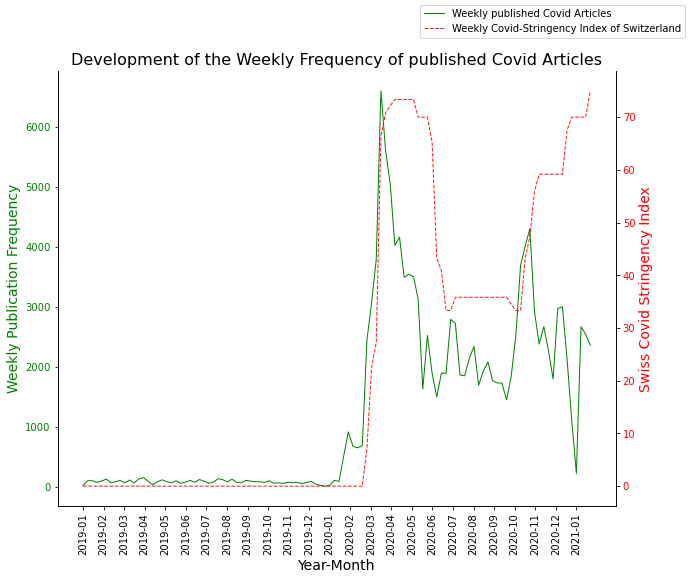

In [53]:
# COVID articles frequency (also articles which have COVID as the second most likely topic with an affiliation probability of >= 0.25 are considered)
show_publ_frequency_development(articles, 'COVID', 'Covid', threshold_1 = 0, consider_topic_2 = True, threshold_2 = 0.25)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
2.3.2 Other Topics
</h3>
</div>

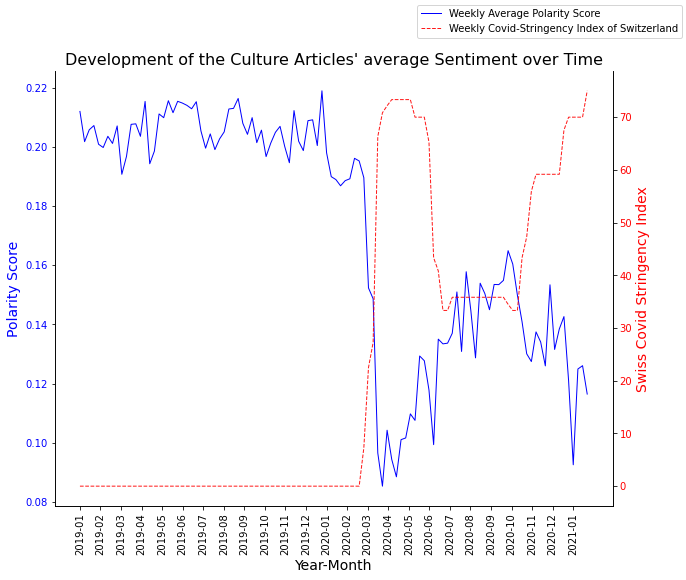

In [54]:
# culture
show_senti_development(articles, 'culture', 'Culture', polarity_type = "Vader_polarity_adj_2")

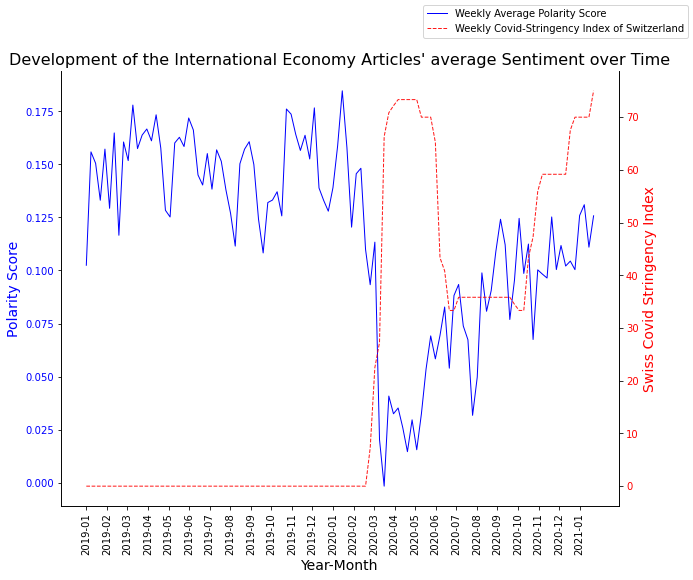

In [55]:
# economy international
show_senti_development(articles, 'economy_international', 'International Economy', polarity_type = "Vader_polarity_adj_2")

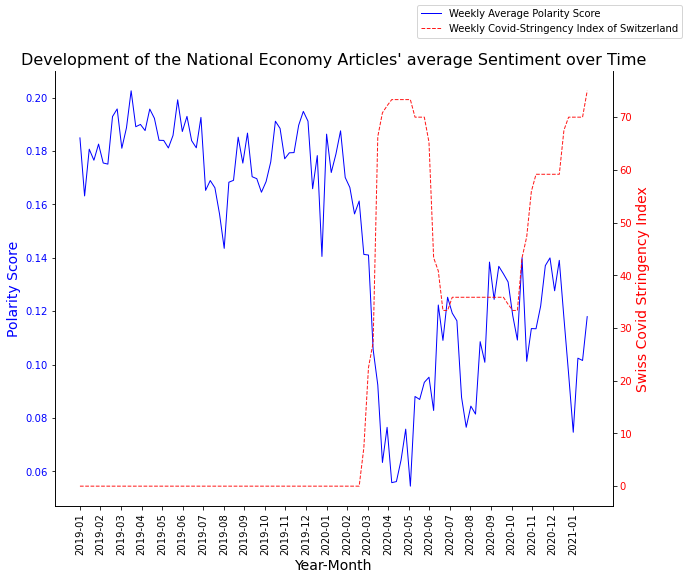

In [56]:
# economy national
show_senti_development(articles, 'economy_national', 'National Economy', polarity_type = "Vader_polarity_adj_2")

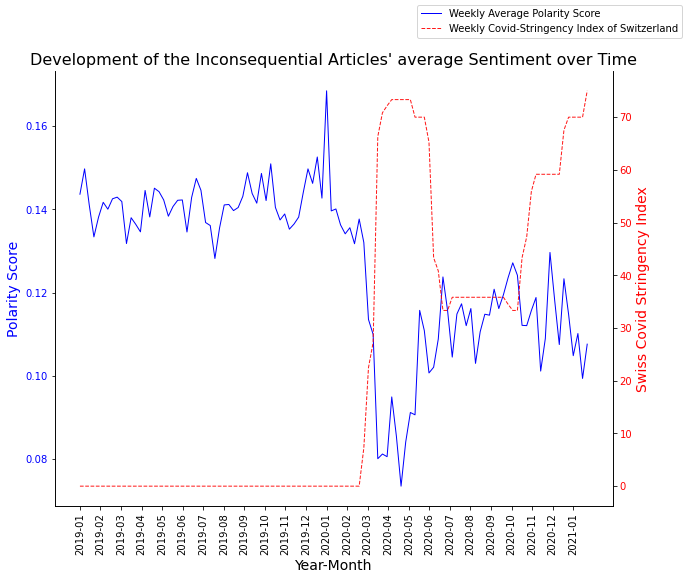

In [57]:
# inconsequential
show_senti_development(articles, 'inconsequential', 'Inconsequential', polarity_type = "Vader_polarity_adj_2")

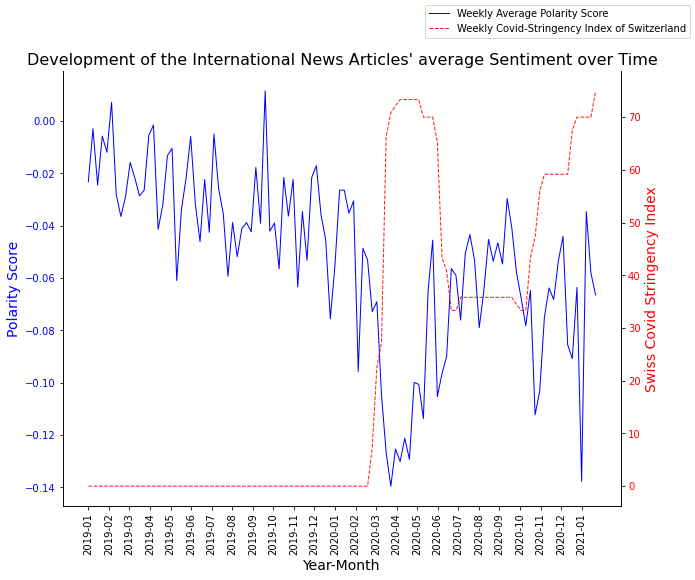

In [58]:
# international news
show_senti_development(articles, 'international_news', 'International News', polarity_type = "Vader_polarity_adj_2")

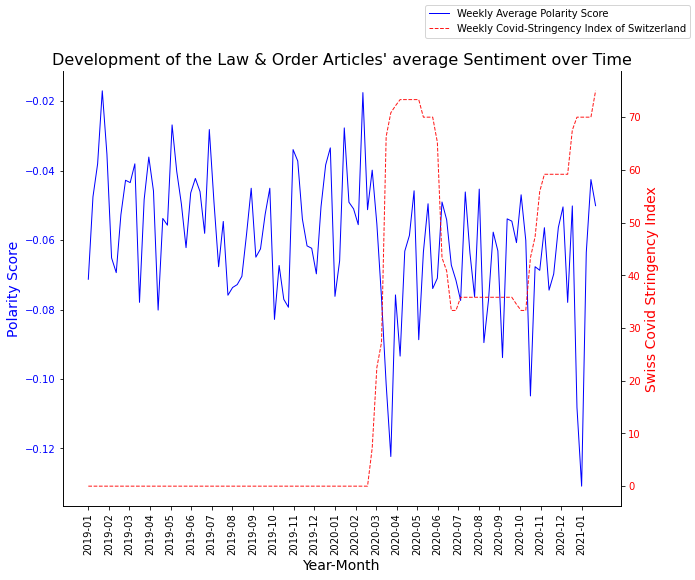

In [59]:
# law & order
show_senti_development(articles, 'law_order', 'Law & Order', polarity_type = "Vader_polarity_adj_2")

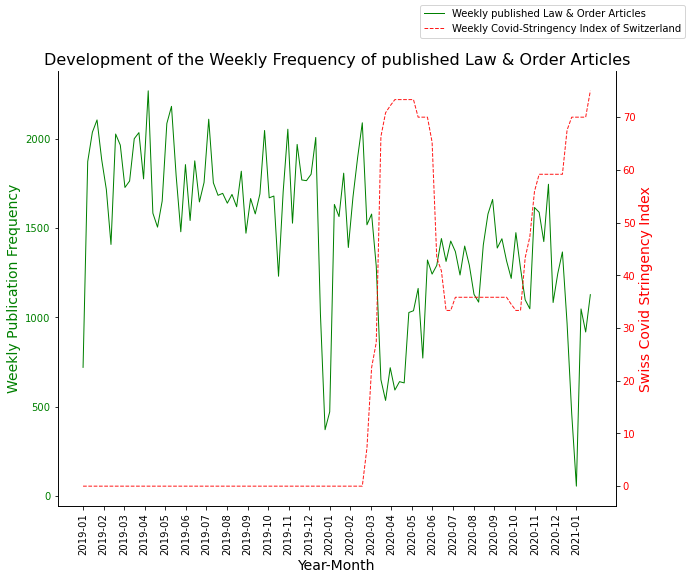

In [60]:
# L&O articles frequency
show_publ_frequency_development(articles, 'law_order', 'Law & Order')

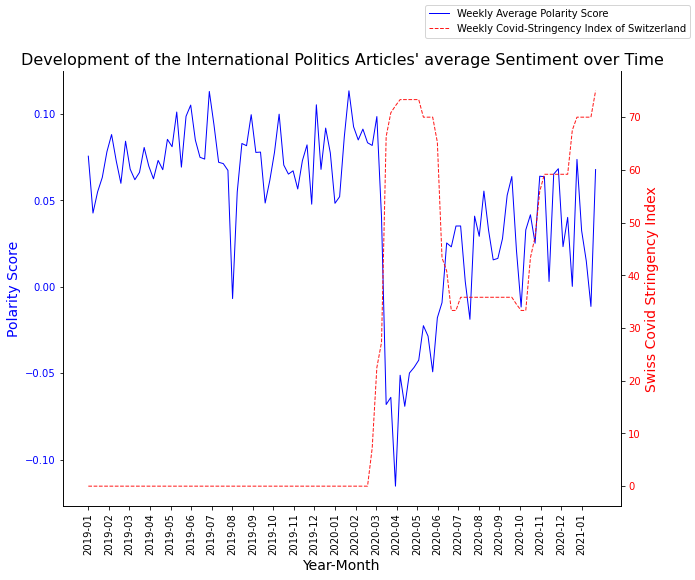

In [61]:
# politics international
show_senti_development(articles, 'politics_international', 'International Politics', polarity_type = "Vader_polarity_adj_2")

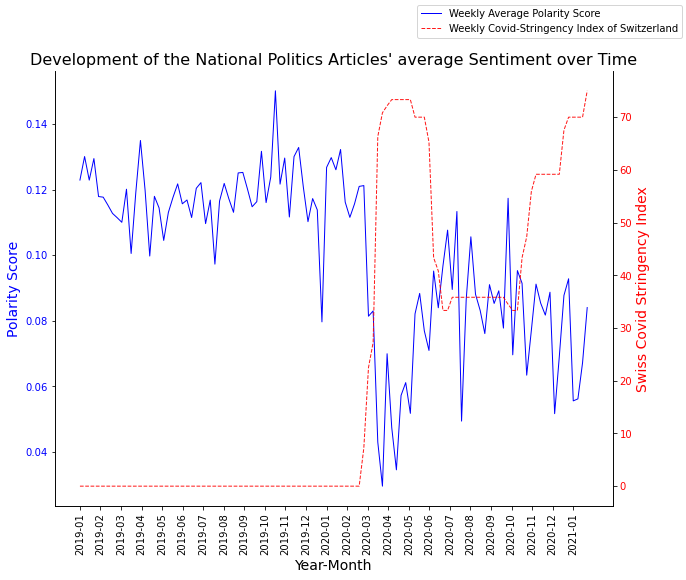

In [62]:
# politics national
show_senti_development(articles, 'politics_national', 'National Politics', polarity_type = "Vader_polarity_adj_2")

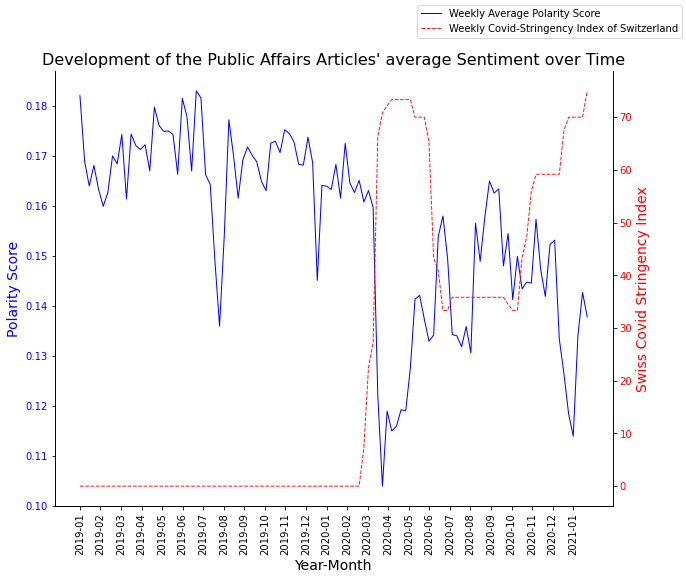

In [63]:
# public affairs
show_senti_development(articles, 'public_affairs', 'Public Affairs', polarity_type = "Vader_polarity_adj_2")

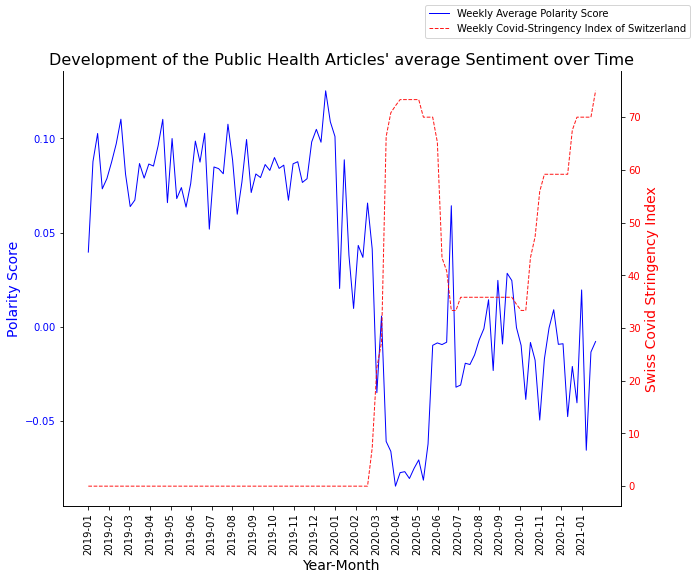

In [64]:
# public health
show_senti_development(articles, 'public_health', 'Public Health', polarity_type = "Vader_polarity_adj_2")

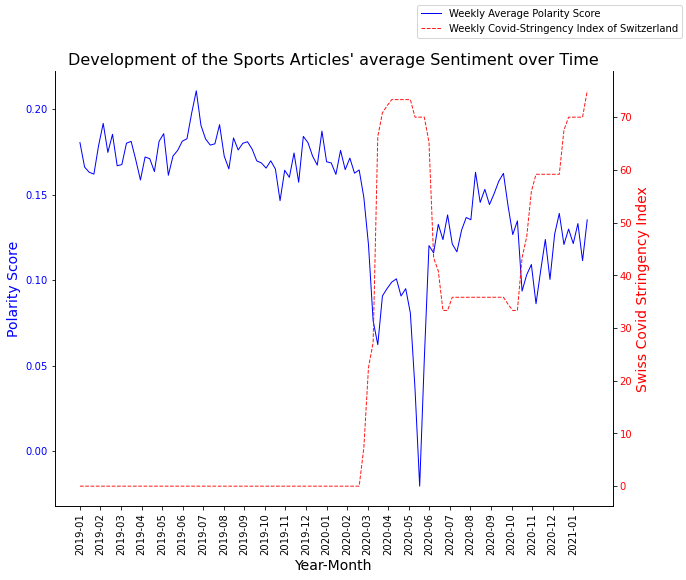

In [65]:
# sports
show_senti_development(articles, 'sports', 'Sports', polarity_type = "Vader_polarity_adj_2")

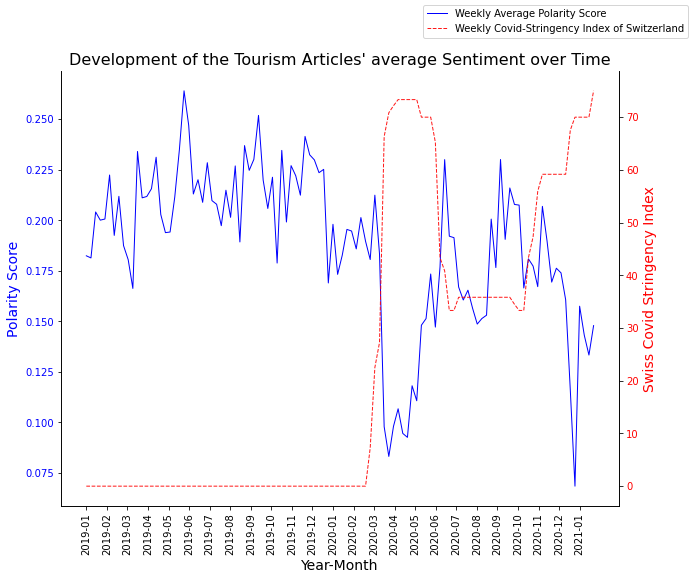

In [66]:
# tourism
show_senti_development(articles, 'tourism', 'Tourism', polarity_type = "Vader_polarity_adj_2")

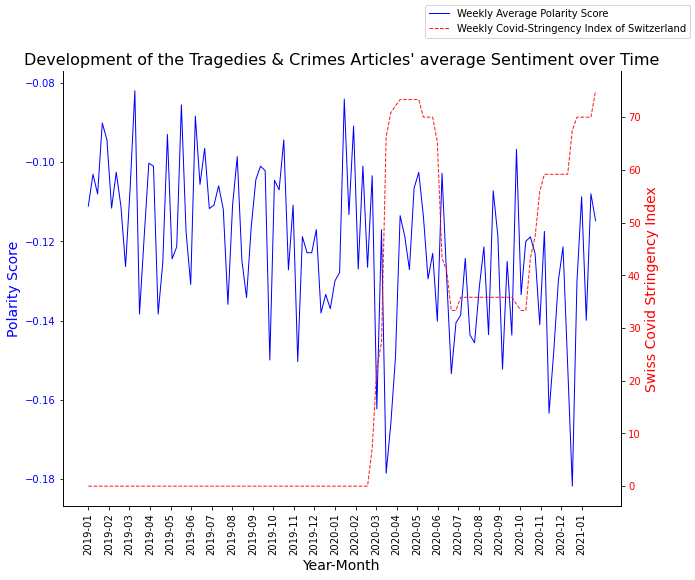

In [67]:
# tragedies_crimes
show_senti_development(articles, 'tragedies_crimes', 'Tragedies & Crimes', polarity_type = "Vader_polarity_adj_2")

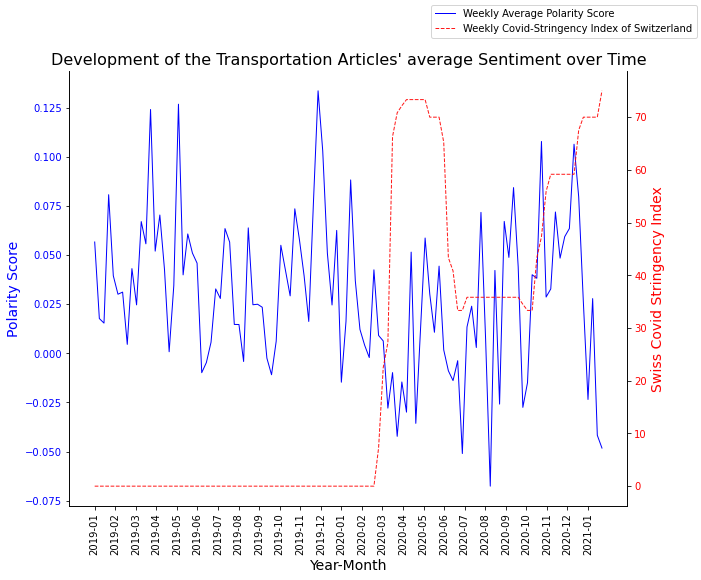

In [68]:
# transportation
show_senti_development(articles, 'transportation', 'Transportation', polarity_type = "Vader_polarity_adj_2")

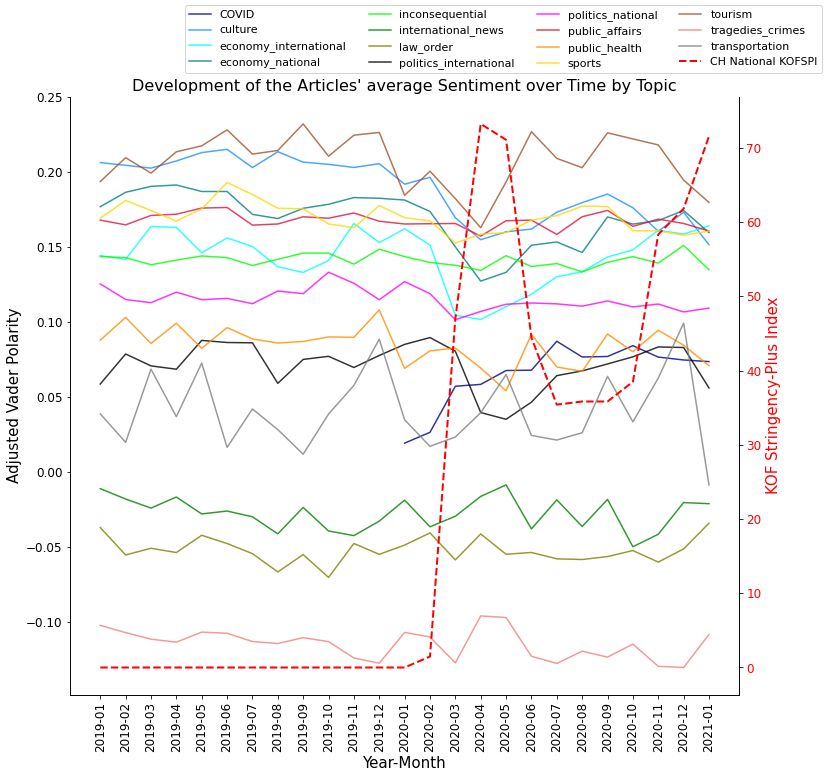

In [69]:
## Overall comparison monthly
# Display and compare the topic specific development of the articles' sentiment over time (using the VPA)
compare_senti_development_across_topics_monthly(articles, polarity_type = "Vader_polarity_adj", y_label = 'Adjusted Vader Polarity', min_monthly_publication_share = 0.003)

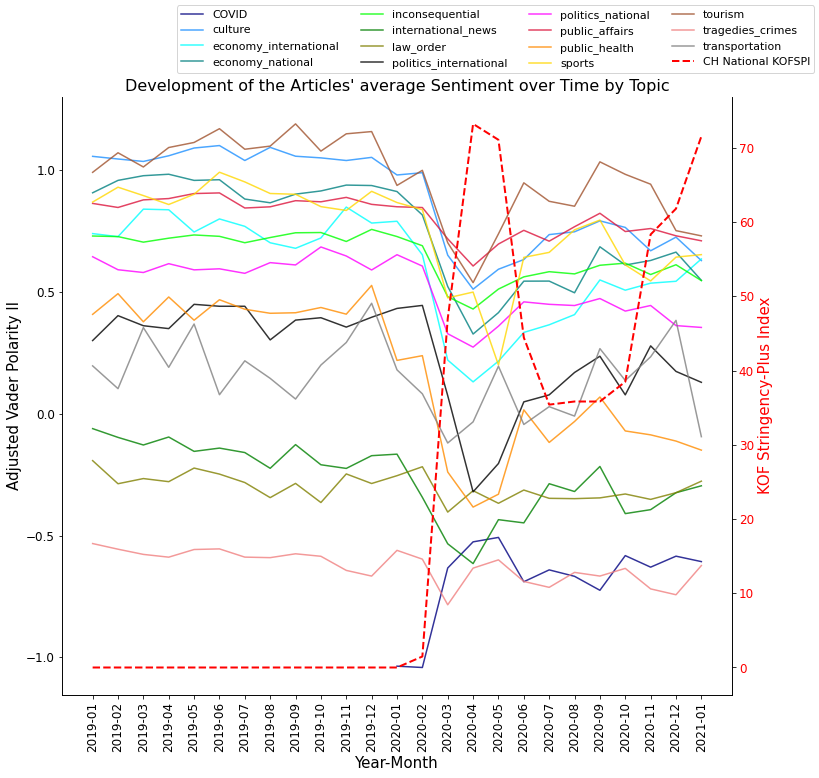

In [70]:
## Overall comparison monthly
# Display and compare the topic specific development of the articles' sentiment over time (using the VPAII)
compare_senti_development_across_topics_monthly(articles, polarity_type = "Vader_polarity_adj_2_rsc", y_label = 'Adjusted Vader Polarity II', min_monthly_publication_share = 0.003)

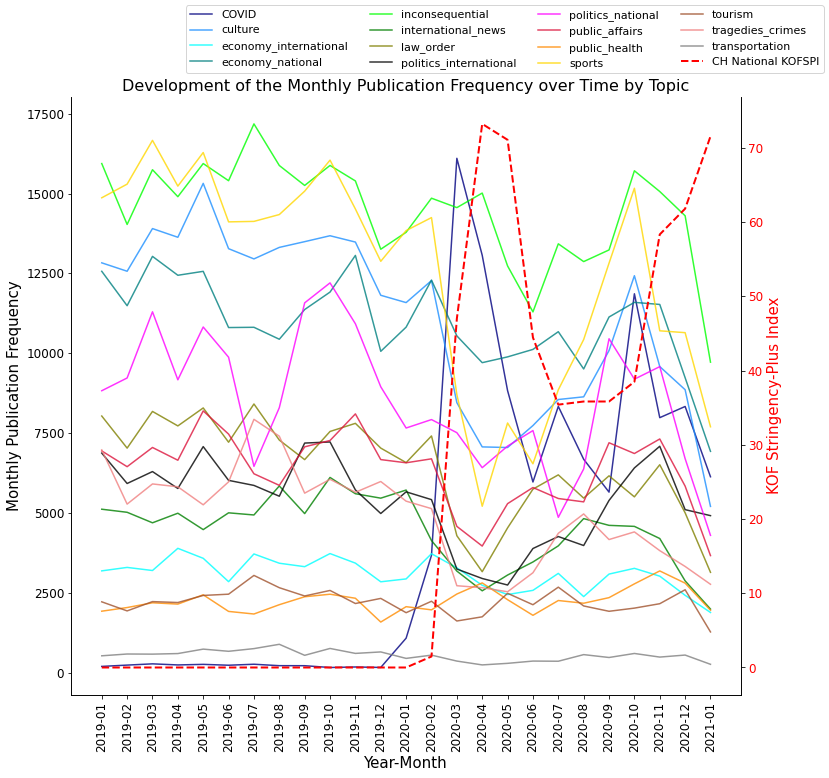

In [71]:
## Overall frequency comparison monthly
# Display and compare the topic specific development of the monthly publication frequency over time
compare_publ_frequency_development_across_topics_monthly(articles)

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
3. News Channel specific EDA
</h2>
</div>

In [72]:
## Define a function to display the topic specific portion of the overall publications for each News Channel
def show_topic_publication_portion_by_channels(articles, topic, topic_fulltext):
    # Count the overall publications per media channel
    total_counts = np.unique(articles['source_long'], return_counts = True)
    # Create a dataframe containing the number of total publications in a column while using the according media channel as the index
    total_counts = pd.DataFrame({'total_counts': total_counts[1]}, index = total_counts[0]).sort_index()
    # Count the topic specific publications per media channel
    topic_counts = np.unique(articles.loc[articles['Topic_1'] == topic, 'source_long'], return_counts = True)
    # Create a dataframe containing the topic specific publications in a column while using the according media channel as the index
    topic_counts = pd.DataFrame({'topic_counts': topic_counts[1]}, index = topic_counts[0]).sort_index()
    # Merge both dataframes
    topic_coverage = total_counts.merge(topic_counts, how = 'left', left_index = True, right_index = True, validate = "1:1").sort_index()
    # Replace all missing values in the column topic_counts with a 0, since no articles on the focal topic have been published by the corresponding News Channels
    topic_coverage.loc[topic_coverage['topic_counts'].isna(), 'topic_counts'] = 0
    # Create a column containing the topic specific portion of the overall publications for each News Channel
    topic_coverage['topic_portion'] = topic_coverage['topic_counts'].values / topic_coverage['total_counts'].values

    # Plot the topic specific publication portion for each News Channel
    fig = plt.figure(figsize = (13,20))
    ax = fig.add_subplot(111)
    y_pos = np.arange(topic_coverage.shape[0])
    ax.barh(y_pos, topic_coverage['topic_portion'].values, align = 'center', color = 'black', alpha = 0.8, label = 'Portion of '+topic_fulltext+' Articles')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(topic_coverage.index.tolist())
    ax.set_title('Portion of '+topic_fulltext+' Articles by News Channel')
    ax.set_ylabel('News Channel')
    ax.set_xlabel('Portion of Total Publications')
    ax.invert_yaxis() # to read labels from top-to-bottom
    # Display the plot
    plt.legend()
    plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.1 Average Polarity by News Channel
</h3>
</div>

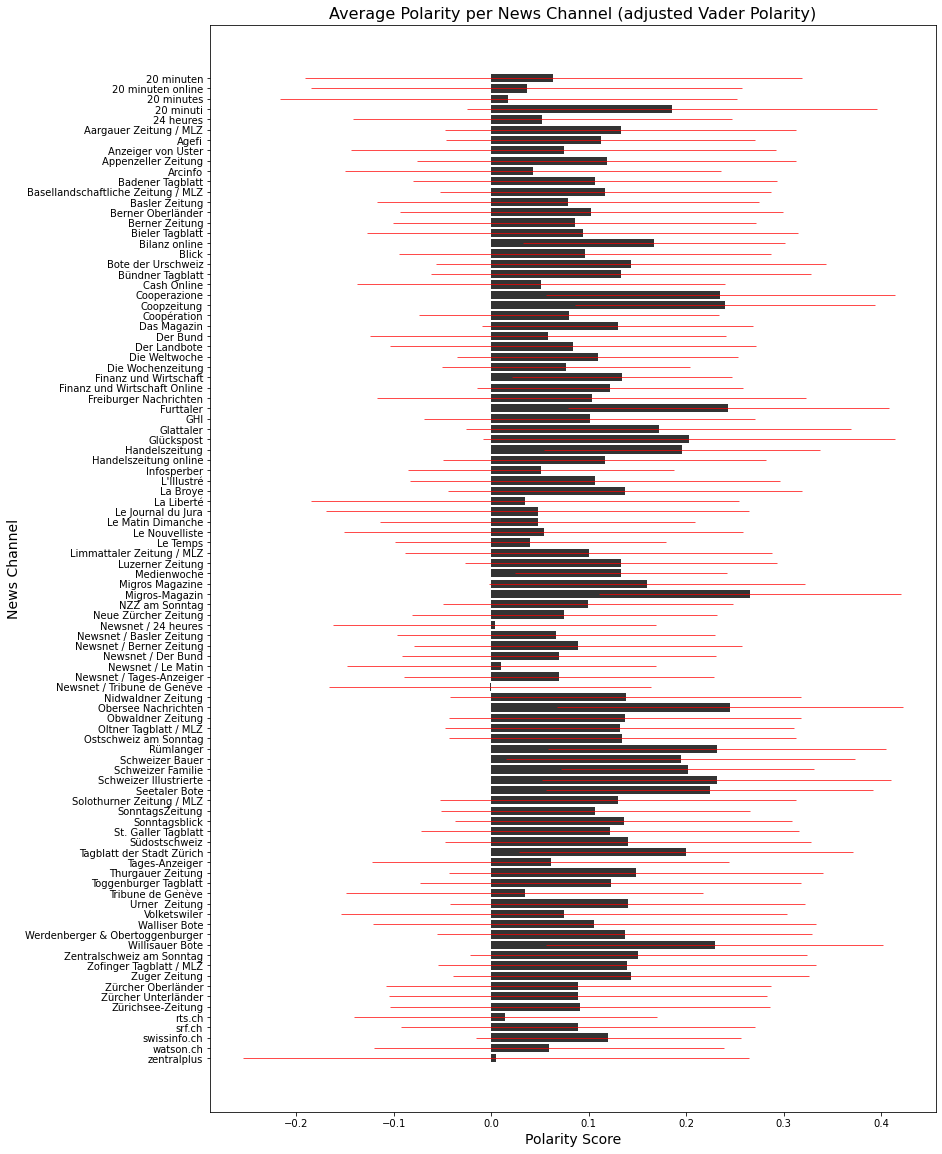

In [73]:
## Display the average Vader polarity per News Channel together with the standard deviation (using VPAII)
# Get the average Vader polarity per News Channel
avg_pol_by_source = articles.groupby('source_long')['Vader_polarity_adj_2'].mean()
std_pol_by_source = articles.groupby('source_long')['Vader_polarity_adj_2'].std()
# Plot the average Vader polarity per News Channel
fig = plt.figure(figsize = (13,20))
ax = fig.add_subplot(111)
y_pos = np.arange(len(avg_pol_by_source.index))
ax.barh(y_pos, avg_pol_by_source.values, xerr = std_pol_by_source.values, align = 'center', color = 'black', alpha = 0.8, ecolor = 'red', error_kw = {'lw': 0.7})
ax.set_yticks(y_pos)
ax.set_yticklabels(avg_pol_by_source.index)
ax.set_title('Average Polarity per News Channel (adjusted Vader Polarity)')
ax.set_ylabel('News Channel')
ax.set_xlabel('Polarity Score')
ax.invert_yaxis() # to read labels from top-to-bottom
# Display the plot
plt.show()

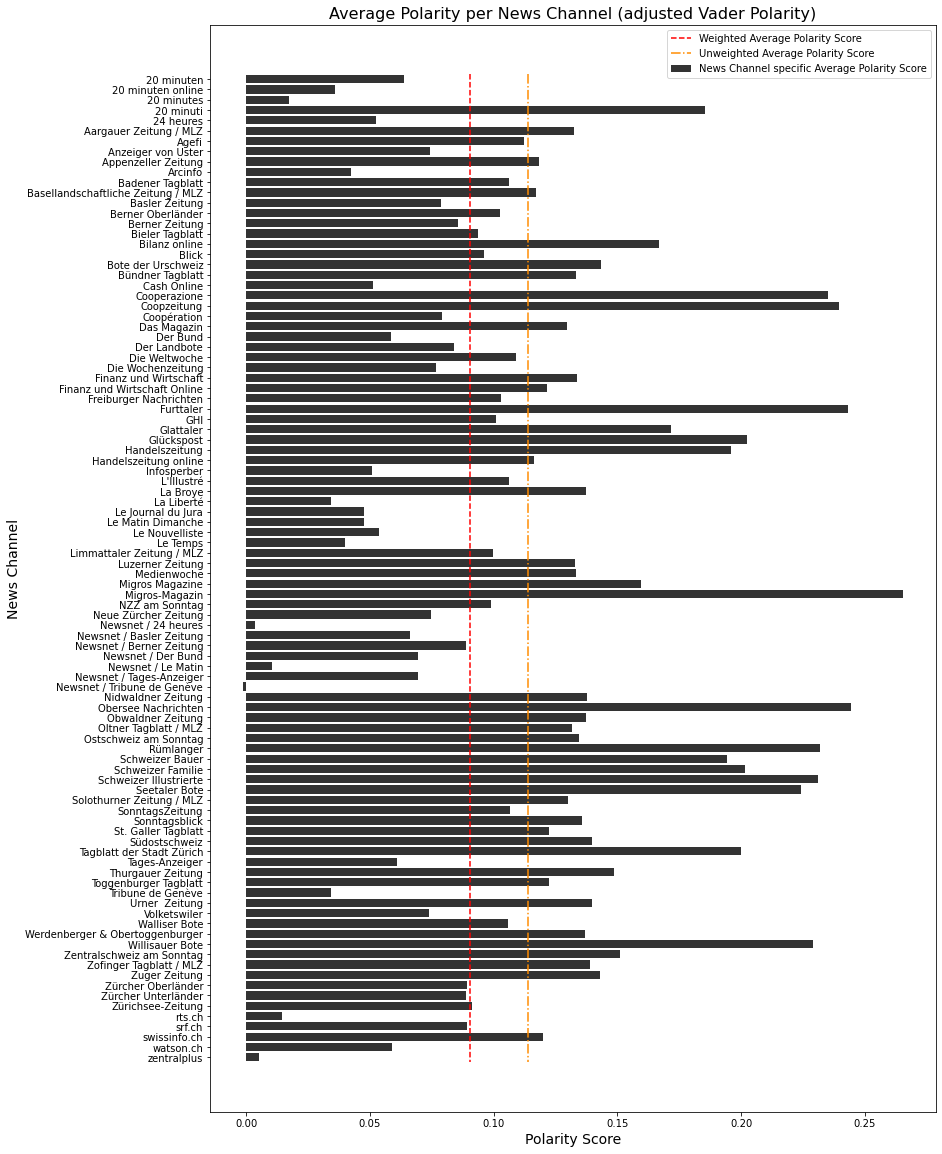

In [74]:
## Display the average Vader polarity per News Channel (using VPAII)
# Get the average Vader polarity per News Channel
avg_pol_by_source = articles.groupby('source_long')['Vader_polarity_adj_2'].mean()
# Get the overall average Vader polarity score (i.e. weighted mean of the average polarity scores of the news channels)
avg_pol_weighted = articles['Vader_polarity_adj_2'].mean()
# Get the unweighted mean of the average polarity scores of the news channels
avg_pol_unweighted = np.mean(avg_pol_by_source.values)
# Plot the average Vader polarity per News Channel
fig = plt.figure(figsize = (13,20))
ax = fig.add_subplot(111)
y_pos = np.arange(len(avg_pol_by_source.index))
ax.barh(y_pos, avg_pol_by_source.values, align = 'center', color = 'black', alpha = 0.8, label = 'News Channel specific Average Polarity Score')
ax.plot([avg_pol_weighted, avg_pol_weighted], [min(y_pos)-0.5, max(y_pos)+0.5], color = 'red', linestyle = '--', label = 'Weighted Average Polarity Score')
ax.plot([avg_pol_unweighted, avg_pol_unweighted], [min(y_pos)-0.5, max(y_pos)+0.5], color = 'darkorange', linestyle = '-.', label = 'Unweighted Average Polarity Score')
ax.set_yticks(y_pos)
ax.set_yticklabels(avg_pol_by_source.index)
ax.set_title('Average Polarity per News Channel (adjusted Vader Polarity)')
ax.set_ylabel('News Channel')
ax.set_xlabel('Polarity Score')
ax.invert_yaxis() # to read labels from top-to-bottom
# Display the plot
plt.legend()
plt.show()

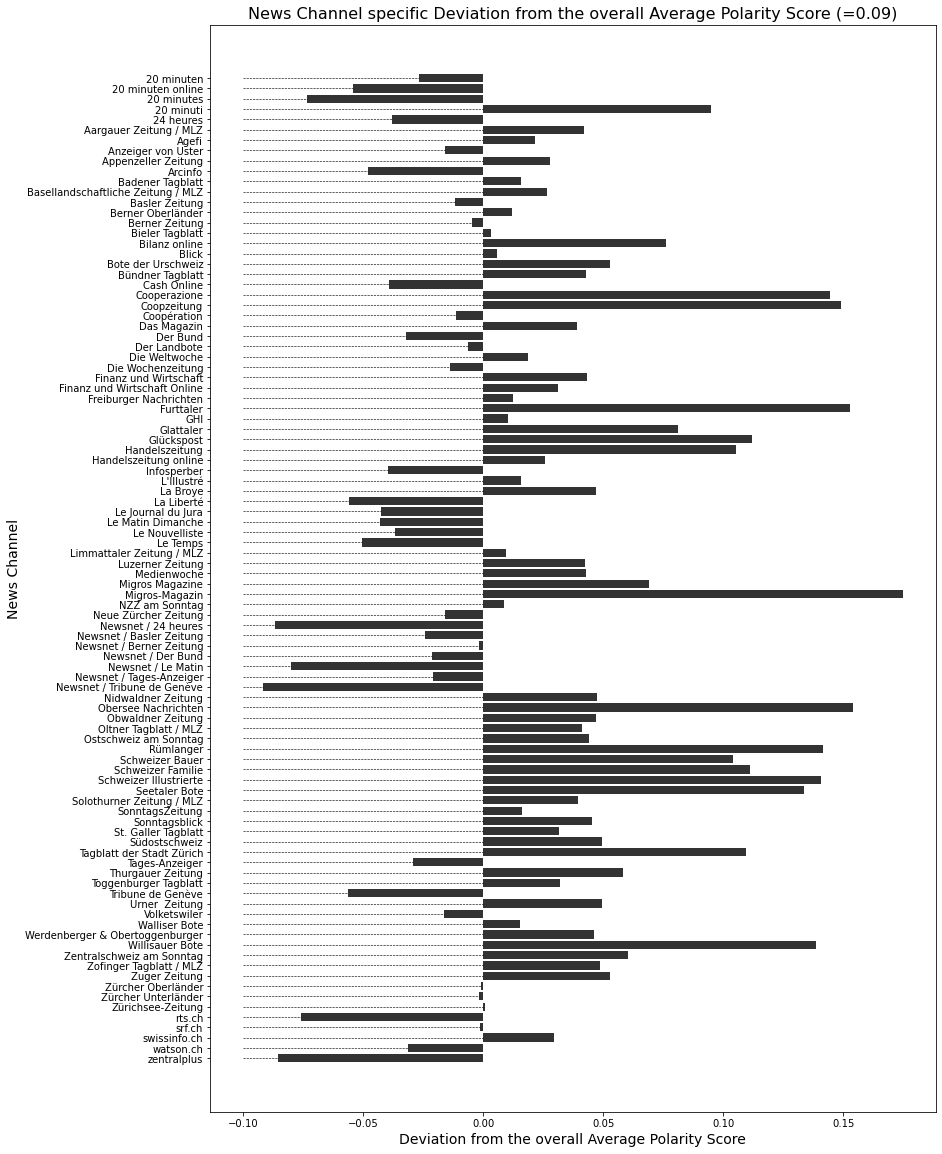

In [75]:
## Display the difference between the weighted average polarity score and the News Channel specific average polarity score (using VPAII)
# Get the overall average Vader polarity score
avg_pol = articles['Vader_polarity_adj_2'].mean()
# Get the average Vader polarity per News Channel
avg_pol_by_source = articles.groupby('source_long')['Vader_polarity_adj_2'].mean()
# Plot the average Vader polarity per News Channel
fig = plt.figure(figsize = (13,20))
ax = fig.add_subplot(111)
y_pos = np.arange(len(avg_pol_by_source.index))
ax.barh(y_pos, avg_pol_by_source.values - avg_pol, align = 'center', color = 'black', alpha = 0.8)
for i in range(len(y_pos)):
    if (avg_pol_by_source.values[i] - avg_pol) >= 0:
        x_end = 0
    else:
        x_end = (avg_pol_by_source.values[i] - avg_pol)
    ax.plot([-0.1, x_end], [y_pos[i], y_pos[i]], color = 'black', linestyle = '--', alpha = 1, linewidth = 0.6)
ax.set_yticks(y_pos)
ax.set_yticklabels(avg_pol_by_source.index)
ax.set_title('News Channel specific Deviation from the overall Average Polarity Score (='+str(np.round(avg_pol, 3))+')')
ax.set_ylabel('News Channel')
ax.set_xlabel('Deviation from the overall Average Polarity Score')
ax.invert_yaxis() # to read labels from top-to-bottom
# Display the plot
plt.show()

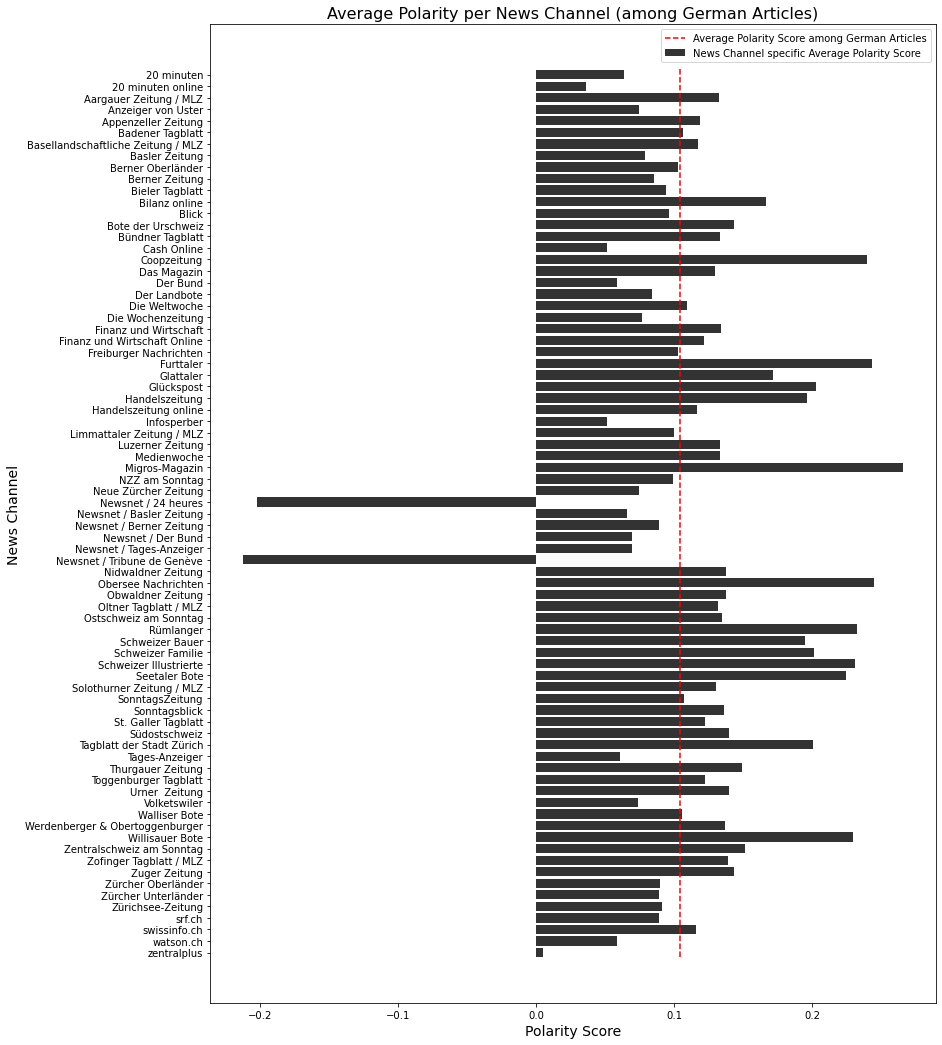

In [76]:
## Display the average Vader polarity per News Channel (using VPAII) among the German articles
# Get the average Vader polarity per News Channel
avg_pol_by_source = articles.loc[articles['language'] == 'de'].groupby('source_long')['Vader_polarity_adj_2'].mean()
# Get the average Vader polarity score by language
de_avg_pol = articles.loc[articles['language'] == 'de', 'Vader_polarity_adj_2'].mean()
# Plot the average Vader polarity per News Channel
fig = plt.figure(figsize = (13,18))
ax = fig.add_subplot(111)
y_pos = np.arange(len(avg_pol_by_source.index))
ax.barh(y_pos, avg_pol_by_source.values, align = 'center', color = 'black', alpha = 0.8, label = 'News Channel specific Average Polarity Score')
ax.plot([de_avg_pol, de_avg_pol], [min(y_pos)-0.5, max(y_pos)+0.5], color = 'red', linestyle = '--', label = 'Average Polarity Score among German Articles')
ax.set_yticks(y_pos)
ax.set_yticklabels(avg_pol_by_source.index)
ax.set_title('Average Polarity per News Channel (among German Articles)')
ax.set_ylabel('News Channel')
ax.set_xlabel('Polarity Score')
ax.invert_yaxis() # to read labels from top-to-bottom
# Display the plot
plt.legend()
plt.show()

In [77]:
## Take a look at the topics covered by the German articles from the sources Newsnet / 24 heures and Newsnet / Tribune de Geneve
# Newsnet / 24 heures
np.unique(articles.loc[np.logical_and(articles['source_short'] == 'NNHEU', articles['language'] == 'de'), 'Topic_fine'] , return_counts = True)
np.unique(articles.loc[np.logical_and(articles['source_short'] == 'NNHEU', articles['language'] == 'de'), 'publication_date'] , return_counts = True)
# Newsnet / tribune de Genève
np.unique(articles.loc[np.logical_and(articles['source_short'] == 'NNTDG', articles['language'] == 'de'), 'Topic_fine'] , return_counts = True)
np.unique(articles.loc[np.logical_and(articles['source_short'] == 'NNTDG', articles['language'] == 'de'), 'publication_date'] , return_counts = True)

(array(['2020-05-09T00:00:00.000000000', '2020-05-10T00:00:00.000000000',
        '2020-05-11T00:00:00.000000000', '2020-05-12T00:00:00.000000000',
        '2020-05-13T00:00:00.000000000', '2020-05-14T00:00:00.000000000',
        '2020-05-15T00:00:00.000000000', '2020-05-16T00:00:00.000000000',
        '2020-05-17T00:00:00.000000000', '2020-05-19T00:00:00.000000000',
        '2020-05-20T00:00:00.000000000', '2020-05-21T00:00:00.000000000',
        '2020-05-22T00:00:00.000000000', '2020-05-23T00:00:00.000000000',
        '2020-05-24T00:00:00.000000000', '2020-05-25T00:00:00.000000000',
        '2020-05-26T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([ 3,  2,  1, 10, 23, 84, 85, 53, 43, 85, 86, 52, 85, 60, 34, 78, 94],
       dtype=int64))

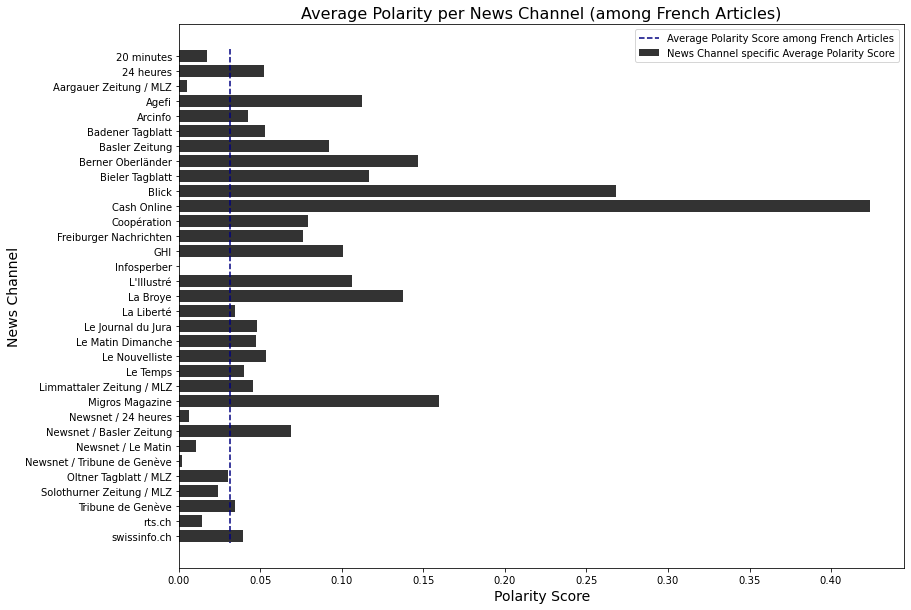

In [78]:
## Display the average Vader polarity per News Channel (using VPAII) among the French articles
# Get the average Vader polarity per News Channel
avg_pol_by_source = articles.loc[articles['language'] == 'fr'].groupby('source_long')['Vader_polarity_adj_2'].mean()
fr_avg_pol = articles.loc[articles['language'] == 'fr', 'Vader_polarity_adj_2'].mean()
fig = plt.figure(figsize = (13,10))
ax = fig.add_subplot(111)
y_pos = np.arange(len(avg_pol_by_source.index))
ax.barh(y_pos, avg_pol_by_source.values, align = 'center', color = 'black', alpha = 0.8, label = 'News Channel specific Average Polarity Score')
ax.plot([fr_avg_pol, fr_avg_pol], [min(y_pos)-0.5, max(y_pos)+0.5], color = 'navy', linestyle = '--', label = 'Average Polarity Score among French Articles')
ax.set_yticks(y_pos)
ax.set_yticklabels(avg_pol_by_source.index)
ax.set_title('Average Polarity per News Channel (among French Articles)')
ax.set_ylabel('News Channel')
ax.set_xlabel('Polarity Score')
ax.invert_yaxis() # to read labels from top-to-bottom
# Display the plot
plt.legend()
plt.show()

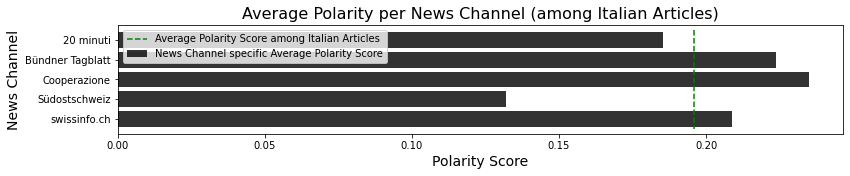

In [79]:
## Display the average Vader polarity per News Channel (using VPAII) among the Italian articles
# Get the average Vader polarity per News Channel
avg_pol_by_source = articles.loc[articles['language'] == 'it'].groupby('source_long')['Vader_polarity_adj_2'].mean()
# Get the average Vader polarity score by language
it_avg_pol = articles.loc[articles['language'] == 'it', 'Vader_polarity_adj_2'].mean()
# Plot the average Vader polarity per News Channel
fig = plt.figure(figsize = (13,2))
ax = fig.add_subplot(111)
y_pos = np.arange(len(avg_pol_by_source.index))
ax.barh(y_pos, avg_pol_by_source.values, align = 'center', color = 'black', alpha = 0.8, label = 'News Channel specific Average Polarity Score')
ax.plot([it_avg_pol, it_avg_pol], [min(y_pos)-0.5, max(y_pos)+0.5], color = 'green', linestyle = '--', label = 'Average Polarity Score among Italian Articles')
ax.set_yticks(y_pos)
ax.set_yticklabels(avg_pol_by_source.index)
ax.set_title('Average Polarity per News Channel (among Italian Articles)')
ax.set_ylabel('News Channel')
ax.set_xlabel('Polarity Score')
ax.invert_yaxis() # to read labels from top-to-bottom
# Display the plot
plt.legend()
plt.show()

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h3 style='margin:10px 5px'> 
3.2 Topic Coverage by News Channel
</h3>
</div>

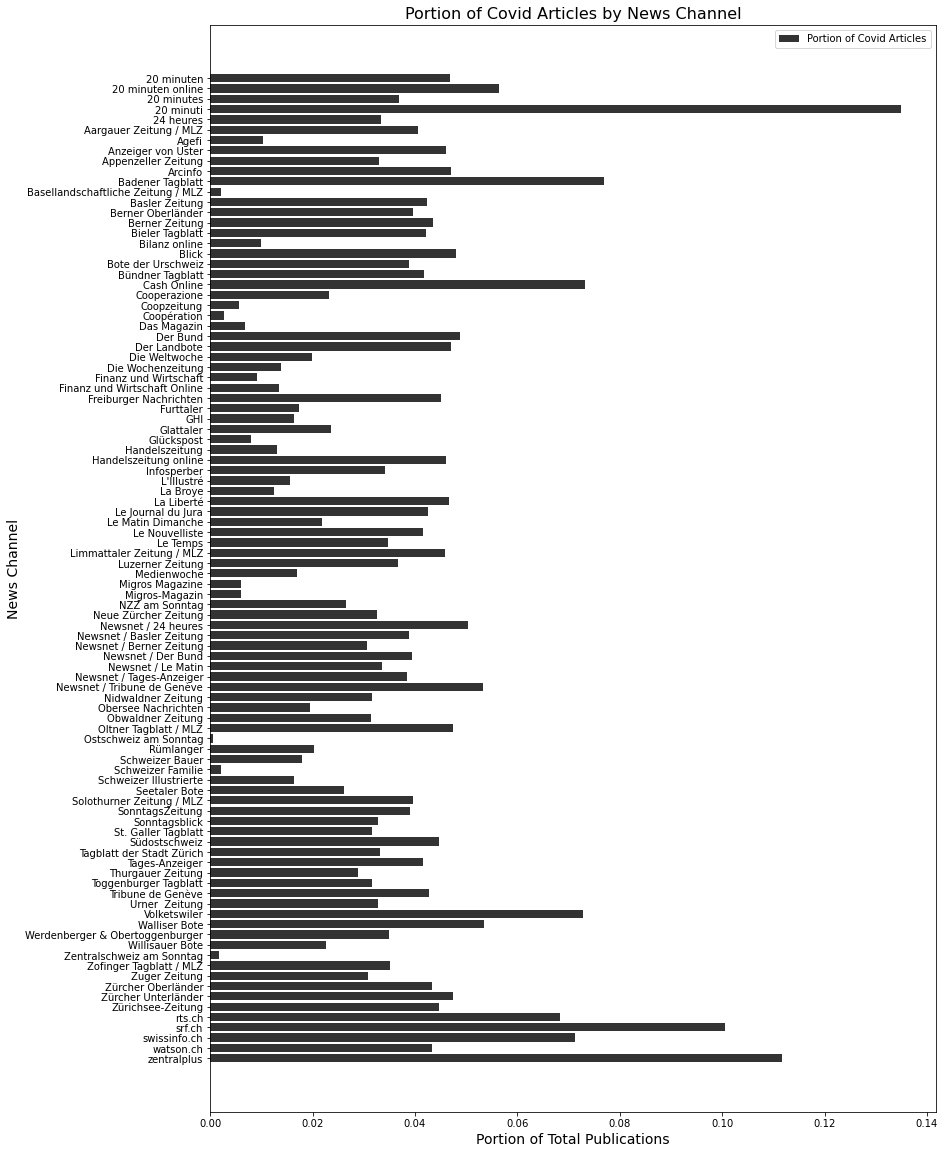

In [80]:
# COVID
show_topic_publication_portion_by_channels(articles, 'COVID', 'Covid')

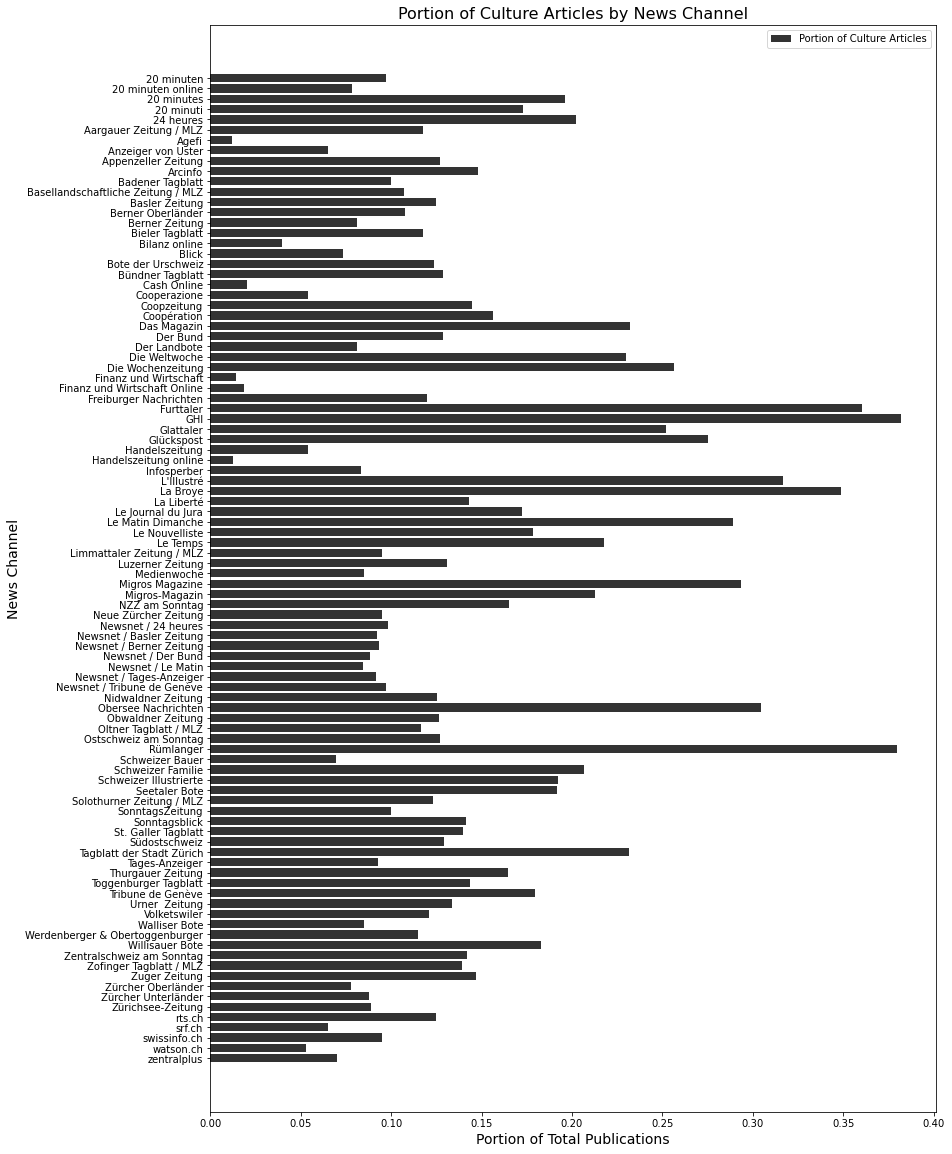

In [81]:
# culture
show_topic_publication_portion_by_channels(articles, 'culture', 'Culture')

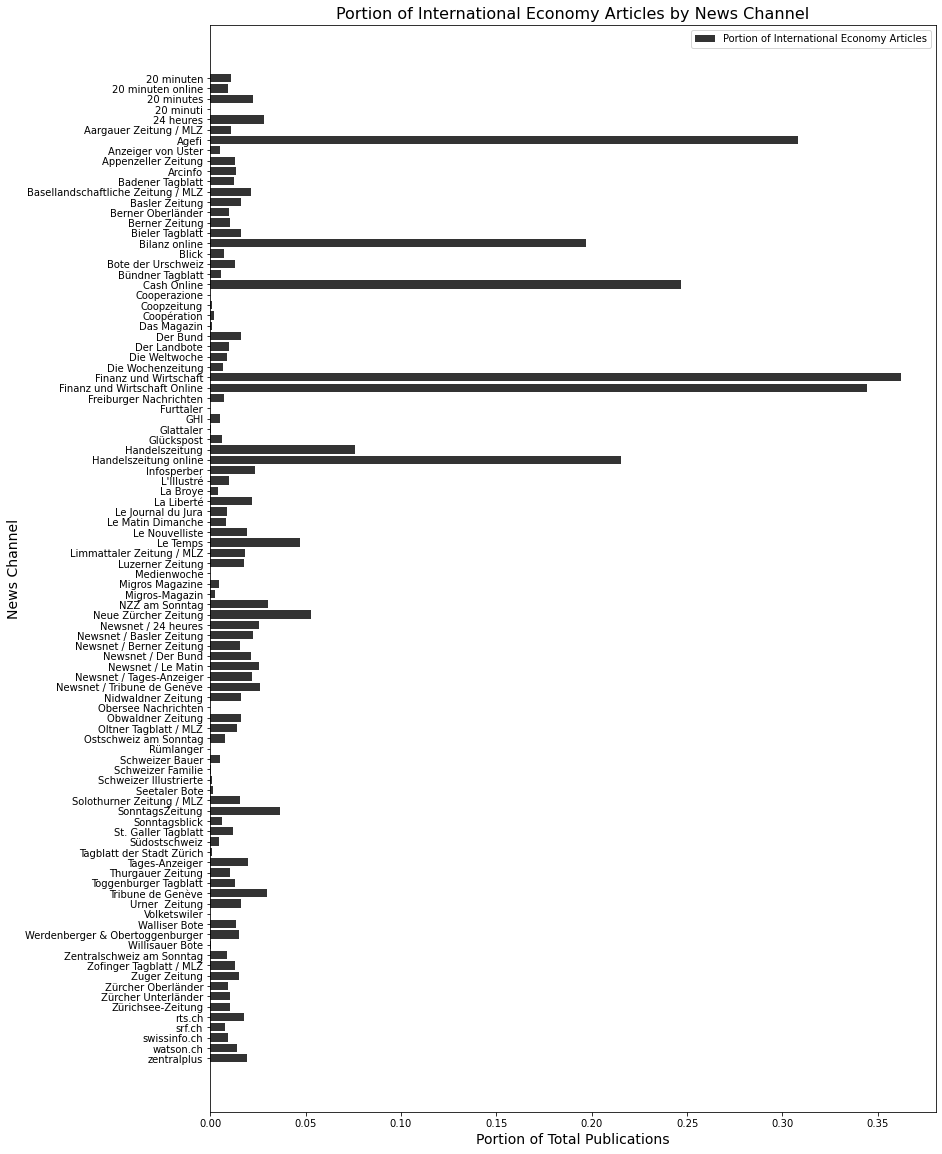

In [82]:
# economy_international
show_topic_publication_portion_by_channels(articles, 'economy_international', 'International Economy')

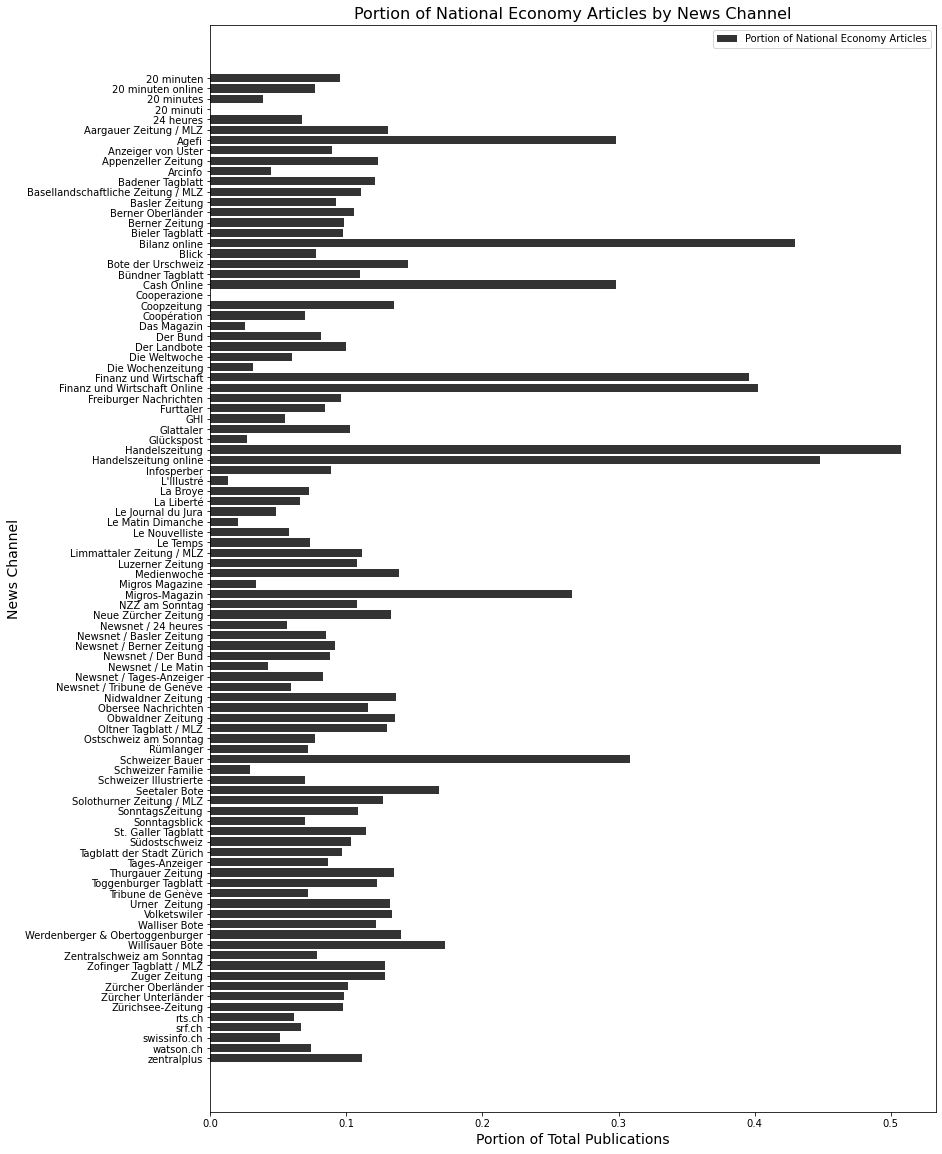

In [83]:
# economy_national
show_topic_publication_portion_by_channels(articles, 'economy_national', 'National Economy')

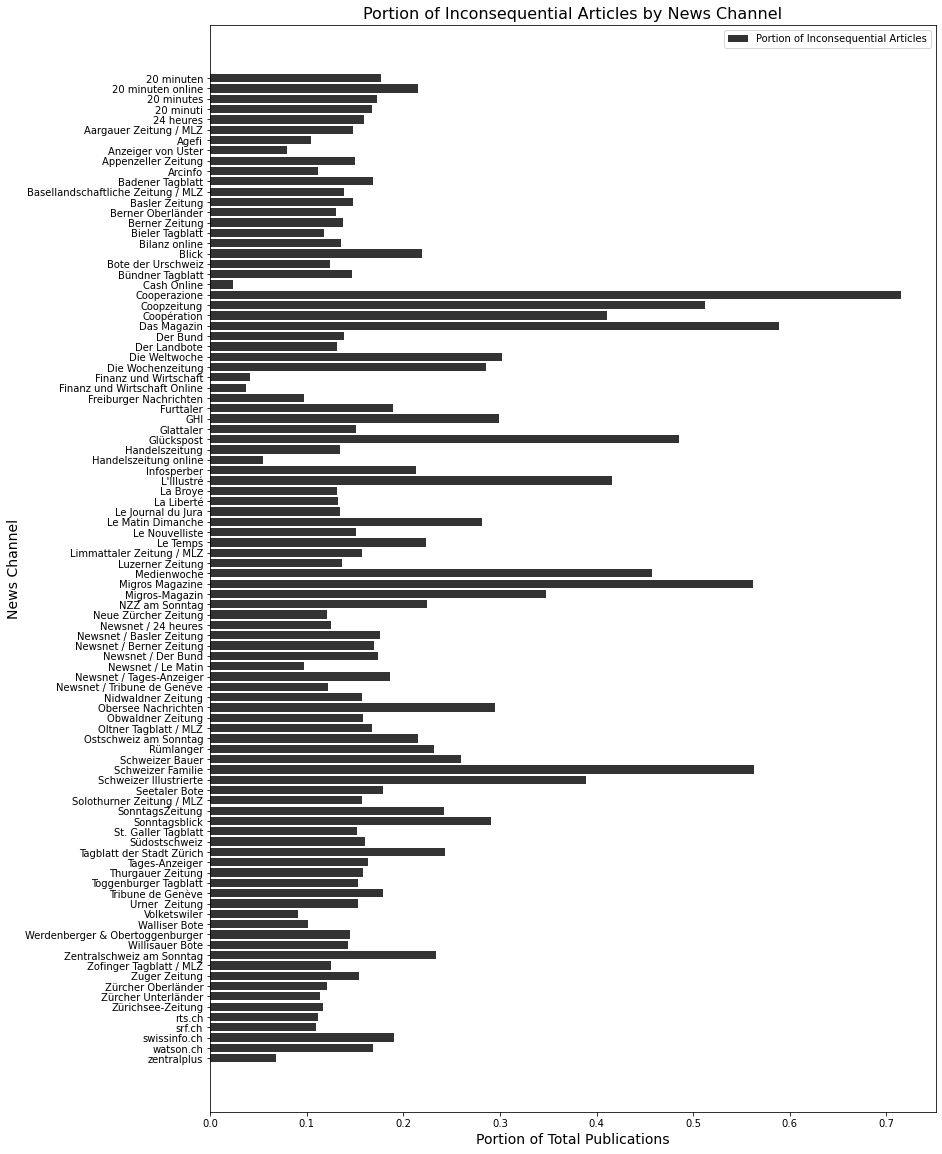

In [84]:
# inconsequential
show_topic_publication_portion_by_channels(articles, 'inconsequential', 'Inconsequential')

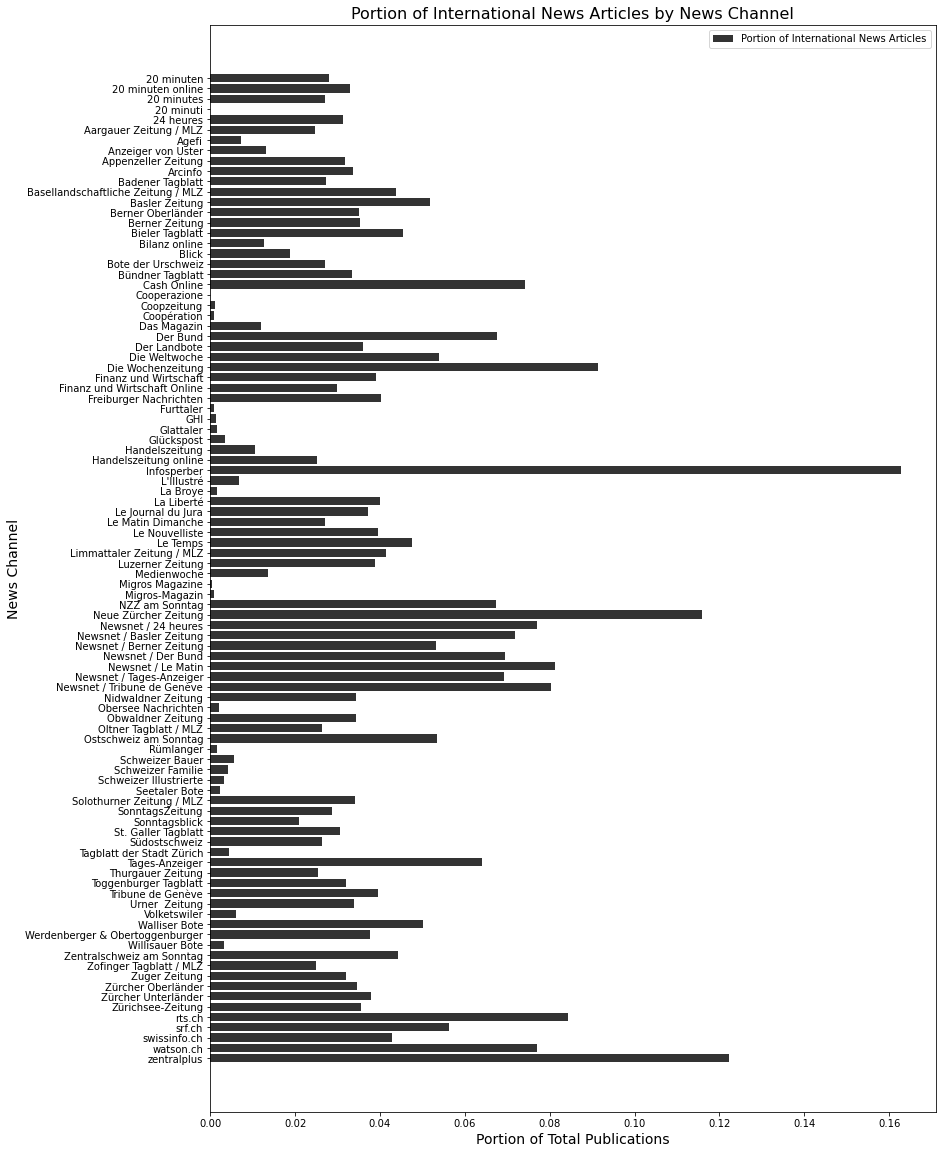

In [85]:
# international_news
show_topic_publication_portion_by_channels(articles, 'international_news', 'International News')

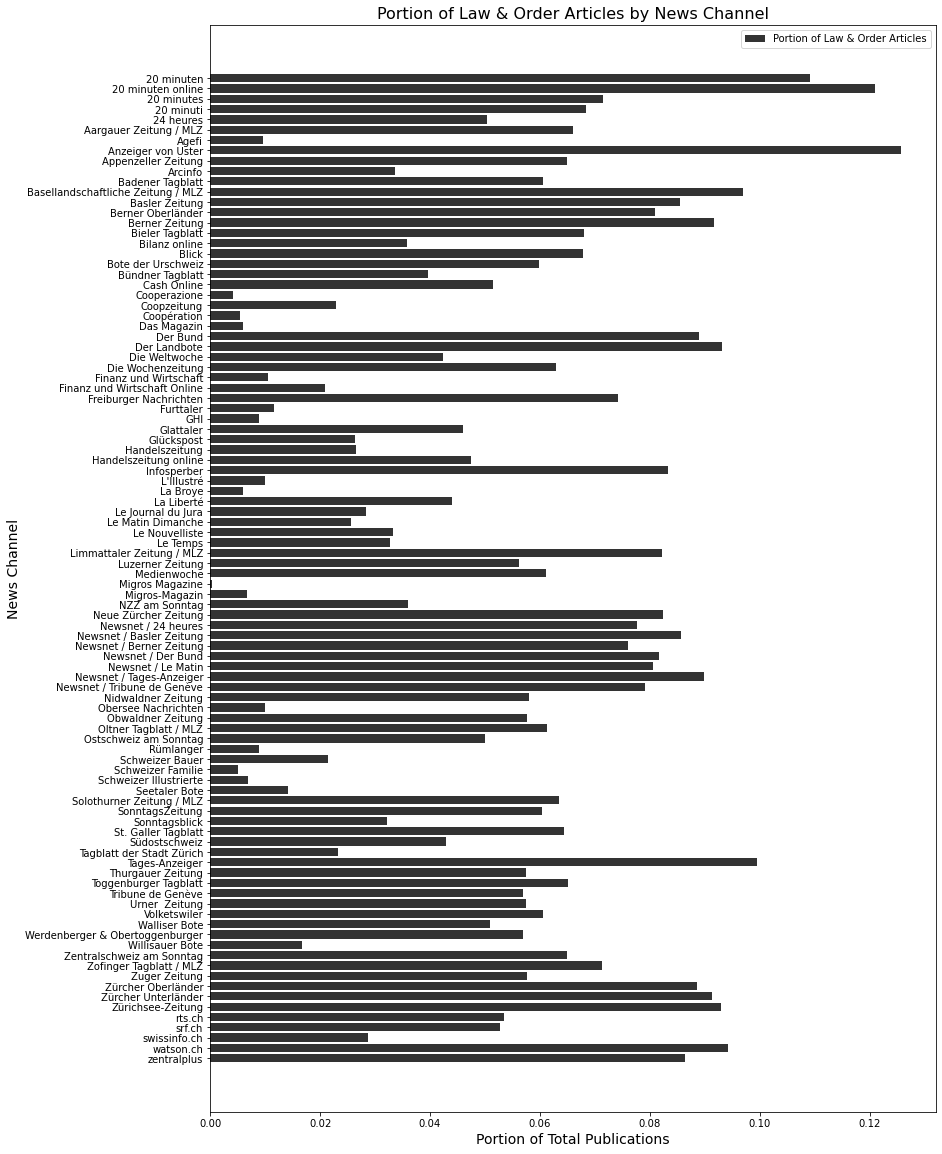

In [86]:
# law_order
show_topic_publication_portion_by_channels(articles, 'law_order', 'Law & Order')

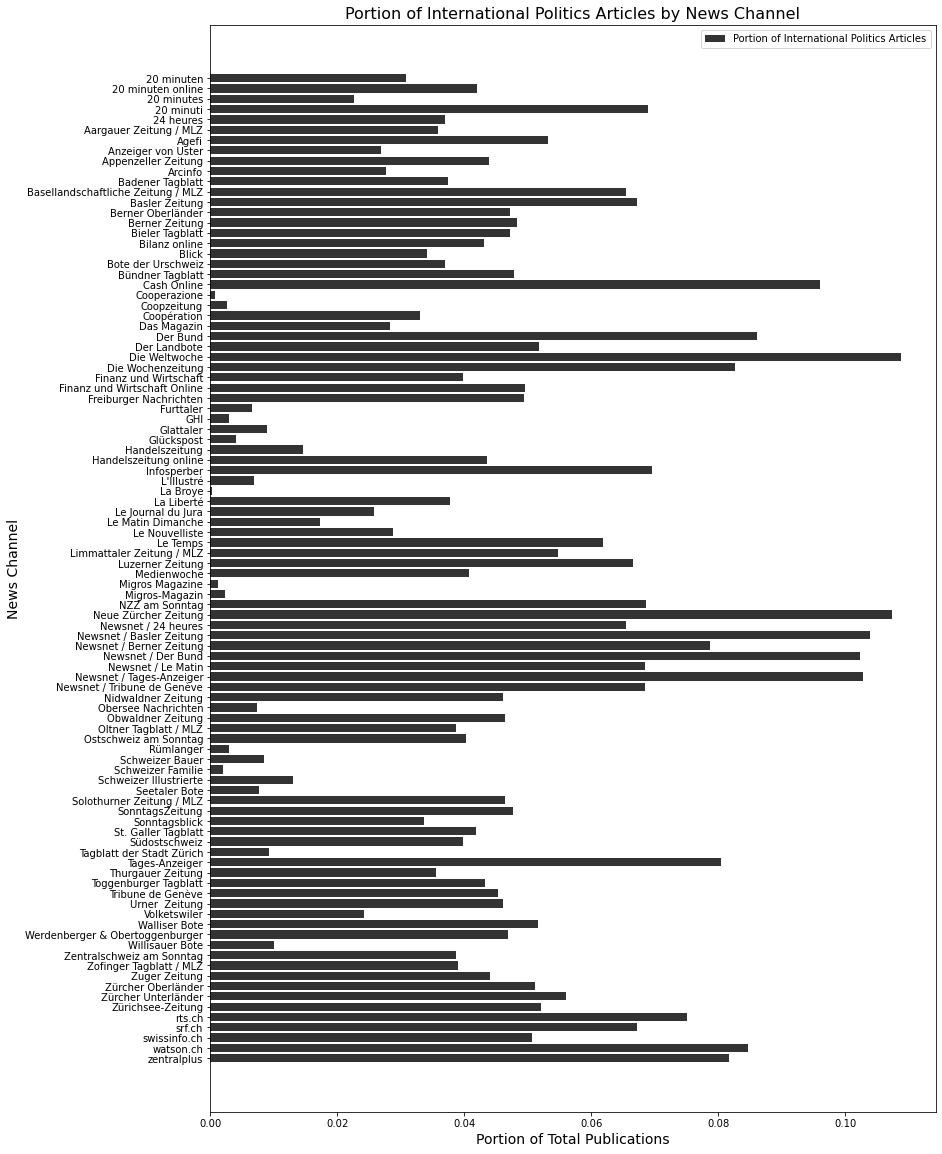

In [87]:
# politics_international
show_topic_publication_portion_by_channels(articles, 'politics_international', 'International Politics')

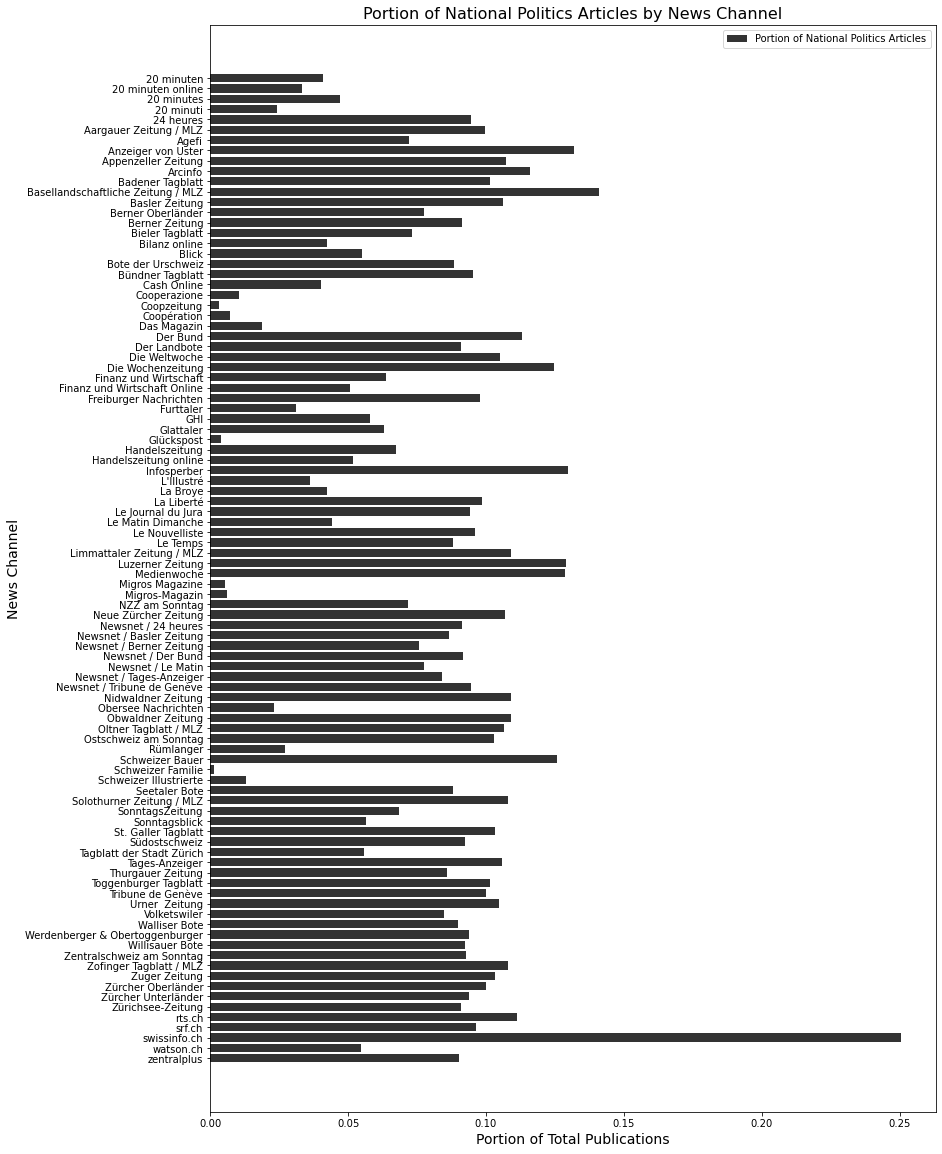

In [88]:
# politics_national
show_topic_publication_portion_by_channels(articles, 'politics_national', 'National Politics')

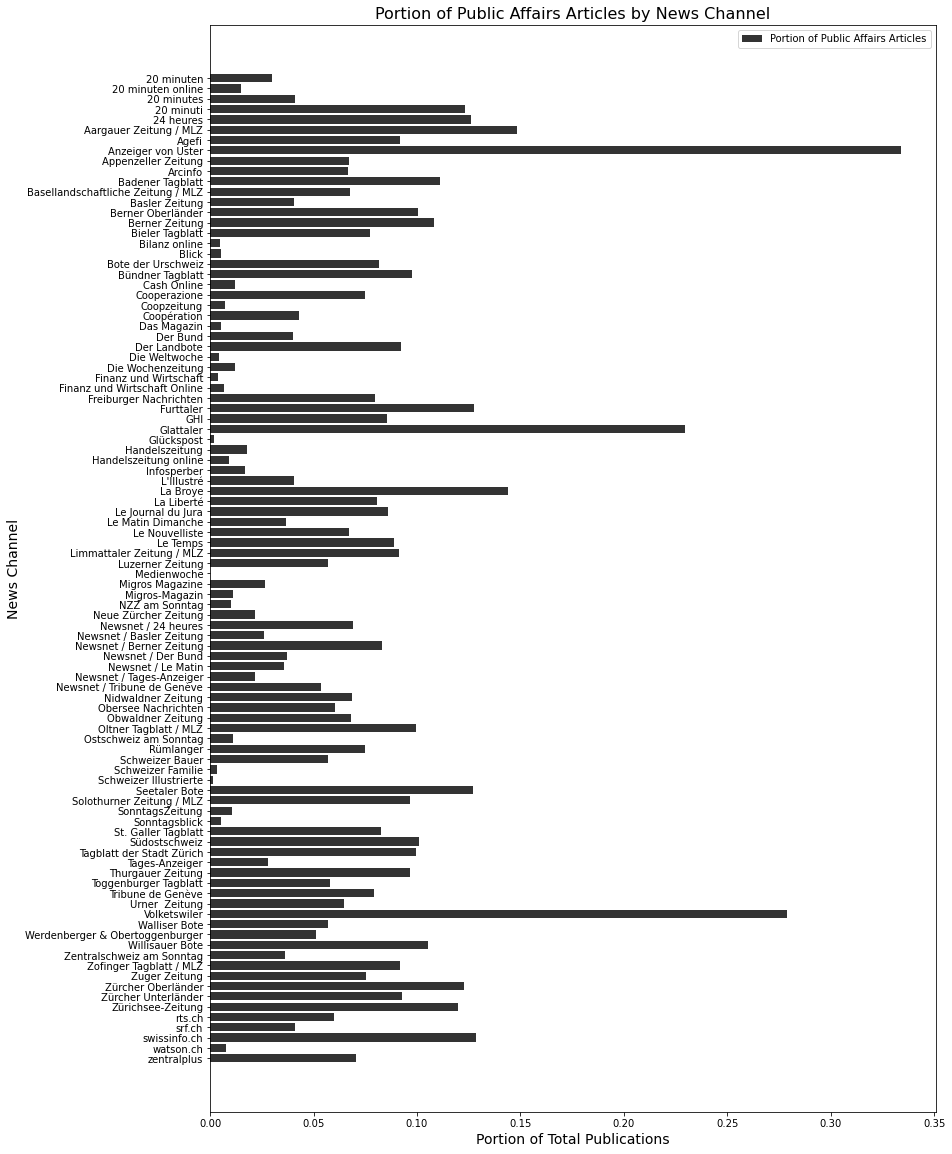

In [89]:
# public_affairs
show_topic_publication_portion_by_channels(articles, 'public_affairs', 'Public Affairs')

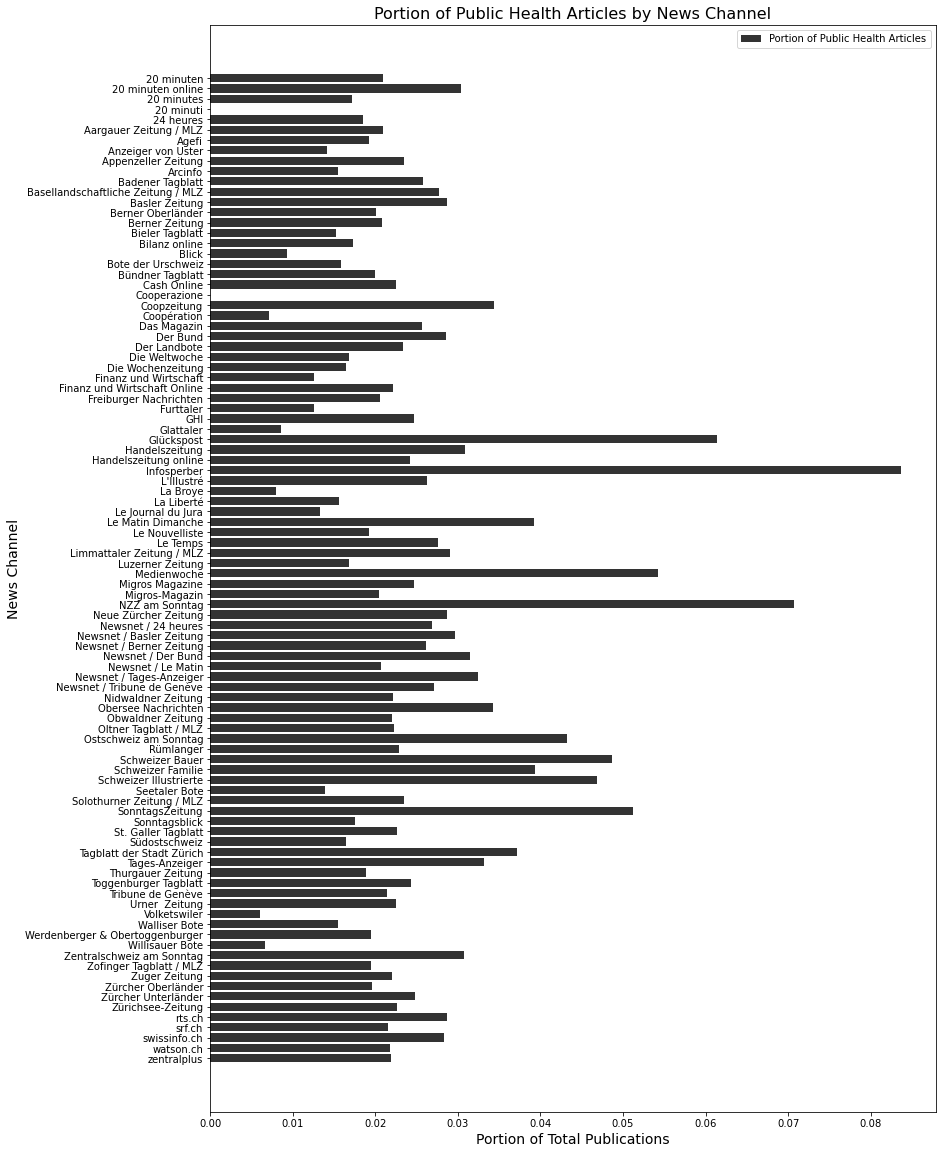

In [90]:
# public_health
show_topic_publication_portion_by_channels(articles, 'public_health', 'Public Health')

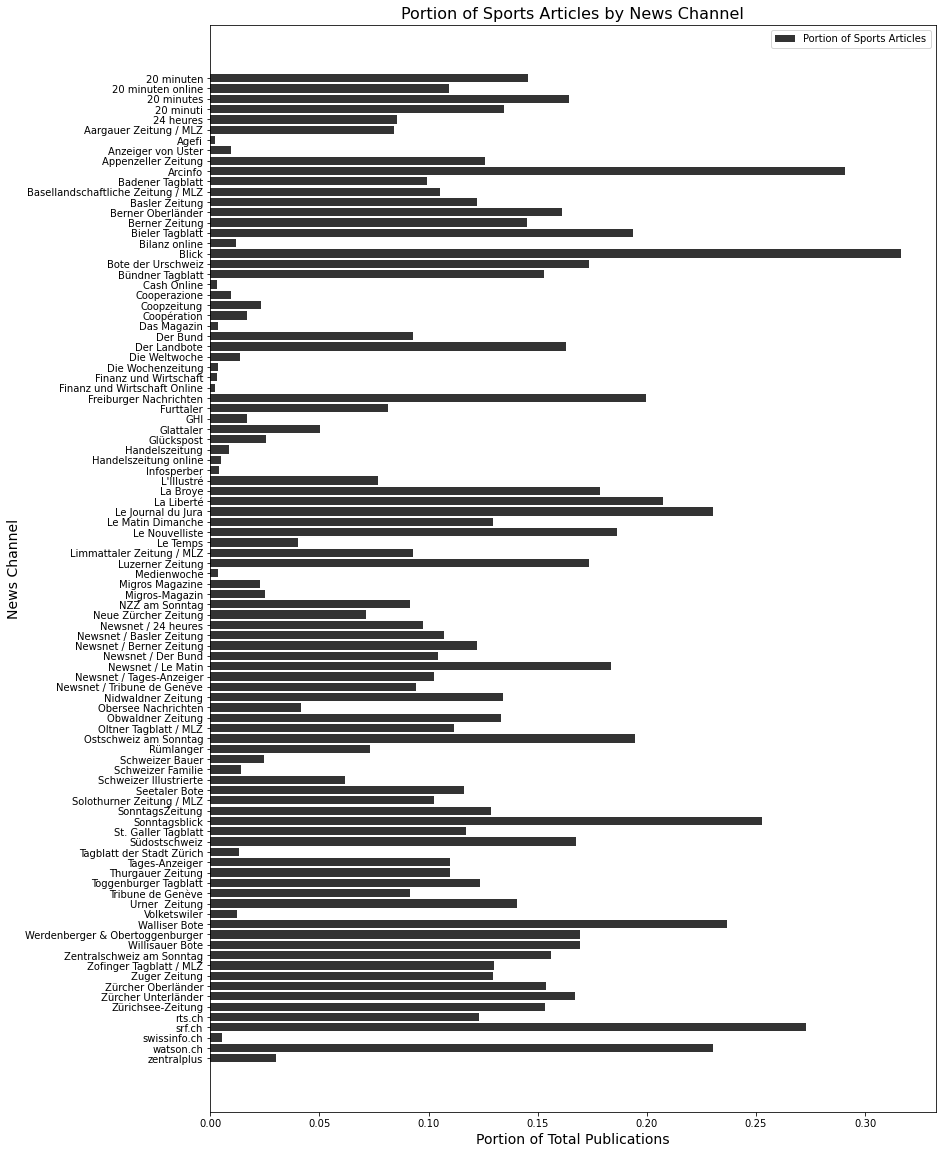

In [91]:
# sports
show_topic_publication_portion_by_channels(articles, 'sports', 'Sports')

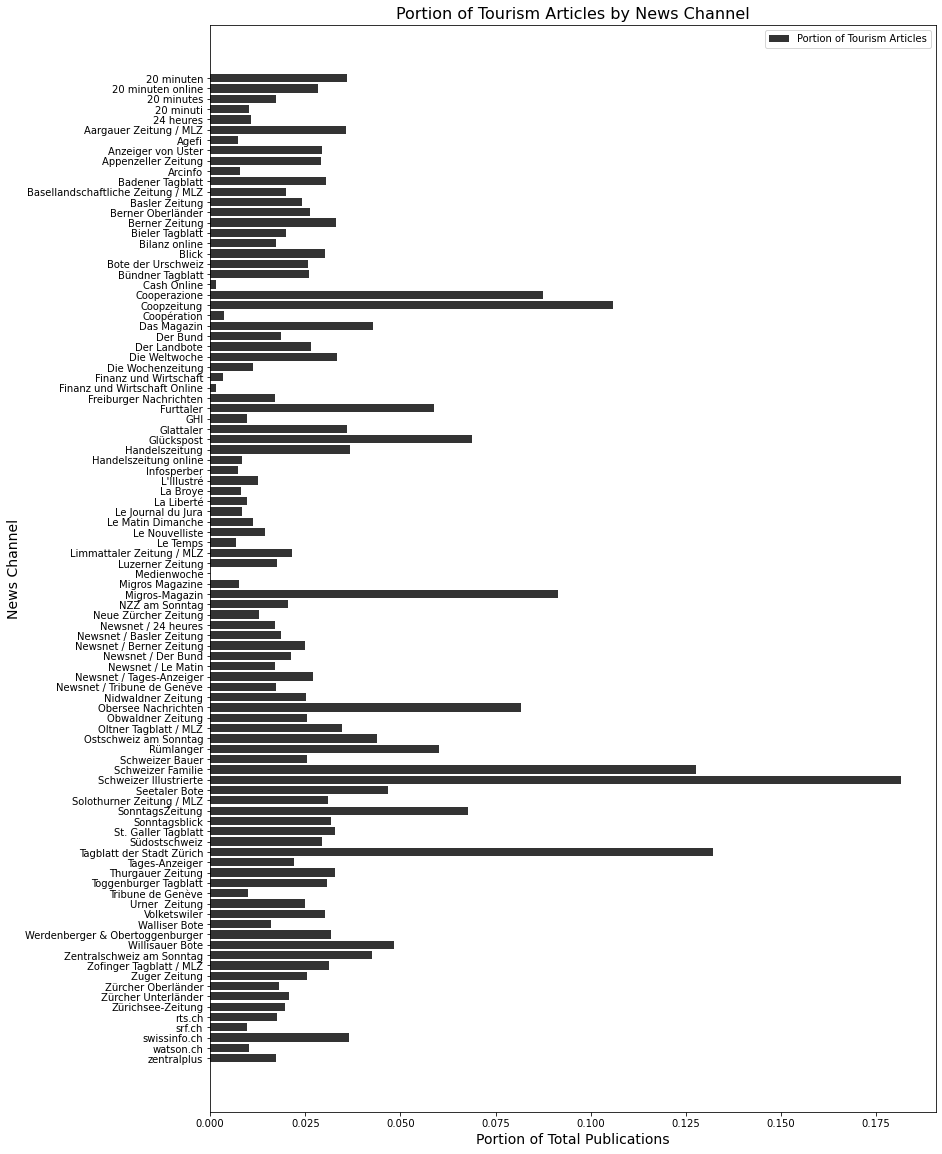

In [92]:
# tourism
show_topic_publication_portion_by_channels(articles, 'tourism', 'Tourism')

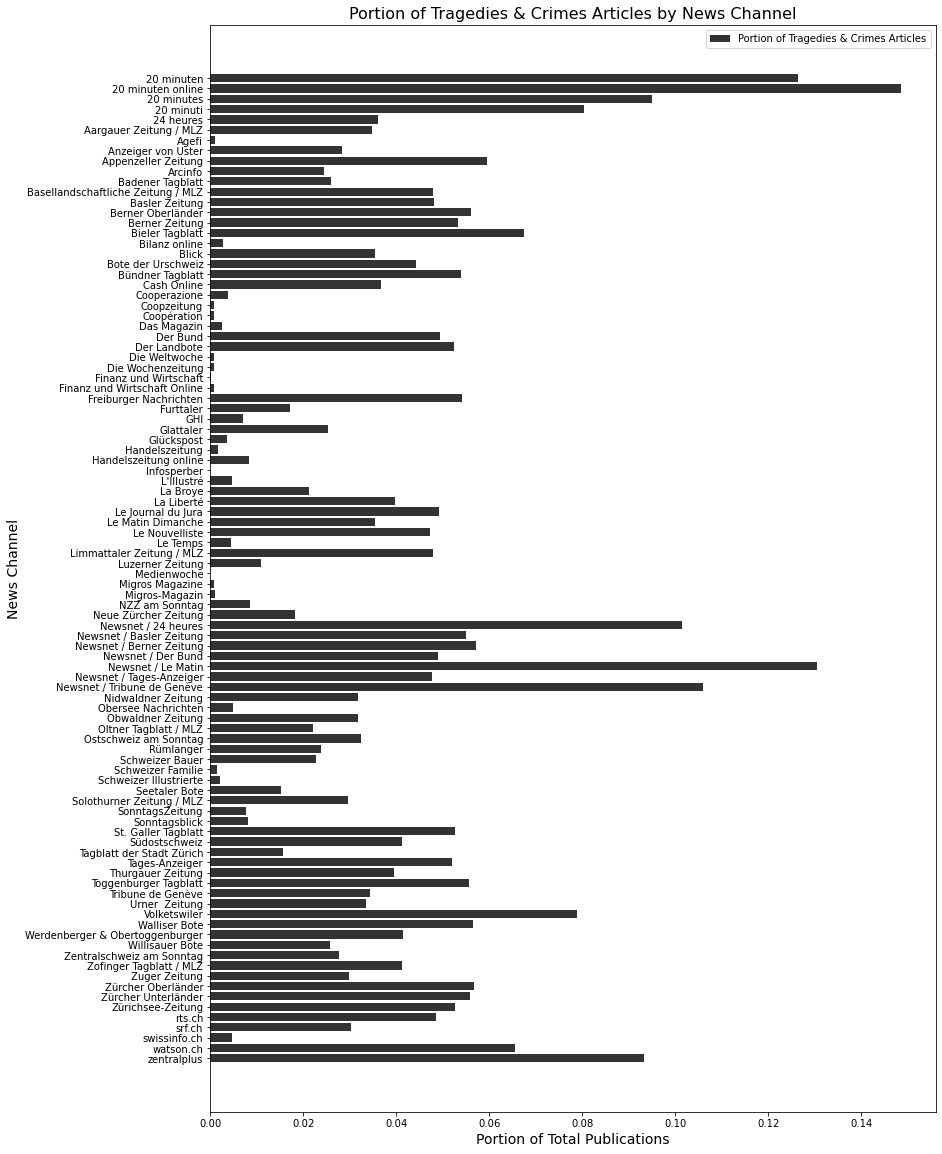

In [93]:
# tragedies_crimes
show_topic_publication_portion_by_channels(articles, 'tragedies_crimes', 'Tragedies & Crimes')

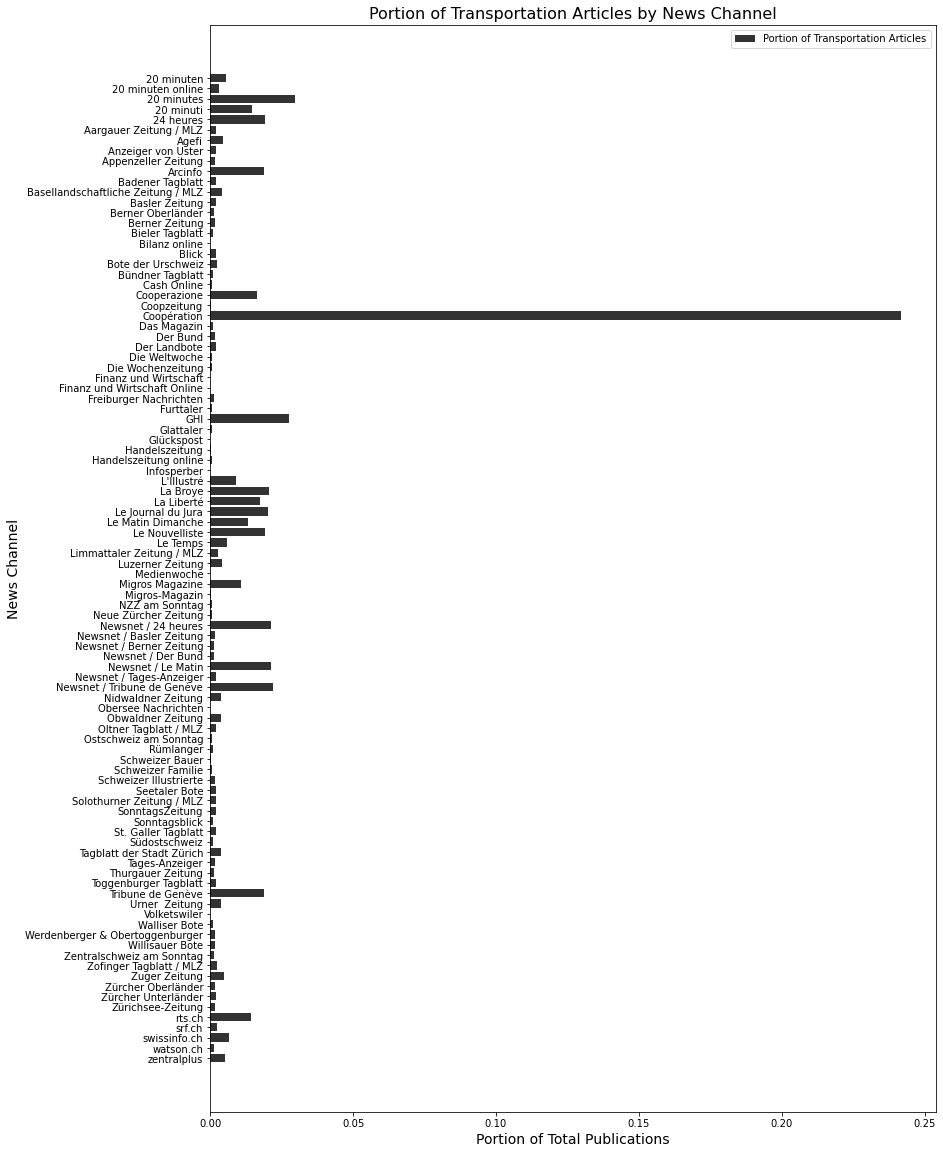

In [94]:
# transportation
show_topic_publication_portion_by_channels(articles, 'transportation', 'Transportation')

<div class="alert alert-info" style="background-color:#5d3a8e; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'> 
4. COVID specific Statistics and Graphs
</h2>
</div>

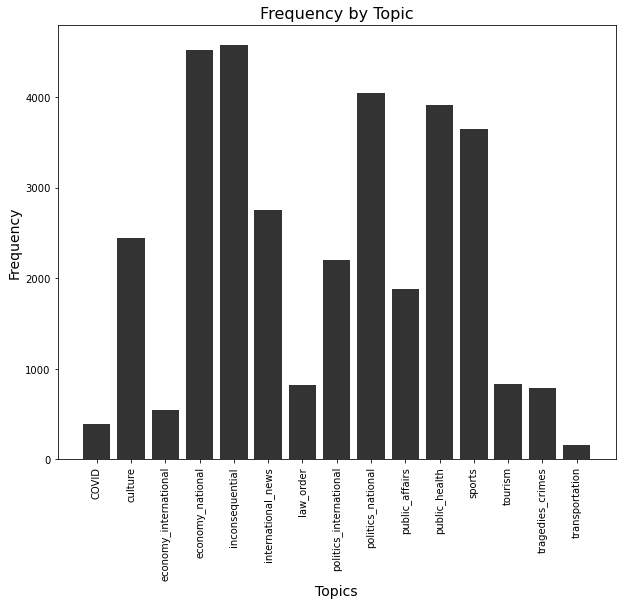

In [95]:
## Display the frequency of the most likely topics assigned to those articles where the second most likely topic is COVID with an affiliation probability of >= 0.25 (interesting for the LDA on the COVID articles)
# Get the frequency per topic
freq_by_topic_1 = articles.loc[np.logical_and(articles['Topic_2'] == 'COVID', articles['Affiliation_Prob_2'] >= 0.25)].groupby('Topic_1')['Topic_1'].count()
# Plot the frequency per topic
fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111)
x_pos = np.arange(len(freq_by_topic_1.index))
ax.bar(x_pos, freq_by_topic_1.values, align = 'center', color = 'black', alpha = 0.8)
ax.set_xticks(x_pos)
ax.set_xticklabels(freq_by_topic_1.index, rotation = 90, ha = 'center')
ax.set_title('Frequency by Topic')
ax.set_xlabel('Topics')
ax.set_ylabel('Frequency')
# Display the plot
plt.show()